In [11]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.metrics import (
    roc_curve, auc,
    precision_recall_curve,
    average_precision_score,
    classification_report,
    ConfusionMatrixDisplay,
    confusion_matrix)
import warnings
warnings.filterwarnings("ignore")

# Logistic regression code 

In [12]:
class LogisticRegressionScratch:
    """
    Binary Logistic Regression (cross‐entropy loss with optional L1/L2 regularization)
    trained via gradient updates. Supports 'batch', 'sgd', and 'mini-batch' solvers.
    """
    def __init__(self, lr=0.05, n_iters=5000, penalty=None, C=1.0, solver='batch', batch_size=64, tol=1e-6, random_state=None, verbose=False):
        self.lr = lr
        self.n_iters = n_iters
        self.penalty = penalty
        self.C = C
        self.solver = solver
        self.batch_size = batch_size
        self.tol = tol
        self.random_state = random_state
        self.verbose = verbose
        self.w = None

        """
        lr           : learning rate (step size for gradient updates)
        n_iters      : maximum number of gradient-descent iterations
        penalty      : type of regularization ('l1', 'l2', or None)
        C            : inverse regularization strength; larger C → weaker penalty
        solver       : optimization method ('batch', 'sgd', 'mini-batch')
        batch_size   : number of samples per update when using mini-batch
        tol          : convergence tolerance on weight change
        random_state : seed for reproducibility (weight init and sampling)
        verbose      : if True, print progress every 100 iterations
        """

    @staticmethod
    def sigmoid(z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        rng = np.random.RandomState(self.random_state)
        X = np.hstack([np.ones((X.shape[0], 1)), X])
        self.w = rng.normal(0, 0.01, size=X.shape[1])

        for iteration in range(self.n_iters):
            if self.solver == 'batch':
                idx = np.arange(len(y))
            elif self.solver == 'sgd':
                idx = [rng.randint(len(y))]
            elif self.solver == 'mini-batch':
                idx = rng.choice(len(y), self.batch_size, replace=False)
            else:
                raise ValueError(f"Unknown solver: {self.solver}")

            X_batch, y_batch = X[idx], y[idx]
            preds = self.sigmoid(X_batch.dot(self.w))
            grad = X_batch.T.dot(preds - y_batch) / len(idx)

            if self.penalty == 'l2':
                grad[1:] += self.w[1:] / self.C
            elif self.penalty == 'l1':
                grad[1:] += np.sign(self.w[1:]) / self.C

            w_old = self.w.copy()
            self.w -= self.lr * grad

            if np.linalg.norm(self.w - w_old) < self.tol:
                if self.verbose:
                    print(f"Converged at iteration {iteration}")
                break

            if self.verbose and iteration % 100 == 0:
                loss = -np.mean(y_batch * np.log(preds + 1e-12) + (1 - y_batch) * np.log(1 - preds + 1e-12))
                print(f"Iteration {iteration}, loss: {loss}")

    def predict_proba(self, X):
        X = np.hstack([np.ones((X.shape[0], 1)), X])
        return self.sigmoid(X.dot(self.w))

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

    def score(self, X, y):
        return np.mean(self.predict(X) == y)


# SVM Code

In [13]:
class LinearSVMScratch:
    """
    Linear SVM (hinge‐loss with L2 regularization) trained via gradient update.
    Supports 'batch', 'sgd', and 'mini‐batch' solvers.
    """
    def __init__(self,
                 lr=0.001,
                 C=1.0,
                 n_iters=1000,
                 solver='batch',
                 batch_size=32,
                 tol=1e-6,
                 random_state=None,
                 verbose=False):
        """
        lr         : Learning rate (η).
        C          : Regularization parameter (hinge‐loss weight).
        n_iters    : Number of iterations (updates).
        solver     : 'batch', 'sgd', or 'mini‐batch'.
        batch_size : Size of mini‐batch when solver='mini‐batch'.
        tol        : Convergence tolerance on weight change.
        random_state: Seed for reproducibility.
        verbose    : If True, print progress every 100 iters.
        """
        self.lr = lr
        self.C = C
        self.n_iters = n_iters
        self.solver = solver
        self.batch_size = batch_size
        self.tol = tol
        self.random_state = random_state
        self.verbose = verbose

        self.w = None   # Weight vector (including intercept as first element)
        self.b = None   # Not used separately; included in w[0] as intercept

    def _initialize(self, n_features):
        rng = np.random.RandomState(self.random_state)
        # Initialize weights small (including intercept at index 0)
        self.w = rng.normal(scale=0.01, size=(n_features + 1,))

    def fit(self, X, y):
        """
        Train the linear SVM.
          X: numpy array of shape (n_samples, n_features)
          y: array of shape (n_samples,) with labels {0,1} or {-1,+1} 
             If labels are {0,1}, they will be converted to {-1,+1}.
        """
        # Convert y to {-1, +1}
        y_svm = y.copy()
        y_svm = np.where(y_svm <= 0, -1, 1).astype(float)

        n_samples, n_features = X.shape
        # Add intercept column of 1's
        X_ext = np.hstack([np.ones((n_samples, 1)), X])  

        # Initialize weights
        self._initialize(n_features)

        rng = np.random.RandomState(self.random_state)
        prev_w = self.w.copy()

        for it in range(self.n_iters):
            # Choose indices according to solver
            if self.solver == 'batch':
                idx = np.arange(n_samples)
            elif self.solver == 'sgd':
                idx = [rng.randint(0, n_samples)]
            elif self.solver == 'mini-batch':
                idx = rng.choice(n_samples, self.batch_size, replace=False)
            else:
                raise ValueError(f"Unknown solver: {self.solver}")

            X_batch = X_ext[idx]
            y_batch = y_svm[idx]

            # Compute margins: y_i * (w^T x_i)
            margins = y_batch * (X_batch.dot(self.w))

            # Subgradient: for hinge‐loss
            # If margin < 1: subgradient = -y_i * x_i; else 0
            mask = margins < 1.0  # boolean mask, shape = (batch_size,)
            # For all violating samples, accumulate -y_i * x_i
            if mask.sum() > 0:
                grad_hinge = - (X_batch[mask].T.dot(y_batch[mask])) / len(idx)
            else:
                grad_hinge = np.zeros(self.w.shape)

            # Regularization gradient: w (excluding intercept)
            grad_reg = np.zeros_like(self.w)
            grad_reg[1:] = self.w[1:] / self.C

            # Full subgradient
            grad = grad_reg + grad_hinge

            # Update weights
            self.w -= self.lr * grad

            # Check for convergence
            if np.linalg.norm(self.w - prev_w) < self.tol:
                if self.verbose:
                    print(f"SVM converged at iteration {it}")
                break

            prev_w = self.w.copy()

            if self.verbose and (it % 100 == 0):
                # Optional: compute full-batch hinge loss + reg loss for logging
                logits = X_ext.dot(self.w)
                margins_full = y_svm * logits
                hinge_loss = np.maximum(0, 1 - margins_full).mean()
                reg_loss = 0.5 * np.sum(self.w[1:]**2) / self.C
                total_loss = hinge_loss + reg_loss
                print(f"Iter {it}, Loss = {total_loss:.6f}")

    def decision_function(self, X):
        """
        Return raw scores (w^T x + b) for each sample.
        """
        n_samples = X.shape[0]
        X_ext = np.hstack([np.ones((n_samples, 1)), X])
        return X_ext.dot(self.w)

    def predict(self, X):
        """
        Return predicted labels {0,1} using sign(decision_function).
        """
        scores = self.decision_function(X)
        return np.where(scores >= 0, 1, 0)

    def predict_proba(self, X):
        """
        Approximate P(y=1) via a sigmoid on the decision function:
            decision = X·w + b
            P(y=1)  = 1 / (1 + exp(−decision))
        Returns an array of shape (n_samples, 2): [P(y=0), P(y=1)].
        """
        # Compute the raw decision values (shape = (n_samples,))
        d = X.dot(self.w) + self.b
        # Sigmoid to get P(y=1)
        p1 = 1.0 / (1.0 + np.exp(-d))
        # P(y=0) = 1 - P(y=1)
        p0 = 1.0 - p1
        # Stack into shape (n_samples, 2)
        return np.vstack((p0, p1)).T

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)


# RF code

In [14]:
class DecisionTreeScratch:
    """
    A binary classification decision tree using CART (Gini impurity).
    Supports:
      - max_depth: maximum depth of the tree
      - min_samples_leaf: minimum number of samples required to be at a leaf
      - max_features: number of features to consider when looking for the best split
    """
    def __init__(self, max_depth=None, min_samples_leaf=1, max_features=None, random_state=None):
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features  # If None, consider all features at each split
        self.random_state = random_state
        self.tree_ = None  # Will hold the root node after fitting

    class Node:
        def __init__(self, feature_index=None, threshold=None, left=None, right=None, *, value=None):
            self.feature_index = feature_index  # index of feature to split on
            self.threshold = threshold          # threshold value for split
            self.left = left                    # left child (Node)
            self.right = right                  # right child (Node)
            self.value = value                  # class label if leaf

    def _gini(self, y):
        # Force y to integer before calling np.bincount
        y_int = y.astype(np.int64)

        m = len(y_int)
        if m == 0:
            return 0.0
        counts = np.bincount(y_int) 
        probs = counts / m
        return 1.0 - np.sum(probs**2)

    def _split_dataset(self, X_col, threshold):
        """
        Given a single feature column X_col and a threshold,
        returns two boolean masks: left_mask, right_mask.
        left_mask = X_col <= threshold
        right_mask = X_col > threshold
        """
        left_mask = X_col <= threshold
        right_mask = X_col > threshold
        return left_mask, right_mask

    def _best_split(self, X, y):
        """
        Find the best feature and threshold to split on by scanning
        over a random subset of features (if max_features is set) or all features.
        Returns: (best_feature_index, best_threshold, best_gain)
        If no valid split is found, returns (None, None, 0.0).
        """
        n_samples, n_features = X.shape
        if self.max_features is None:
            features = range(n_features)
        else:
            rng = np.random.RandomState(self.random_state)
            features = rng.choice(n_features, self.max_features, replace=False)

        best_gini = self._gini(y)
        best_gain = 0.0
        best_feat, best_thresh = None, None

        for feat in features:
            X_col = X[:, feat]
            sorted_idx = np.argsort(X_col)
            # Sort feature values and corresponding labels
            X_sorted = X_col[sorted_idx]
            y_sorted = y[sorted_idx]

            # Potential thresholds are midpoints between consecutive distinct values
            for i in range(1, n_samples):
                if X_sorted[i] == X_sorted[i - 1]:
                    continue
                thresh = (X_sorted[i] + X_sorted[i - 1]) / 2.0

                left_mask, right_mask = self._split_dataset(X_col, thresh)
                y_left, y_right = y[left_mask], y[right_mask]
                if len(y_left) < self.min_samples_leaf or len(y_right) < self.min_samples_leaf:
                    continue

                gini_left = self._gini(y_left)
                gini_right = self._gini(y_right)
                # Weighted average of child Gini
                child_gini = (len(y_left) * gini_left + len(y_right) * gini_right) / n_samples
                gain = best_gini - child_gini

                if gain > best_gain:
                    best_gain = gain
                    best_feat = feat
                    best_thresh = thresh

        return best_feat, best_thresh, best_gain

    def _build_tree(self, X, y, depth=0):
        """
        Recursively build the decision tree.
        Returns a Node.
        """
        n_samples, n_features = X.shape
        num_labels = len(np.unique(y))

        # Stopping conditions: 
        # 1) All labels are the same
        # 2) Reached max_depth
        # 3) Too few samples to split
        if (num_labels == 1 or
            (self.max_depth is not None and depth >= self.max_depth) or
            n_samples < 2 * self.min_samples_leaf):
            # Create a leaf node
            leaf_value = np.bincount(y).argmax()
            return self.Node(value=leaf_value)

        # Find best split
        feat_idx, thresh, gain = self._best_split(X, y)
        if gain == 0.0 or feat_idx is None:
            # Cannot split further, create a leaf
            leaf_value = np.bincount(y).argmax()
            return self.Node(value=leaf_value)

        # Split dataset
        left_mask, right_mask = self._split_dataset(X[:, feat_idx], thresh)
        X_left, y_left = X[left_mask], y[left_mask]
        X_right, y_right = X[right_mask], y[right_mask]

        # Recursively build left and right subtrees
        left_child = self._build_tree(X_left, y_left, depth + 1)
        right_child = self._build_tree(X_right, y_right, depth + 1)
        return self.Node(feature_index=feat_idx, threshold=thresh,
                         left=left_child, right=right_child)

    def fit(self, X, y):
        self.tree_ = self._build_tree(X, y, depth=0)

    def _predict_sample(self, x, node):
        """
        Predict the class label for a single sample x by traversing the tree.
        """
        if node.value is not None:
            return node.value
        if x[node.feature_index] <= node.threshold:
            return self._predict_sample(x, node.left)
        else:
            return self._predict_sample(x, node.right)

    def predict(self, X):
        """
        Predict class labels for each sample in X.
        Returns an array of shape (n_samples,)
        """
        return np.array([self._predict_sample(x, self.tree_) for x in X])

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)


class RandomForestScratch:
    """
    A Random Forest classifier for binary classification.
    Trains multiple DecisionTreeScratch with bootstrapping and feature subsampling.
    Supports:
      - n_estimators: number of trees
      - max_depth: passed to each DecisionTreeScratch
      - min_samples_leaf: passed to each tree
      - max_features: number of features to consider at each split in each tree
      - bootstrap: whether to bootstrap samples (always True here)
    """
    def __init__(self,
                 n_estimators=10,
                 max_depth=None,
                 min_samples_leaf=1,
                 max_features=None,
                 random_state=None,
                 verbose=False):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.random_state = random_state
        self.verbose = verbose

        self.trees_ = []        # List of DecisionTreeScratch instances
        self.bootstraps_ = []   # List of index arrays for bootstrap samples

    def fit(self, X, y):
        """
        Build the forest of decision trees.
        """
        rng = np.random.RandomState(self.random_state)
        n_samples, n_features = X.shape

        # Determine max_features per split if not specified
        if self.max_features is None:
            # Standard practice: sqrt(n_features)
            self.max_features_ = int(np.sqrt(n_features))
        else:
            self.max_features_ = self.max_features

        self.trees_ = []
        self.bootstraps_ = []

        for i in range(self.n_estimators):
            # 1) Create a bootstrap sample of indices
            indices = rng.choice(n_samples, n_samples, replace=True)
            self.bootstraps_.append(indices)

            # 2) Instantiate a new decision tree with same hyperparameters
            tree = DecisionTreeScratch(
                max_depth=self.max_depth,
                min_samples_leaf=self.min_samples_leaf,
                max_features=self.max_features_,
                random_state=rng.randint(0, 1000000)
            )
            # 3) Fit tree on the bootstrap sample
            tree.fit(X[indices], y[indices])
            self.trees_.append(tree)

            if self.verbose:
                print(f"Trained tree {i+1}/{self.n_estimators}")

    def predict(self, X):
        """
        Predict class labels for X by majority‐voting across all trees.
        Returns array of shape (n_samples,)
        """
        # Collect each tree's predictions into shape (n_estimators, n_samples)
        all_preds = np.array([tree.predict(X) for tree in self.trees_])  # shape = (n_estimators, n_samples)
        # Transpose to (n_samples, n_estimators), then take majority vote
        all_preds = all_preds.T  # shape = (n_samples, n_estimators)
        y_pred = np.apply_along_axis(lambda row: np.bincount(row).argmax(), axis=1, arr=all_preds)
        return y_pred

    def predict_proba(self, X):
        """
        For each sample in X, have each tree vote {0,1}.
        Return an array of shape (n_samples, 2) where:
            P(y=1) = fraction_of_trees_predicting_1,
            P(y=0) = 1 - P(y=1).
        Assumes self.trees_ is a list of trained DecisionTreeScratch instances,
        each with a .predict(X) method returning 0 or 1.
        """
        # If no trees have been built yet, raise an error
        if not hasattr(self, 'trees_') or len(self.trees_) == 0:
            raise ValueError("No trees found: did you call fit() before predict_proba()?")

        # Collect each tree's vote. This yields shape = (n_trees, n_samples):
        all_votes = np.array([tree.predict(X) for tree in self.trees_])
        # Sum along axis=0 to get, for each sample, how many trees voted “1”
        vote_sum = np.sum(all_votes, axis=0)  # shape = (n_samples,)
        n_trees = len(self.trees_)

        # Fraction voting for class 1:
        p1 = vote_sum / n_trees
        # Fraction voting for class 0:
        p0 = 1.0 - p1

        # Stack into an (n_samples, 2) array:
        return np.vstack((p0, p1)).T

    def score(self, X, y):
        """
        Compute accuracy on (X, y).
        """
        y_pred = self.predict(X)
        return np.mean(y_pred == y)


# Starting titanic dataset

# Descriptive Data

               Non-null  Null    Dtype
PassengerId         891     0    int64
Survived            891     0    int64
Pclass              891     0    int64
Name                891     0   object
Sex                 891     0    int64
Age                 891     0  float64
SibSp               891     0    int64
Parch               891     0    int64
Ticket              891     0   object
Fare                891     0  float64
Cabin               204   687   object
Embarked            891     0   object
FamilySize          891     0    int64
FarePerPerson       891     0  float64
IsAlone             891     0    int32
       PassengerId    Survived      Pclass         Sex         Age  \
count   891.000000  891.000000  891.000000  891.000000  891.000000   
mean    446.000000    0.383838    2.308642    0.352413   29.361582   
std     257.353842    0.486592    0.836071    0.477990   13.019697   
min       1.000000    0.000000    1.000000    0.000000    0.420000   
25%     223.500000    0.00

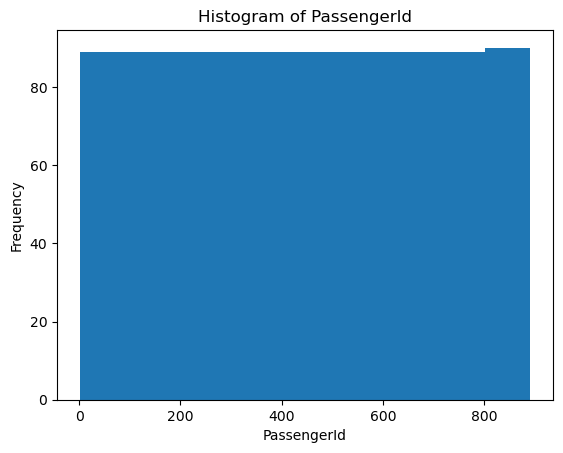

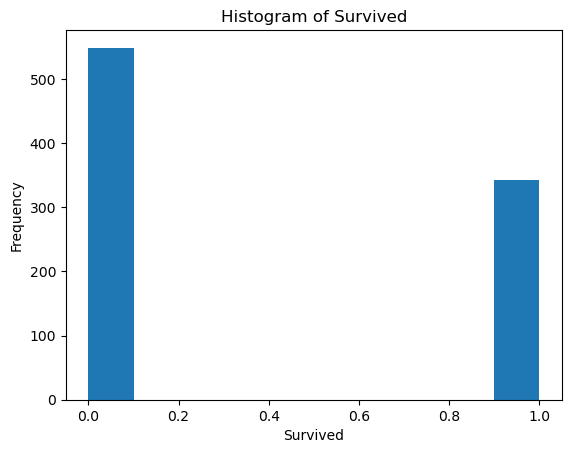

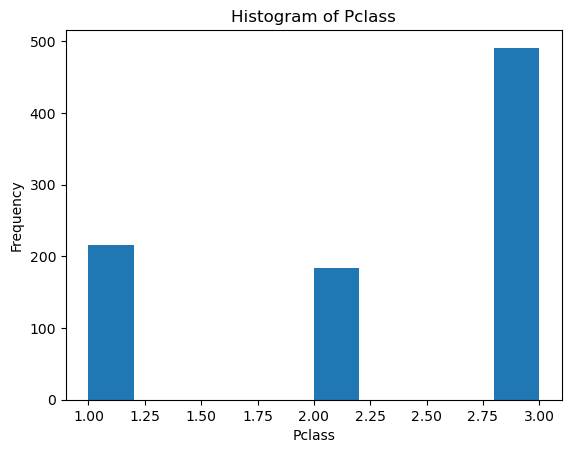

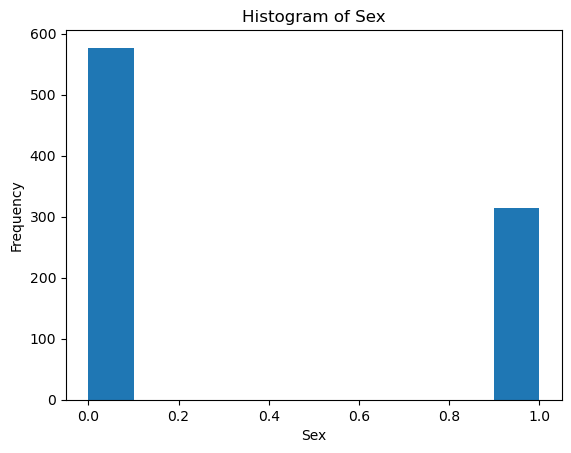

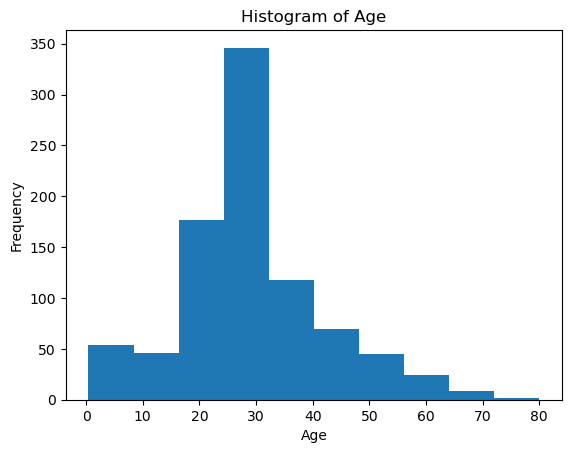

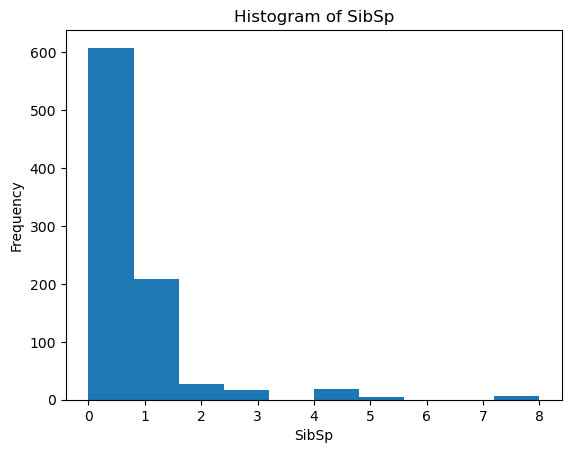

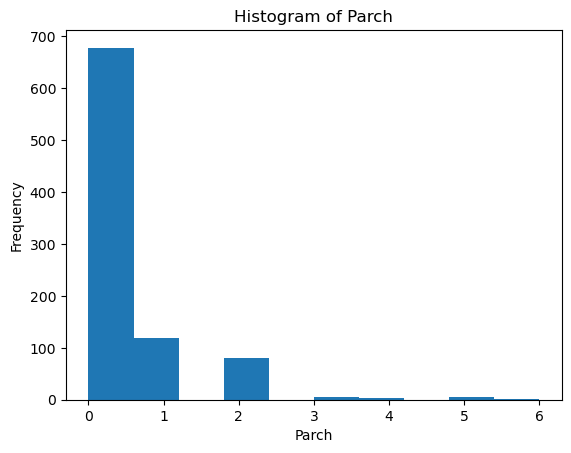

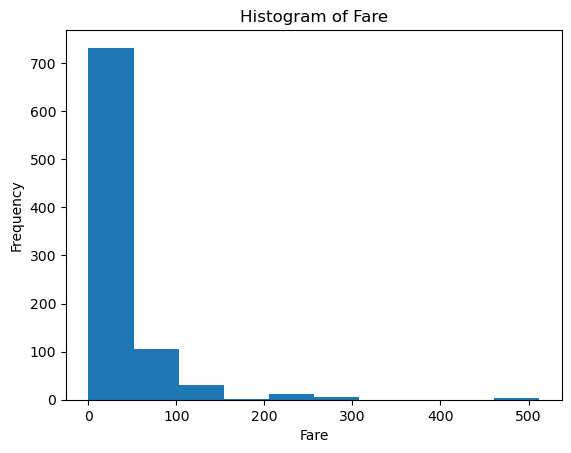

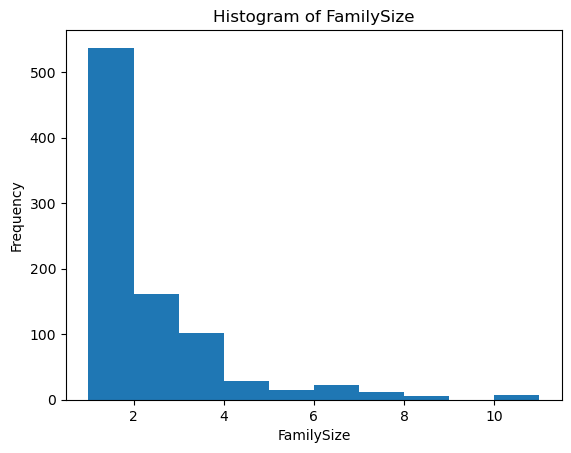

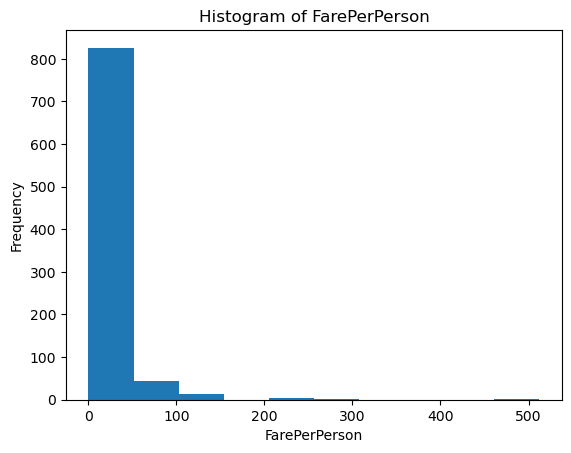

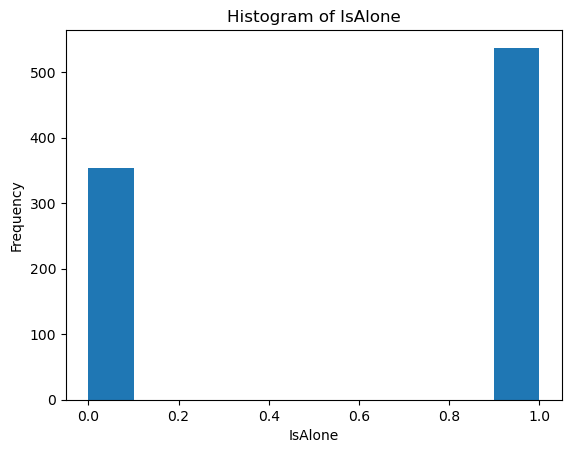

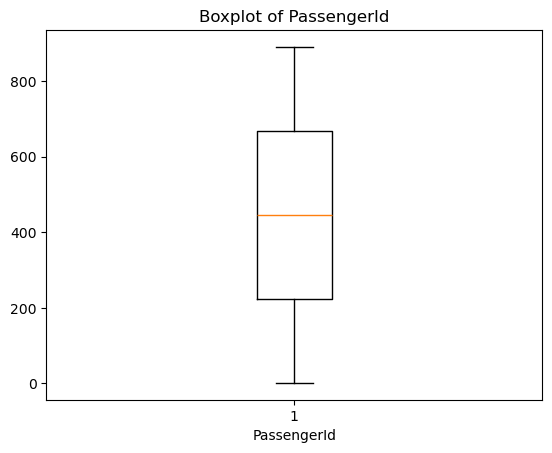

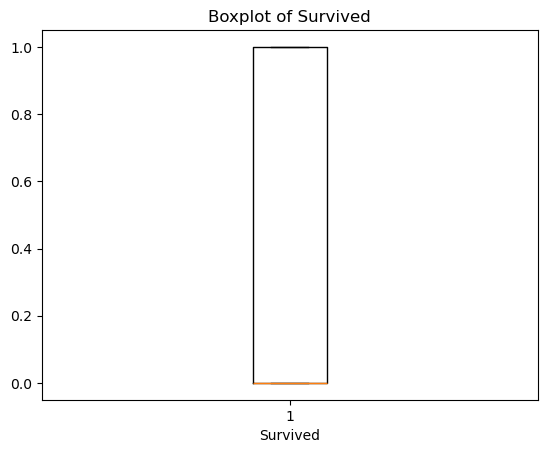

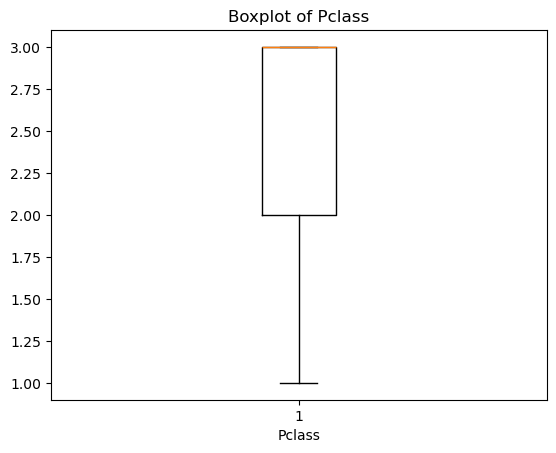

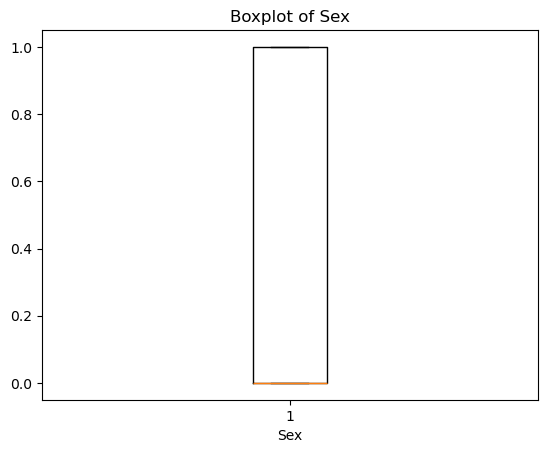

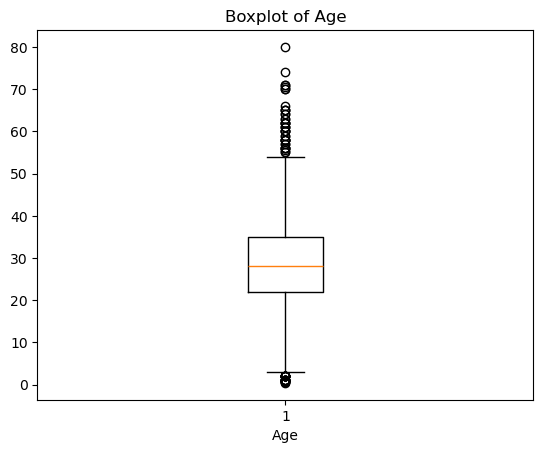

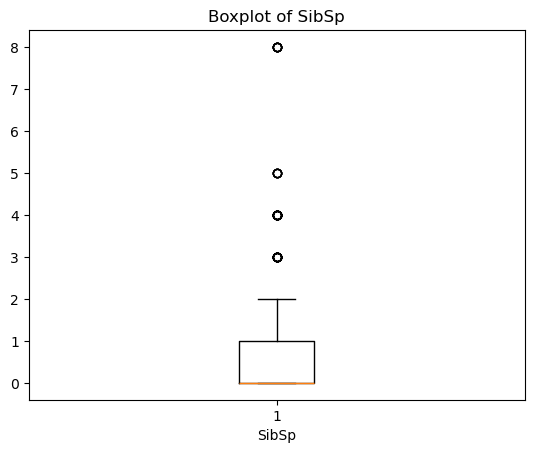

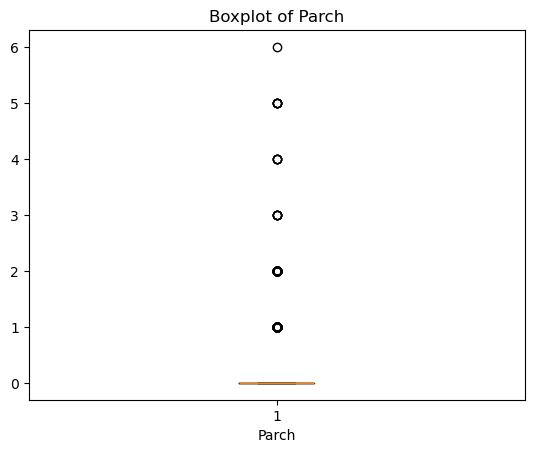

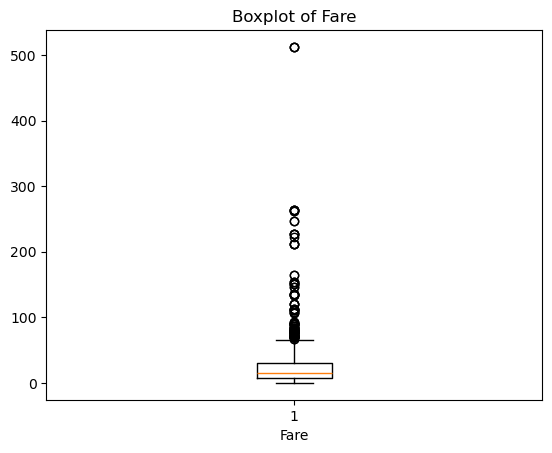

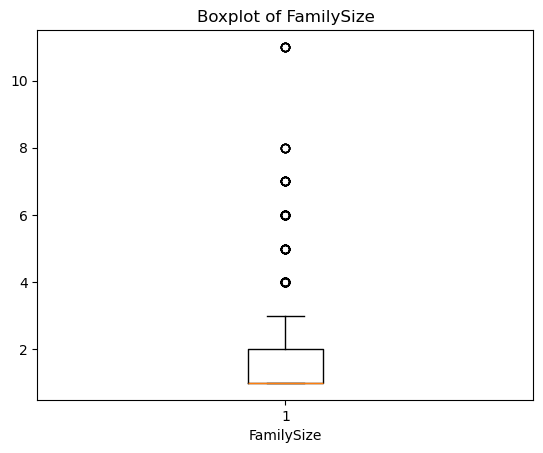

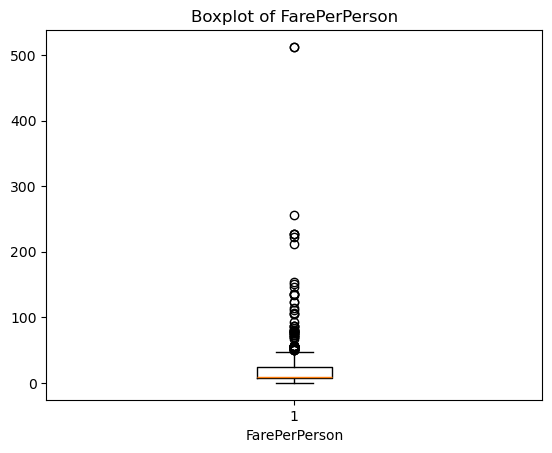

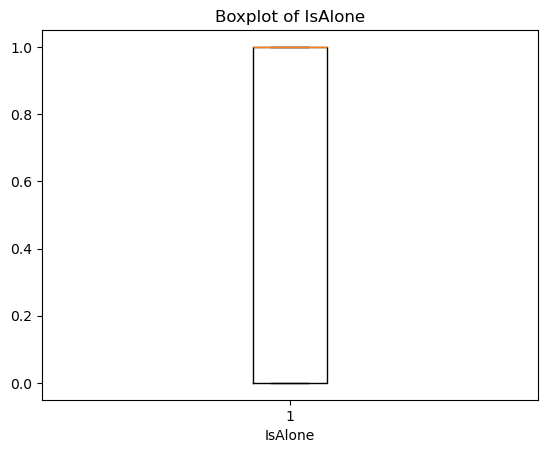

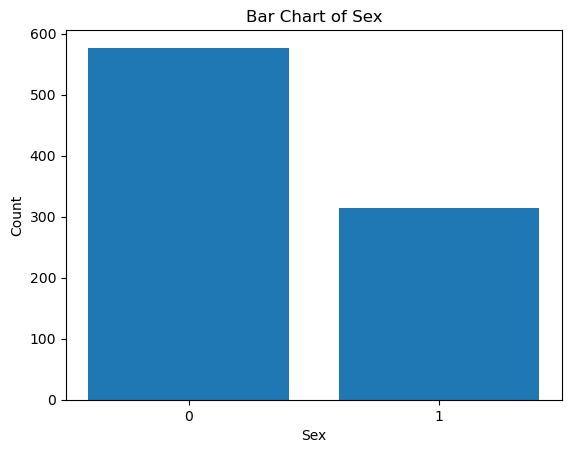

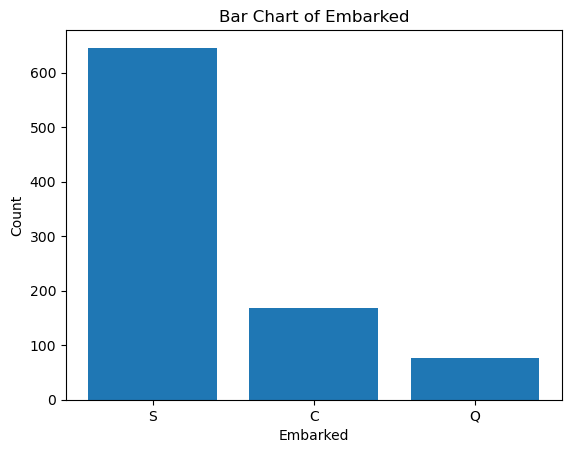

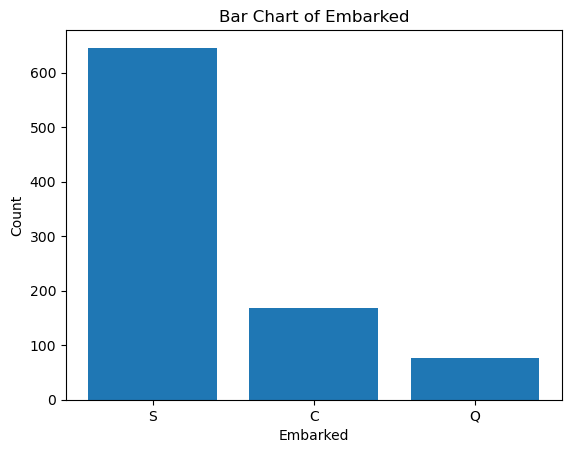

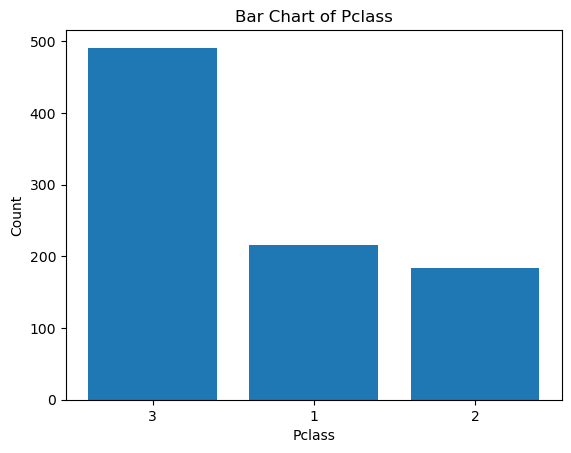

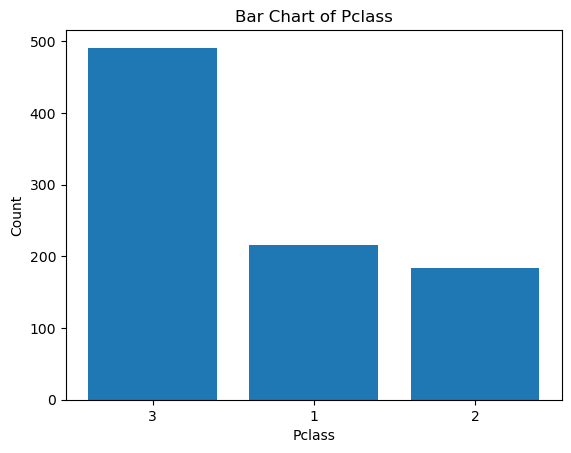

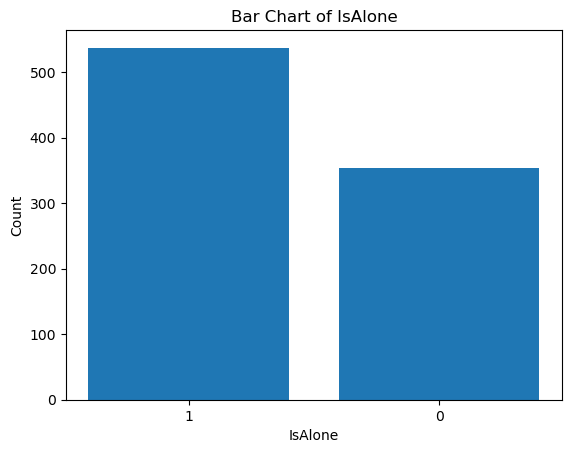

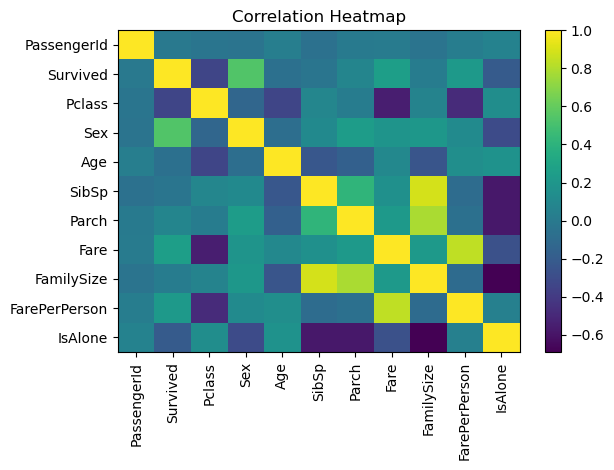

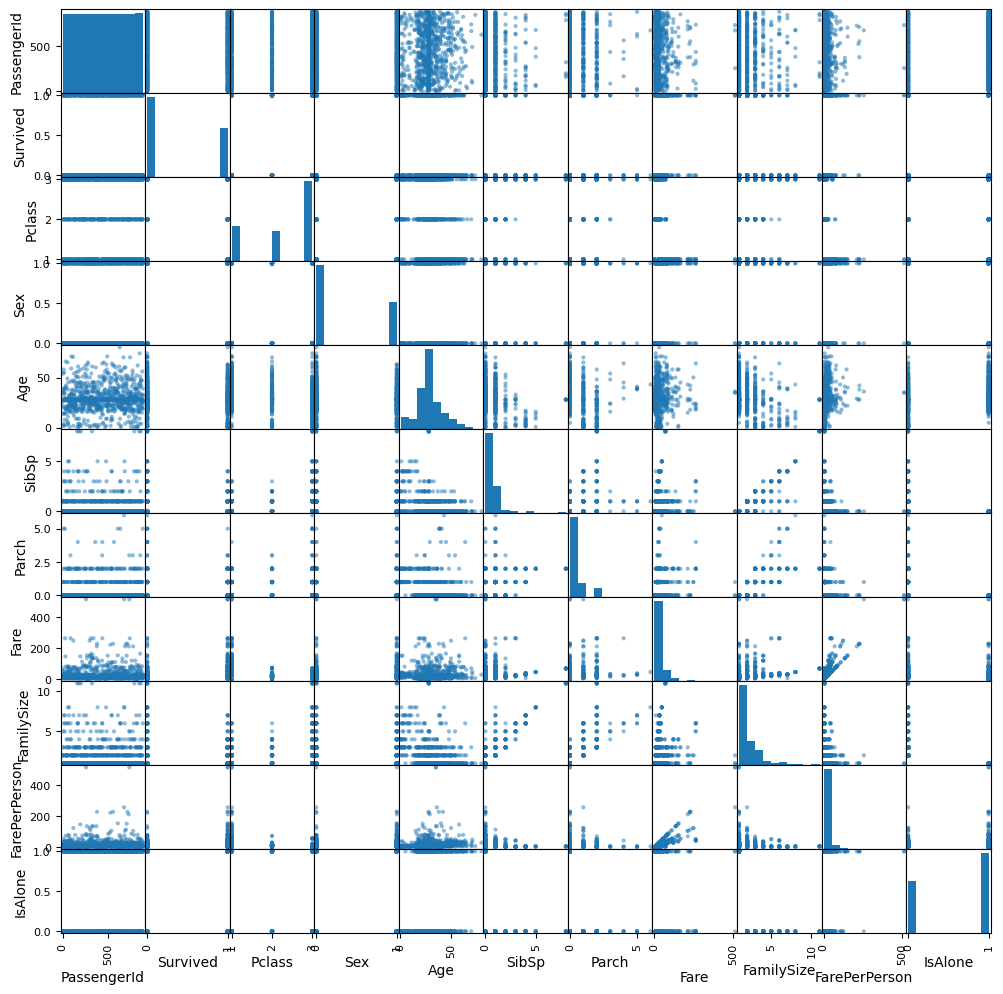

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


# 1) We load the Titanic dataset

path = r'C:\Users\Maestro\Desktop\Master DSE\Machine Learning & Statistical Learning\Cesa Bianchi\Data\Titanic\titanic.csv'
df = pd.read_csv(path)

# We encode 'Sex'
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

# We fill missing 'Embarked' with mode
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

# We fill missing 'Age' with median
df['Age'] = df['Age'].fillna(df['Age'].median())

# We create new features
df['FamilySize']    = df['SibSp'] + df['Parch'] + 1
df['FarePerPerson'] = df['Fare'] / df['FamilySize']
df['IsAlone']       = (df['FamilySize'] == 1).astype(int)

# We count nulls, non-nulls and dtypes
info_df = pd.DataFrame({
    'Non-null': df.count(),
    'Null': df.isnull().sum(),
    'Dtype': df.dtypes.astype(str)
})
print(info_df)

# Numerical descriptive stats
num_desc = df.describe()
print(num_desc)


# All columns descriptive stats
all_desc = df.describe(include='all')
print(all_desc)

# Value counts for key categorical features
for col in ['Sex', 'Embarked', 'Embarked', 'Pclass', 'Pclass', 'IsAlone']:
    vc = df[col].value_counts().reset_index()
    vc.columns = [col, 'Count']
print(vc)

# Correlation matrix
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()
print(corr)


# We get the list of numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Histograms
for col in numeric_cols:
    plt.figure()
    plt.hist(df[col].dropna())
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

# Boxplots
for col in numeric_cols:
    plt.figure()
    plt.boxplot(df[col].dropna())
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
    plt.show()

# Bar charts for categorical
for col in ['Sex', 'Embarked', 'Embarked', 'Pclass', 'Pclass', 'IsAlone']:
    plt.figure()
    counts = df[col].value_counts()
    plt.bar(counts.index.astype(str), counts.values)
    plt.title(f"Bar Chart of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

# Correlation heatmap
plt.figure()
plt.imshow(corr, aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.index)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

# Scatter matrix of numeric features
scatter_matrix(df[numeric_cols].dropna(), diagonal='hist', figsize=(12, 12))
plt.show()

# Data Pre-processing

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

# We identify numeric and categorical data

numeric_cols = ['Age', 'Fare', 'FamilySize', 'FarePerPerson']
categorical_cols = ['Sex', 'IsAlone', 'Embarked', 'Pclass']

# We force‐convert numeric columns to avoid errros

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# If any NaN appeared, impute with median
num_imputer = SimpleImputer(strategy='median')
df[numeric_cols] = num_imputer.fit_transform(df[numeric_cols])


# We remove outliers in numeric columns with the Inter Quantile Range method

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower) & (df[col] <= upper)].reset_index(drop=True)

df.dropna(axis=1,thresh=200,inplace=True)

# One-hot encode
df = pd.get_dummies(df, columns=['Embarked', 'Pclass'], drop_first=True)

#We identify the target
TARGET = 'Survived'

# We idntify features to use 
FEATURES = [
    'Sex', 'Age', 'Fare', 'FamilySize', 'FarePerPerson', 'IsAlone',
    'Embarked_Q', 'Embarked_S', 'Pclass_2', 'Pclass_3'
]

# We filter down to the columns we need
X = df[FEATURES].values
y = df[TARGET].values

# We split into train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# We scale numeric columns
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)


In [17]:
df

PassengerId  Survived                                               Name  \
0              1         0                            Braund, Mr. Owen Harris   
1              3         1                             Heikkinen, Miss. Laina   
2              5         0                           Allen, Mr. William Henry   
3              6         0                                   Moran, Mr. James   
4              9         1  Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)   
..           ...       ...                                                ...   
556          883         0                       Dahlberg, Miss. Gerda Ulrika   
557          884         0                      Banfield, Mr. Frederick James   
558          885         0                             Sutehall, Mr. Henry Jr   
559          887         0                              Montvila, Rev. Juozas   
560          891         0                                Dooley, Mr. Patrick   

     Sex   Age  SibSp  Parch            Ticket     Fare  FamilySize  \
0      0  22.0      1      0         A/5 21171   7.2500         2.0   
1      1  26.0      0      0  STON/O2. 3101282   7.9250         1.0   
2      0  35.0      0      0            373450   8.0500         1.0   
3      0  28.0      0      0            330877   8.4583         1.0   
4      1  27.0      0      2            347742  11.1333         3.0   
..   ...   ...    ...    ...               ...      ...         ...   
556    1  22.0      0      0              7552  10.5167         1.0   
557    0  28.0      0      0  C.A./SOTON 34068  10.5000         1.0   
558    0  25.0      0      0   SOTON/OQ 392076   7.0500         1.0   
559    0  27.0      0      0            211536  13.0000         1.0   
560    0  32.0      0      0            370376   7.7500         1.0   

     FarePerPerson  IsAlone  Embarked_Q  Embarked_S  Pclass_2  Pclass_3  
0           3.6250        0       False        True     False      True  
1           7.9250        1       False        True     False      True  
2           8.0500        1       False        True     False      True  
3           8.4583        1        True       False     False      True  
4           3.7111        0       False        True     False      True  
..             ...      ...         ...         ...       ...       ...  
556        10.5167        1       False        True     False      True  
557        10.5000        1       False        True      True     False  
558         7.0500        1       False        True     False      True  
559        13.0000        1       False        True      True     False  
560         7.7500        1        True       False     False      True  

[561 rows x 16 columns]

# Final Descriptive Statistics

               Non-null  Null    Dtype
PassengerId         561     0    int64
Survived            561     0    int64
Name                561     0   object
Sex                 561     0    int64
Age                 561     0  float64
SibSp               561     0    int64
Parch               561     0    int64
Ticket              561     0   object
Fare                561     0  float64
FamilySize          561     0  float64
FarePerPerson       561     0  float64
IsAlone             561     0    int32
Embarked_Q          561     0     bool
Embarked_S          561     0     bool
Pclass_2            561     0     bool
Pclass_3            561     0     bool
       PassengerId    Survived         Sex         Age       SibSp  \
count   561.000000  561.000000  561.000000  561.000000  561.000000   
mean    443.923351    0.303030    0.304813   27.738859    0.242424   
std     257.561198    0.459978    0.460739    8.907811    0.472513   
min       1.000000    0.000000    0.000000    3.000000   

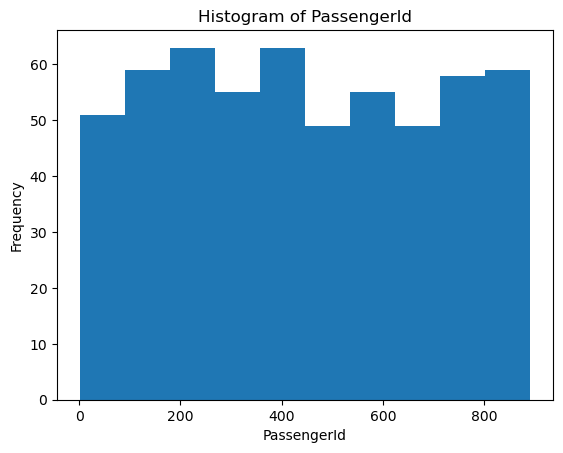

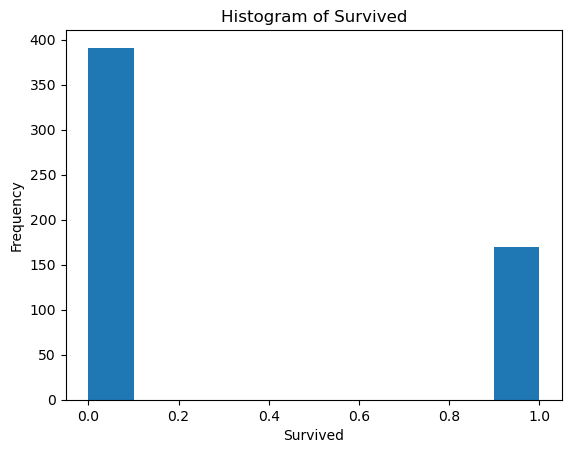

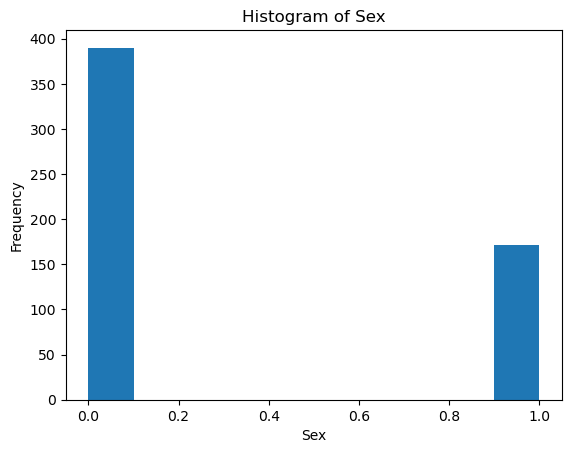

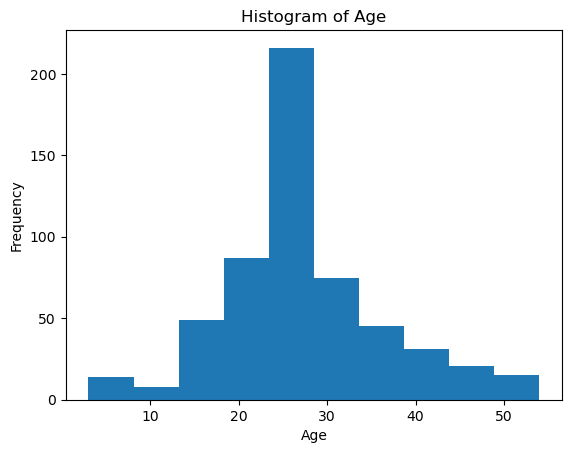

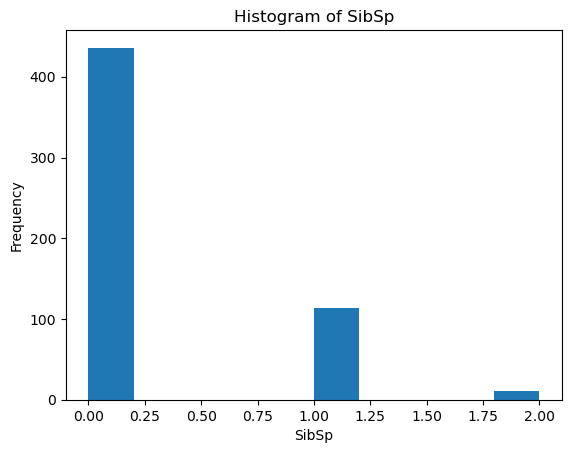

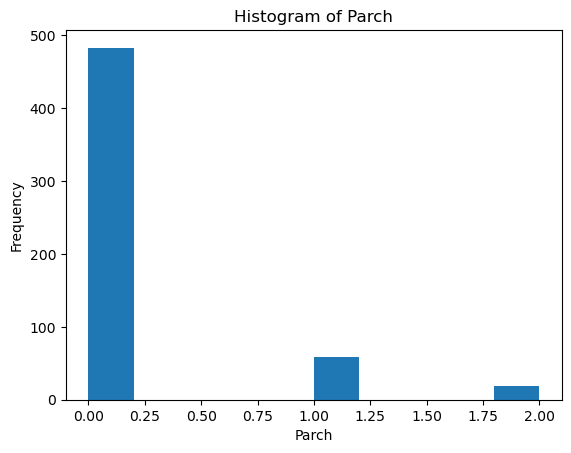

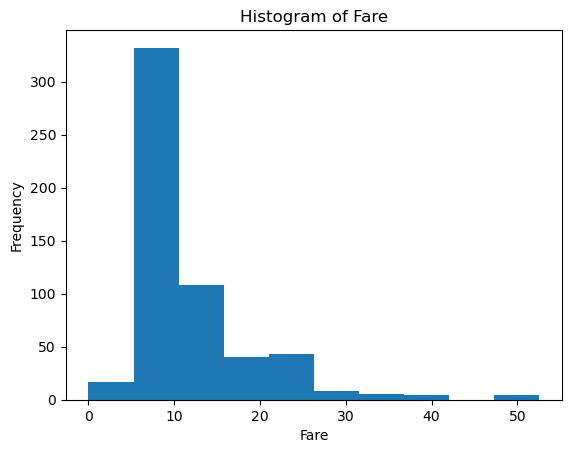

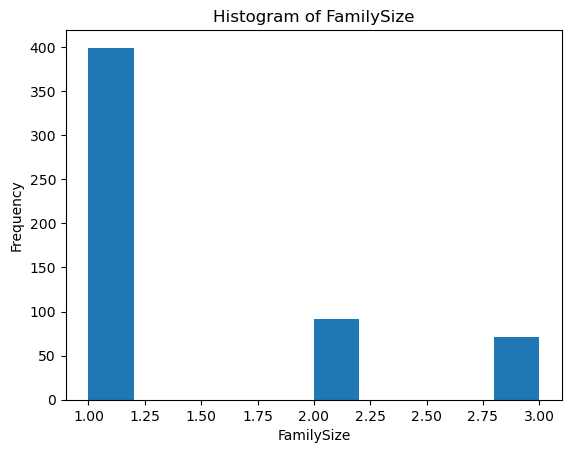

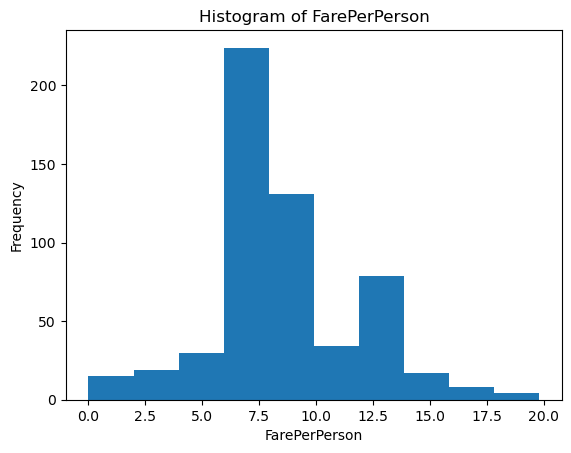

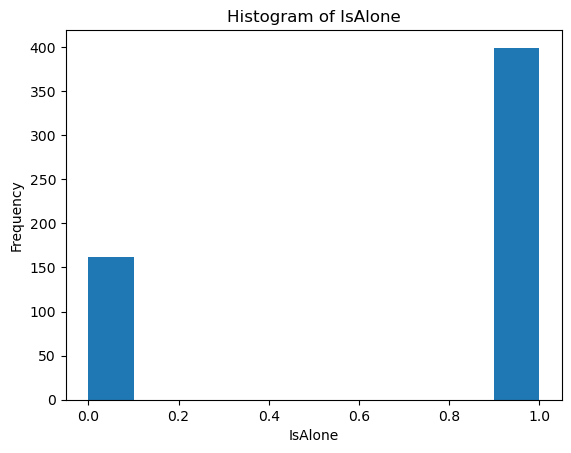

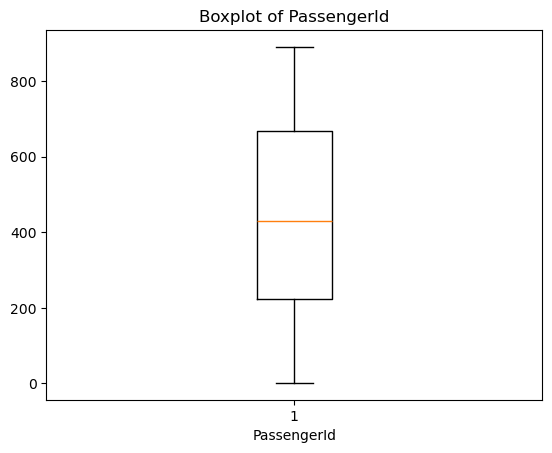

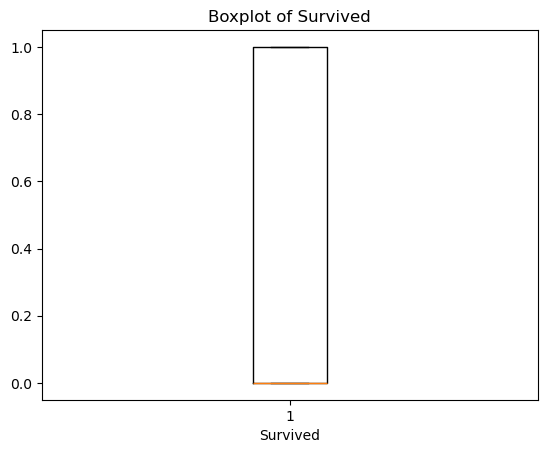

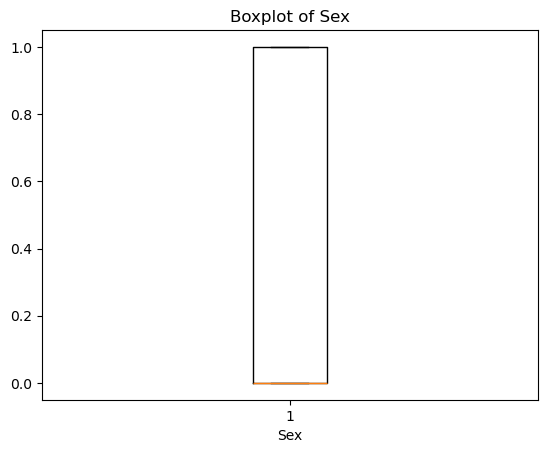

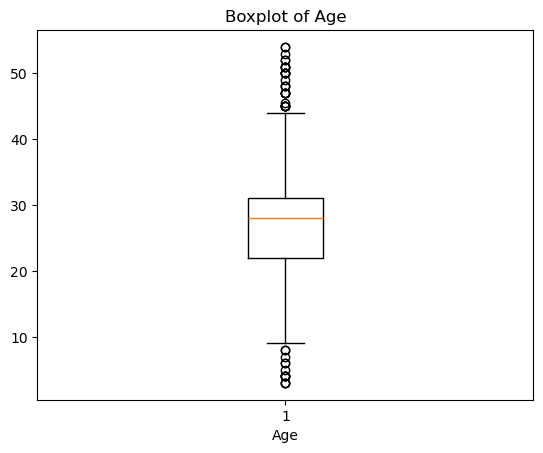

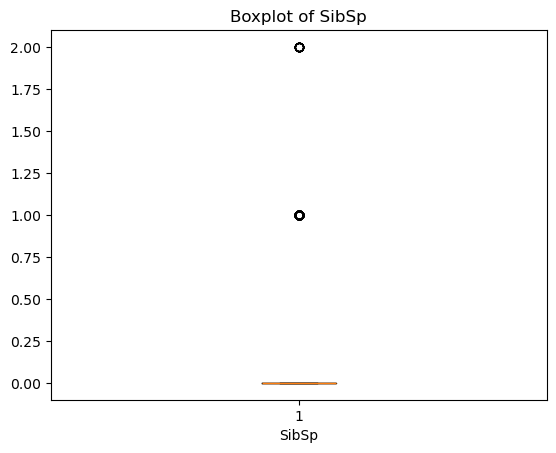

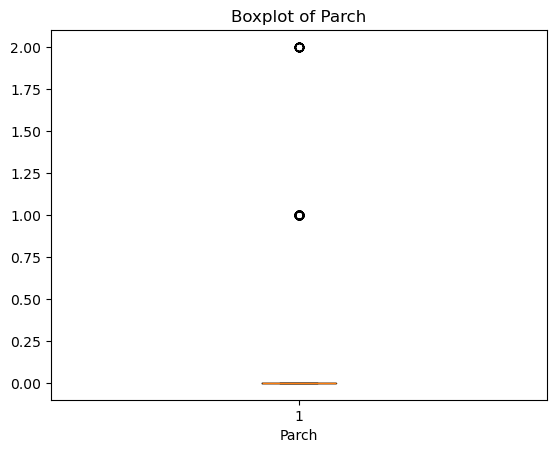

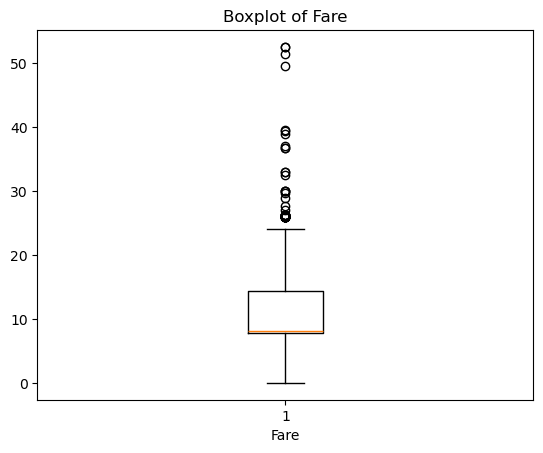

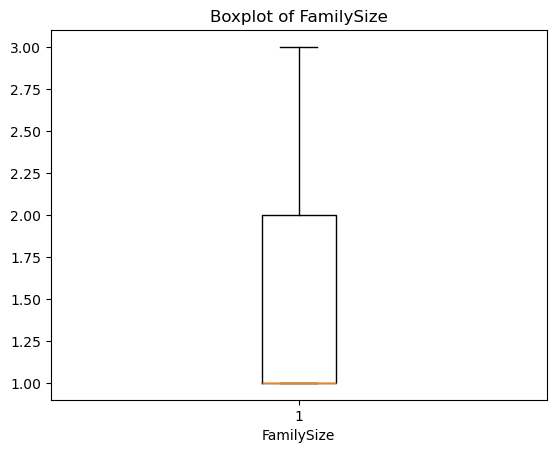

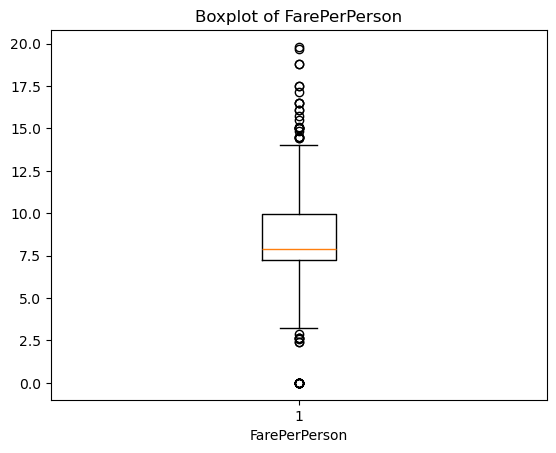

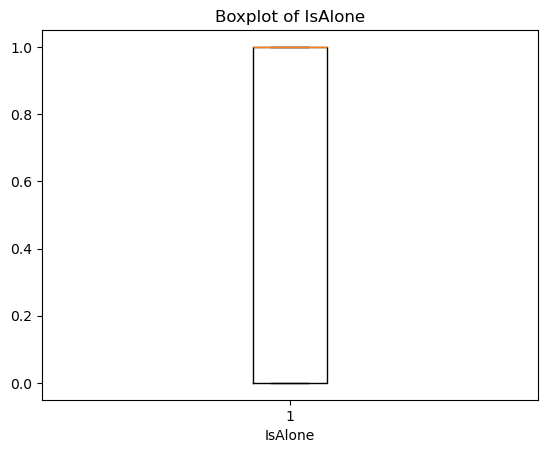

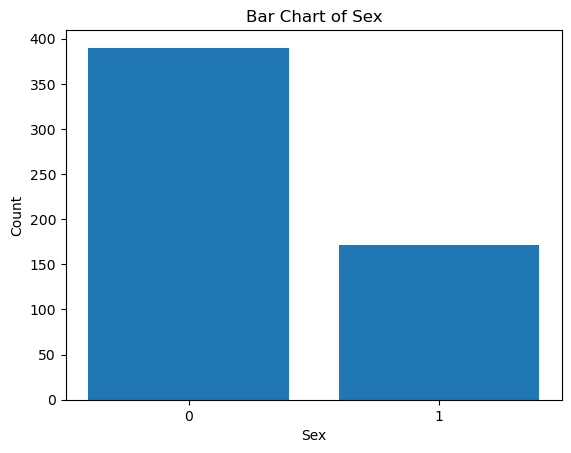

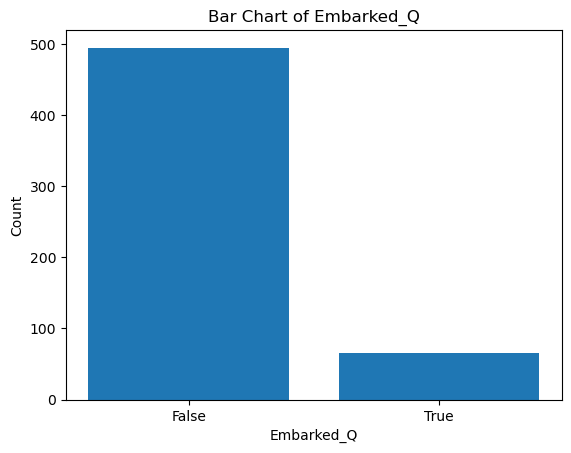

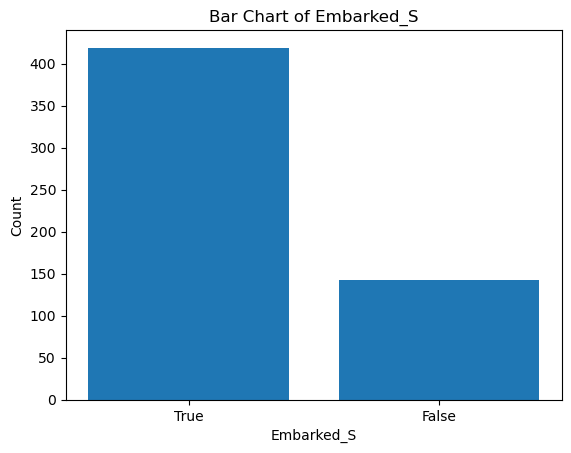

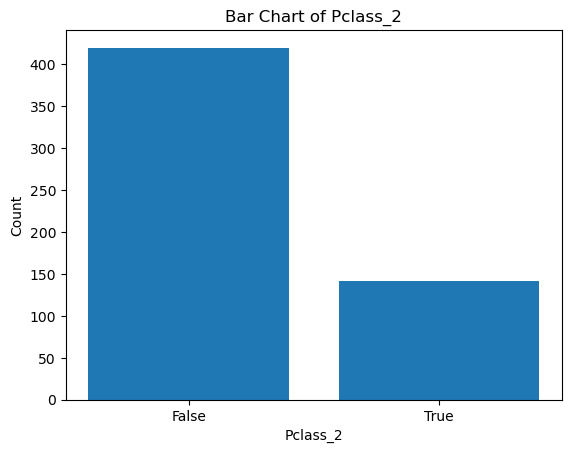

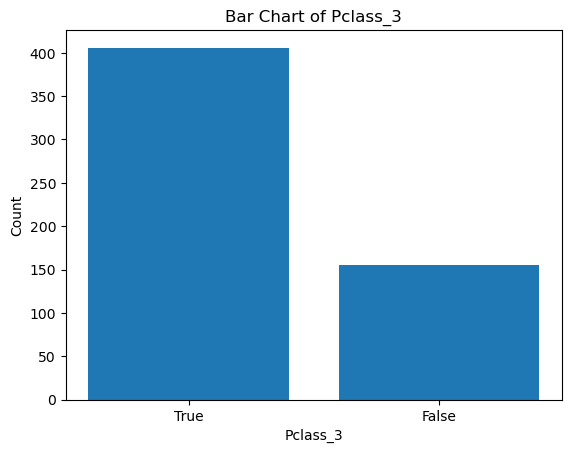

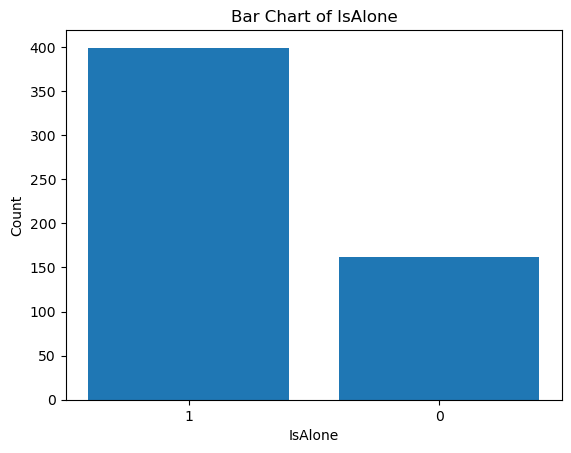

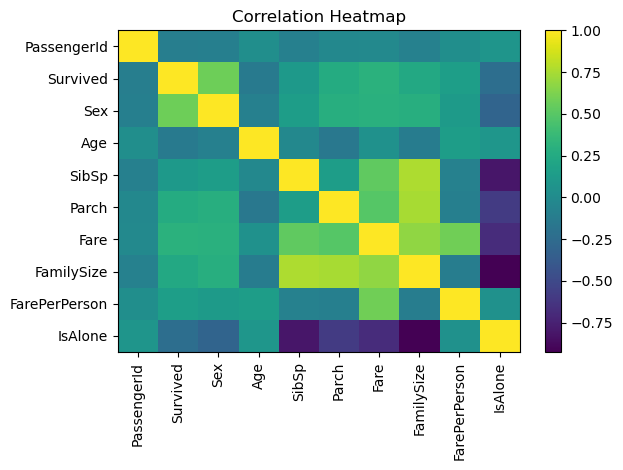

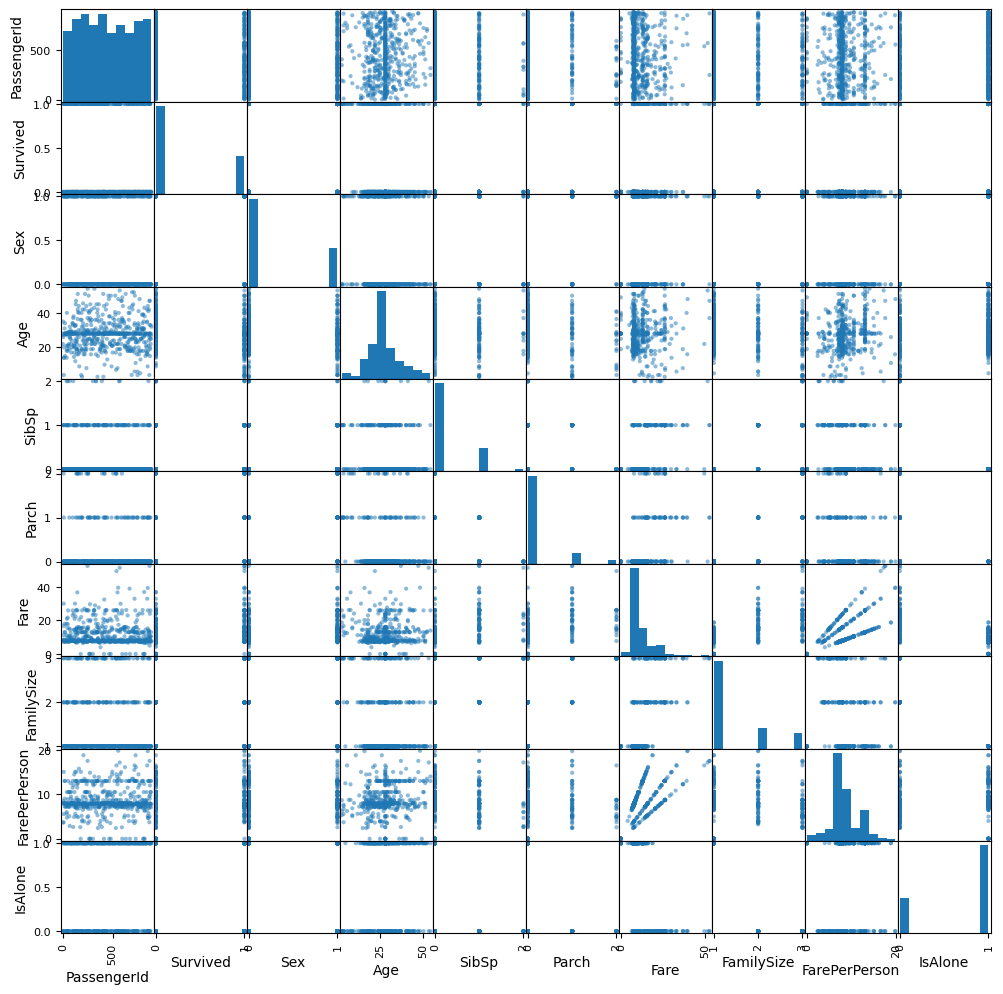

In [18]:

info_df = pd.DataFrame({
    'Non-null': df.count(),
    'Null': df.isnull().sum(),
    'Dtype': df.dtypes.astype(str)
})
print(info_df)

num_desc = df.describe()
print(num_desc)
# 3. All columns descriptive stats
all_desc = df.describe(include='all')
print(all_desc)

for col in ['Sex', 'Embarked_Q', 'Embarked_S', 'Pclass_2', 'Pclass_3', 'IsAlone']:
    vc = df[col].value_counts().reset_index()
    vc.columns = [col, 'Count']
    print(vc)

numeric_cols = df.select_dtypes(include=[np.number]).columns
corr = df[numeric_cols].corr()
print(corr)


numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

#  Histograms
for col in numeric_cols:
    plt.figure()
    plt.hist(df[col].dropna())
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

#  Boxplots
for col in numeric_cols:
    plt.figure()
    plt.boxplot(df[col].dropna())
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
    plt.show()

# Bar charts for categorical
for col in ['Sex', 'Embarked_Q', 'Embarked_S', 'Pclass_2', 'Pclass_3', 'IsAlone']:
    plt.figure()
    counts = df[col].value_counts()
    plt.bar(counts.index.astype(str), counts.values)
    plt.title(f"Bar Chart of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

#  Correlation heatmap
plt.figure()
plt.imshow(corr, aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.index)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

# Scatter matrix of numeric features
scatter_matrix(df[numeric_cols].dropna(), diagonal='hist', figsize=(12, 12))
plt.show()

# LR results

In [24]:
# We define the hyperparameter grid for Logistic Regression
param_grid = {
    'solver':   ['batch', 'sgd', 'mini-batch'],
    'lr':       [0.01, 0.05, 0.1],
    'penalty':  [None, 'l1', 'l2'],
    'C':        [0.1, 1.0, 10.0],
    'batch_size':[16, 32, 64],
    'n_iters':  [1000, 2000, 5000]
}

'''
We do a Grid Search during which we will record runtime and test accuracy in order to choose the most 
performing hyperparmater combination while taking into account the computational constraints, 
notably the wall‐clock training time
'''

results = []
for params in ParameterGrid(param_grid):
    model = LogisticRegressionScratch(
        lr=params['lr'],
        n_iters=params['n_iters'],
        penalty=params['penalty'],
        C=params['C'],
        solver=params['solver'],
        batch_size=params['batch_size'],
        tol=1e-6,
        random_state=42,
        verbose=False
    )

    # We record the time spent for training
    start_time = time.time()
    model.fit(X_train, y_train)
    fit_time = time.time() - start_time

    # We record the time spent for scoring
    start_time = time.time()
    test_accuracy = model.score(X_test, y_test)
    score_time = time.time() - start_time

    # We gather the results obtained
    entry = params.copy()
    entry.update({
        'fit time in seconds': round(fit_time, 4),
        'score time in seconds': round(score_time, 4),
        'test accuracy': round(test_accuracy, 6)
    })
    results.append(entry)

lr_df = pd.DataFrame(results)

# We sort by descending test_accuracy and then by fit_time ascending
lr_df = lr_df.sort_values(
    by=['test accuracy', 'fit time in seconds'],
    ascending=[False, True]
).reset_index(drop=True)


# We will take the best performing hyperparameters combination by accuracy score
idx_best_lr = lr_df['test accuracy'].idxmax()
best_row = lr_df.loc[idx_best]
hyperparam_cols = ['solver', 'lr', 'penalty', 'C', 'batch_size', 'n_iters']
best_lr_params = best_row[hyperparam_cols].to_dict()

lr_df.to_excel(r'C:\Users\Maestro\Desktop\Master DSE\Machine Learning & Statistical Learning\Cesa Bianchi\Data\Titanic\titanic_lr_grid_search_with_timing.xlsx', index=False)

# We Summarize per-hyperparameter

grouped_summaries = {}
for hp in ['solver', 'lr', 'penalty', 'C', 'batch_size', 'n_iters']:
    # (1) Perform grouping and aggregation exactly as before:
    summary = lr_df.groupby(hp).agg({
        'test accuracy': ['mean', 'max'],
        'fit time in seconds':  ['mean']
    })

    renamed_columns = []
    for (lvl0, lvl1) in summary.columns:
        if lvl0 == 'test accuracy' and lvl1 == 'mean':
            renamed_columns.append('mean accuracy')
        elif lvl0 == 'test accuracy' and lvl1 == 'max':
            renamed_columns.append('best accuracy')
        elif lvl0 == 'fit time in seconds' and lvl1 == 'mean':
            renamed_columns.append('mean fit time in sec')
        else:
            renamed_columns.append(f'{lvl0}_{lvl1}')  # fallback
    summary.columns = renamed_columns

    grouped_summaries[col] = summary.reset_index()

# We print the top‐5 hyperparameter configurations
print("Top 5 hyperparameter configurations by test accuracy:\n")
print(lr_df.head(5).to_string(index=False))

# We print summary for each hyperparameter
for hp, df_hp in grouped_summaries.items():
    print(f"\n=== Summary grouped by '{hp}' ===")
    print(df_hp.to_string(index=False))

with pd.ExcelWriter(r'C:\Users\Maestro\Desktop\Master DSE\Machine Learning & Statistical Learning\Cesa Bianchi\Data\Titanic\titanic_lr_hyperparam_summaries.xlsx') as writer:
    for hp, df_hp in grouped_summaries.items():
        df_hp.to_excel(writer, sheet_name=f'{hp}_summary', index=False)

print("\nSummaries have been saved as Excel Files in the corresponding dataset folder.")


Top 5 hyperparameter configurations by test accuracy:

   C  batch_size   lr  n_iters penalty     solver  fit time in seconds  score time in seconds  test accuracy
10.0          64 0.05     1000      l2 mini-batch               0.0863                 0.0000       0.840708
10.0          64 0.10     5000      l2 mini-batch               0.3274                 0.0000       0.840708
10.0          32 0.05     1000      l2 mini-batch               0.0770                 0.0010       0.831858
10.0          64 0.10     1000      l2 mini-batch               0.0807                 0.0008       0.831858
10.0          32 0.10     1000      l2 mini-batch               0.0809                 0.0000       0.831858

=== Summary grouped by 'IsAlone' ===
 n_iters  mean accuracy  best accuracy  mean fit time in sec
    1000       0.733785       0.840708              0.055452
    2000       0.730507       0.831858              0.109065
    5000       0.739830       0.840708              0.248692

Summarie

# SVM results

In [25]:

# We define the hyperparameter grid for SVM
svm_param_grid = {
    'solver':    ['batch', 'sgd', 'mini-batch'],
    'lr':        [0.001, 0.005, 0.01],   # smaller LR for SVM
    'C':         [0.1, 1.0, 10.0],
    'batch_size':[16, 32, 64],
    'n_iters':   [1000, 2000, 5000]
}

'''
We do a Grid Search during which we will record runtime and test accuracy in order to choose the most 
performing hyperparmater combination while taking into account the computational constraints, 
notably the wall‐clock training time
'''

results = []
for params in ParameterGrid(svm_param_grid):
    model = LinearSVMScratch(
        lr=params['lr'],
        C=params['C'],
        n_iters=params['n_iters'],
        solver=params['solver'],
        batch_size=params['batch_size'],
        tol=1e-6,
        random_state=42,
        verbose=False
    )

    # We record the time spent training
    t0 = time.time()
    model.fit(X_train, y_train)
    fit_time = time.time() - t0

    # We record the time spent for scoring
    t1 = time.time()
    acc = model.score(X_test, y_test)
    score_time = time.time() - t1

    # We gather the results obtained
    entry = params.copy()
    entry.update({
        'fit time in seconds': round(fit_time, 4),
        'score time in seconds': round(score_time, 4),
        'test accuracy': round(test_accuracy, 6)
    })
    results.append(entry)

# We convert the results to DataFrame
svm_df = pd.DataFrame(results)

# We sort by descending test_accuracy and then by fit_time ascending
svm_df = svm_df.sort_values(
    by=['test accuracy', 'fit time in seconds'],
    ascending=[False, True]
).reset_index(drop=True)

# We will take the best performing hyperparameters combination by accuracy score
idx_best_svm = svm_df['test accuracy'].idxmax()
best_row = svm_df.loc[idx_best]
hyperparam_cols = ['solver', 'lr', 'C', 'batch_size', 'n_iters']
best_svm_params = best_row[hyperparam_cols].to_dict()

# Save full grid‐search results
svm_df.to_excel(r'C:\Users\Maestro\Desktop\Master DSE\Machine Learning & Statistical Learning\Cesa Bianchi\Data\Titanic\titanic_svm_grid_search_with_timing.xlsx', index=False)

print("Top 5 SVM hyperparameter configurations by test accuracy:\n")
print(svm_df.head(5).to_string(index=False))

grouped_summaries = {}
for hp in ['solver', 'lr', 'C', 'batch_size', 'n_iters']:
    summary = svm_df.groupby(hp).agg({
        'test accuracy': ['mean', 'max'],
        'fit time in seconds':  ['mean']
    })

    renamed_columns = []
    for (lvl0, lvl1) in summary.columns:
        if lvl0 == 'test accuracy' and lvl1 == 'mean':
            renamed_columns.append('mean accuracy')
        elif lvl0 == 'test accuracy' and lvl1 == 'max':
            renamed_columns.append('best accuracy')
        elif lvl0 == 'fit time in seconds' and lvl1 == 'mean':
            renamed_columns.append('mean fit time in sec')
        else:
            renamed_columns.append(f'{lvl0}_{lvl1}')  # fallback
    summary.columns = renamed_columns

    grouped_summaries[hp] = summary.reset_index()
for hp, df_hp in grouped_summaries.items():
    print(f"\n=== Summary grouped by '{hp}' ===")
    print(df_hp.to_string(index=False))

with pd.ExcelWriter(r'C:\Users\Maestro\Desktop\Master DSE\Machine Learning & Statistical Learning\Cesa Bianchi\Data\Titanic\titanic_svm_hyperparam_summaries.xlsx') as writer:
    for hp, df_hp in grouped_summaries.items():
        df_hp.to_excel(writer, sheet_name=f'{hp}_summary', index=False)

print("\nSummaries have been saved as Excel Files in the corresponding dataset folder.")


Top 5 SVM hyperparameter configurations by test accuracy:

   C  batch_size    lr  n_iters solver  fit time in seconds  score time in seconds  test accuracy
10.0          32 0.010     1000    sgd               0.0430                    0.0       0.840708
10.0          64 0.005     1000    sgd               0.0446                    0.0       0.840708
 0.1          64 0.005     1000    sgd               0.0457                    0.0       0.840708
10.0          16 0.005     1000    sgd               0.0459                    0.0       0.840708
 0.1          32 0.005     1000    sgd               0.0466                    0.0       0.840708

=== Summary grouped by 'solver' ===
    solver  mean accuracy  best accuracy  mean fit time in sec
     batch       0.840708       0.840708              0.221544
mini-batch       0.840708       0.840708              0.215895
       sgd       0.840708       0.840708              0.142940

=== Summary grouped by 'lr' ===
   lr  mean accuracy  best accu

# RF Results 

In [26]:

# We define the hyperparameter grid for the Random Forest
rf_param_grid = {
    'n_estimators':    [10, 50, 100],
    'max_depth':       [None, 5, 10],
    'min_samples_leaf':[1, 2, 5],
    'max_features':    [None, 'sqrt', 'log2']  # We willl interpret None as sqrt(n_features)
}


'''
We do a Grid Search during which we will record runtime and test accuracy in order to choose the most 
performing hyperparmater combination while taking into account the computational constraints, 
notably the wall‐clock training time
'''

results = []
n_features = X_train.shape[1]

for params in ParameterGrid(rf_param_grid):
    # Interpret 'max_features' parameter
    if params['max_features'] is None:
        mf = None
    elif params['max_features'] == 'sqrt':
        mf = int(np.sqrt(n_features))
    elif params['max_features'] == 'log2':
        mf = int(np.log2(n_features))
    else:
        # If it's a number, but in this grid it isn't; so we can skip
        mf = None

    # Instantiate RandomForestScratch with these hyperparameters
    model = RandomForestScratch(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        min_samples_leaf=params['min_samples_leaf'],
        max_features=mf,
        random_state=42,
        verbose=False
    )

    # We record the time spent training
    t0 = time.time()
    model.fit(X_train, y_train)
    fit_time = time.time() - t0

    # We record the time spent for scoring
    t1 = time.time()
    test_acc = model.score(X_test, y_test)
    score_time = time.time() - t1

    # Record results
    entry = params.copy()
    entry.update({
        'fit time in seconds': round(fit_time, 4),
        'score_time_sec': round(score_time, 4),
        'test accuracy': round(test_acc, 6)
    })
    results.append(entry)

# Compile results into DataFrame, sort, and save
rf_df = pd.DataFrame(results)
rf_df = rf_df.sort_values(
    by=['test accuracy', 'fit time in seconds'],
    ascending=[False, True]
).reset_index(drop=True)

# We will take the best performing hyperparameters combination by accuracy score
idx_best_rf = rf_df['test accuracy'].idxmax()
best_row = rf_df.loc[idx_best]
hyperparam_cols = ['n_estimators', 'max_depth', 'min_samples_leaf', 'max_features']
best_rf_params = best_row[hyperparam_cols].to_dict()

rf_df.to_excel(r'C:\Users\Maestro\Desktop\Master DSE\Machine Learning & Statistical Learning\Cesa Bianchi\Data\Titanic\titanic_rf_grid_search_with_timing.xlsx', index=False)

# We print the top‐5 performing configurations
print("Top 5 Random Forest hyperparameter configurations by test accuracy:\n")
print(rf_df.head(5).to_string(index=False))

#  Summaries per hyperparameter
grouped_summaries = {}
for hp in ['n_estimators', 'max_depth', 'min_samples_leaf', 'max_features']:
    summary = rf_df.groupby(hp).agg({
        'test accuracy': ['mean', 'max'],
        'fit time in seconds':  ['mean']
    })

    renamed_columns = []
    for (lvl0, lvl1) in summary.columns:
        if lvl0 == 'test accuracy' and lvl1 == 'mean':
            renamed_columns.append('mean accuracy')
        elif lvl0 == 'test accuracy' and lvl1 == 'max':
            renamed_columns.append('best accuracy')
        elif lvl0 == 'fit time in seconds' and lvl1 == 'mean':
            renamed_columns.append('mean fit time in sec')
        else:
            renamed_columns.append(f'{lvl0}_{lvl1}')  # fallback
    summary.columns = renamed_columns

    grouped_summaries[hp] = summary.reset_index()

# Print grouped summaries
for hp, df_hp in grouped_summaries.items():
    print(f"\n Summary grouped by '{hp}' ")
    print(df_hp.to_string(index=False))

#  Save summaries to Excel (one sheet per hyperparameter)
with pd.ExcelWriter(r'C:\Users\Maestro\Desktop\Master DSE\Machine Learning & Statistical Learning\Cesa Bianchi\Data\Titanic\titanic_rf_hyperparam_summaries.xlsx') as writer:
    for hp, df_hp in grouped_summaries.items():
        df_hp.to_excel(writer, sheet_name=f'{hp}_summary', index=False)

print("\nSummaries have been saved as Excel Files in the corresponding dataset folder.")


Top 5 Random Forest hyperparameter configurations by test accuracy:

 max_depth max_features  min_samples_leaf  n_estimators  fit time in seconds  score_time_sec  test accuracy
      10.0         sqrt                 1           100               3.6441          0.0196       0.725664
      10.0         None                 1           100               3.6490          0.0197       0.725664
      10.0         log2                 1           100               3.6893          0.0204       0.725664
       NaN         None                 2            10               0.4843          0.0030       0.716814
       NaN         log2                 2            10               0.5012          0.0030       0.716814

 Summary grouped by 'n_estimators' 
 n_estimators  mean accuracy  best accuracy  mean fit time in sec
           10       0.676499       0.716814              0.376626
           50       0.693216       0.716814              1.710522
          100       0.701082       0.725664     

# Final Ditaviz and comparisons : 

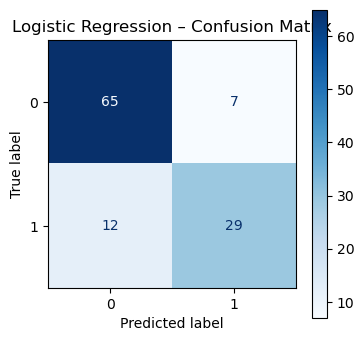

=== Classification Report: Logistic Regression ===
              precision    recall  f1-score   support

           0     0.8442    0.9028    0.8725        72
           1     0.8056    0.7073    0.7532        41

    accuracy                         0.8319       113
   macro avg     0.8249    0.8050    0.8129       113
weighted avg     0.8302    0.8319    0.8292       113





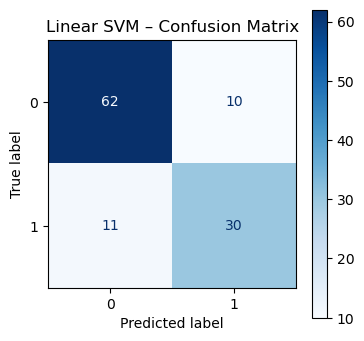

=== Classification Report: Linear SVM ===
              precision    recall  f1-score   support

           0     0.8493    0.8611    0.8552        72
           1     0.7500    0.7317    0.7407        41

    accuracy                         0.8142       113
   macro avg     0.7997    0.7964    0.7980       113
weighted avg     0.8133    0.8142    0.8137       113





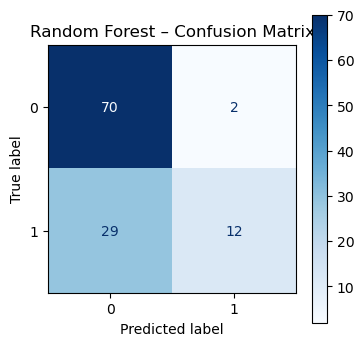

=== Classification Report: Random Forest ===
              precision    recall  f1-score   support

           0     0.7071    0.9722    0.8187        72
           1     0.8571    0.2927    0.4364        41

    accuracy                         0.7257       113
   macro avg     0.7821    0.6325    0.6275       113
weighted avg     0.7615    0.7257    0.6800       113





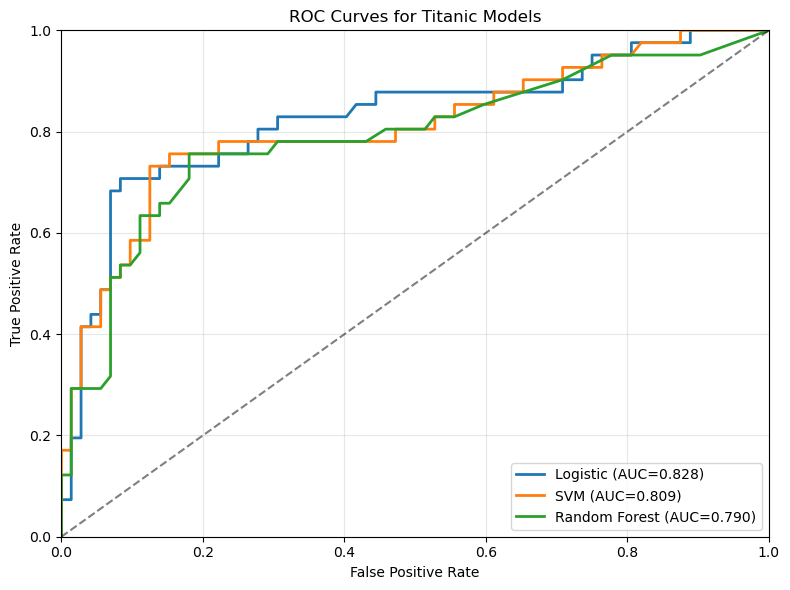

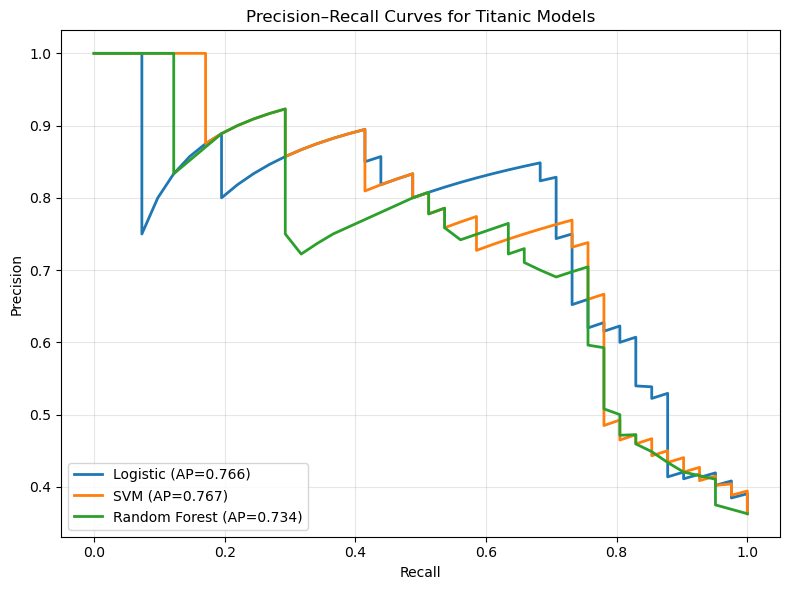


=== Summary: Test Accuracy & Fit Time on Titanic Dataset ===

              Model  Test Accuracy  Fit Time (s)
Logistic Regression       0.831858        0.0863
         Linear SVM       0.814159        0.0430
      Random Forest       0.725664        3.6441


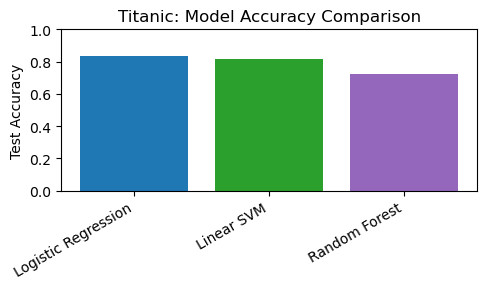

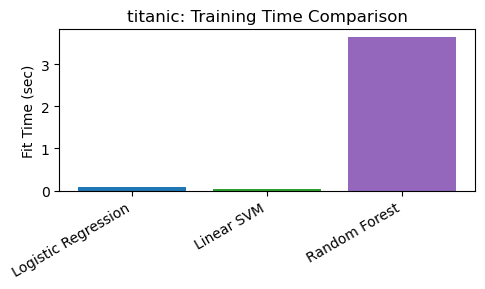

In [33]:
best_lr_model = LogisticRegressionScratch(**best_lr_params)
best_lr_model.fit(X_train, y_train)

best_svm_model = LinearSVMScratch(**best_svm_params)
best_svm_model.fit(X_train, y_train)

mf_raw = best_rf_params['max_features']
if mf_raw is None:
    mf_int = None
elif mf_raw == 'sqrt':
    mf_int = int(np.sqrt(n_features))
elif mf_raw == 'log2':
    mf_int = int(np.log2(n_features))
else:
    mf_int = int(mf_raw)

best_rf_model = RandomForestScratch(
    n_estimators=best_rf_params['n_estimators'],
    max_depth=best_rf_params['max_depth'],
    min_samples_leaf=best_rf_params['min_samples_leaf'],
    max_features=mf_int,
    random_state=42,
    verbose=False
)
best_rf_model.fit(X_train, y_train)


def plot_confusion_and_report(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    fig, ax = plt.subplots(figsize=(4, 4))
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title(f"{title} – Confusion Matrix")
    plt.show()

    print(f"=== Classification Report: {title} ===")
    print(classification_report(y_test, y_pred, digits=4))
    print("\n" + "="*60 + "\n")


plot_confusion_and_report(best_lr_model, X_test, y_test, "Logistic Regression")
plot_confusion_and_report(best_svm_model, X_test, y_test, "Linear SVM")
plot_confusion_and_report(best_rf_model, X_test, y_test, "Random Forest")


# ROC Curves & AUC
plt.figure(figsize=(8, 6))

# LR
lr_proba = best_lr_model.predict_proba(X_test)
lr_scores = lr_proba if lr_proba.ndim == 1 else lr_proba[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_scores)
auc_lr = auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr, label=f"Logistic (AUC={auc_lr:.3f})", linewidth=2)

# SVM
try:
    svm_scores = best_svm_model.decision_function(X_test)
except AttributeError:
    svm_proba = best_svm_model.predict_proba(X_test)
    svm_scores = svm_proba[:, 1]
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_scores)
auc_svm = auc(fpr_svm, tpr_svm)
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC={auc_svm:.3f})", linewidth=2)

# RF
rf_proba = best_rf_model.predict_proba(X_test)
rf_scores = rf_proba if rf_proba.ndim == 1 else rf_proba[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_scores)
auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC={auc_rf:.3f})", linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Titanic Models")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# Precision–Recall Curves & AP
plt.figure(figsize=(8, 6))

# LR
prec_lr, rec_lr, _ = precision_recall_curve(y_test, lr_scores)
ap_lr = average_precision_score(y_test, lr_scores)
plt.plot(rec_lr, prec_lr, label=f"Logistic (AP={ap_lr:.3f})", linewidth=2)

# SVM
prec_svm, rec_svm, _ = precision_recall_curve(y_test, svm_scores)
ap_svm = average_precision_score(y_test, svm_scores)
plt.plot(rec_svm, prec_svm, label=f"SVM (AP={ap_svm:.3f})", linewidth=2)

# RF
prec_rf, rec_rf, _ = precision_recall_curve(y_test, rf_scores)
ap_rf = average_precision_score(y_test, rf_scores)
plt.plot(rec_rf, prec_rf, label=f"Random Forest (AP={ap_rf:.3f})", linewidth=2)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves for Titanic Models")
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



# 6.8) Combined Summary of Test Accuracy & Fit Time
best_lr_acc  = best_lr_model.score(X_test, y_test)
best_svm_acc = best_svm_model.score(X_test, y_test)
best_rf_acc  = best_rf_model.score(X_test, y_test)

# Assume you recorded best fit times from grid search above:
idx_best_lr = lr_df['test accuracy'].idxmax()
idx_best_svm = svm_df['test accuracy'].idxmax()
idx_best_rf = rf_df['test accuracy'].idxmax()


best_lr_time  = lr_df.iloc[idx_best_lr]['fit time in seconds']
best_svm_time = svm_df.iloc[idx_best_svm]['fit time in seconds']
best_rf_time  = rf_df.iloc[idx_best_rf]['fit time in seconds']

summary_df = pd.DataFrame({
    'Model':       ['Logistic Regression', 'Linear SVM', 'Random Forest'],
    'Test Accuracy':[best_lr_acc, best_svm_acc, best_rf_acc],
    'Fit Time (s)': [best_lr_time, best_svm_time, best_rf_time]
})

print("\n=== Summary: Test Accuracy & Fit Time on Titanic Dataset ===\n")
print(summary_df.to_string(index=False))

plt.figure(figsize=(5, 3))
plt.bar(summary_df['Model'], summary_df['Test Accuracy'], color=['#1f77b4','#2ca02c','#9467bd'])
plt.ylabel("Test Accuracy")
plt.title("Titanic: Model Accuracy Comparison")
plt.ylim(0, 1)
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 3))
plt.bar(summary_df['Model'], summary_df['Fit Time (s)'], color=['#1f77b4','#2ca02c','#9467bd'])
plt.ylabel("Fit Time (sec)")
plt.title("titanic: Training Time Comparison")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

# End for titanic

# Income Dataset

# Descriptive Data


 Numeric Descriptive Statistics 

                age  education-num  capital-gain  capital-loss  hours-per-week
count  32560.000000   32560.000000  32560.000000  32560.000000    32560.000000
mean      38.581849      10.080682   1077.681941     87.238790       40.437469
std       13.640593       2.572760   7385.403083    402.795459       12.347618
min       17.000000       1.000000      0.000000      0.000000        1.000000
25%       28.000000       9.000000      0.000000      0.000000       40.000000
50%       37.000000      10.000000      0.000000      0.000000       40.000000
75%       48.000000      12.000000      0.000000      0.000000       45.000000
max       90.000000      16.000000  99999.000000   4356.000000       99.000000

 All‐Columns Descriptive Statistics  

                 age workclass  fnlwgt education  education-num  \
count   32560.000000     32561   32561     32561   32560.000000   
unique           NaN        10   21648        17            NaN   
top          

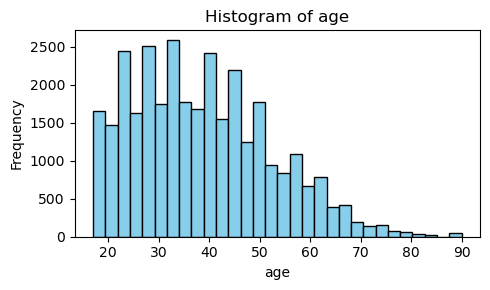

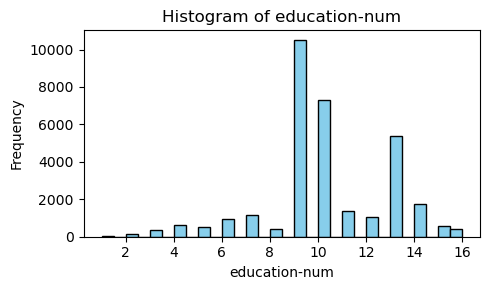

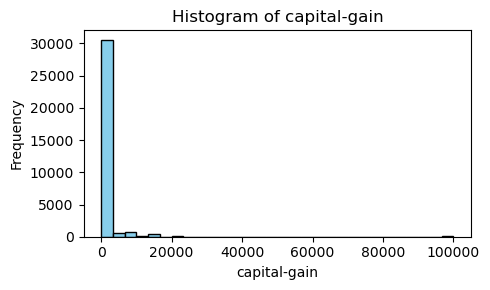

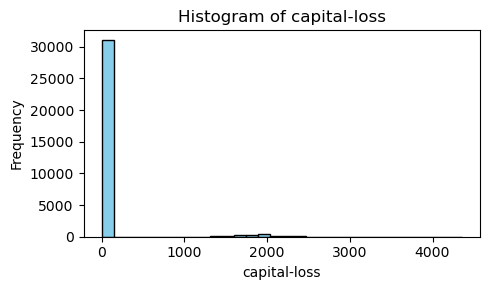

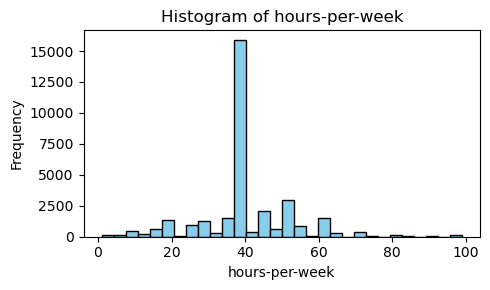

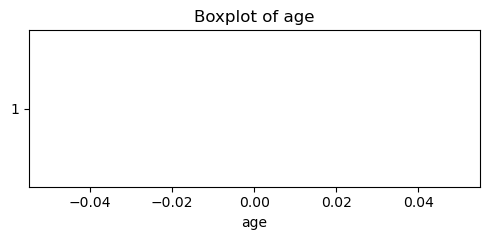

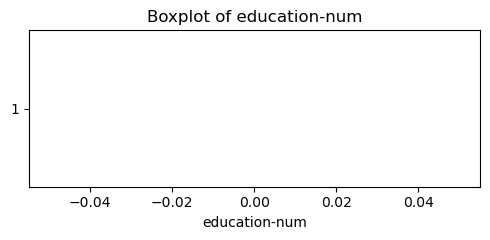

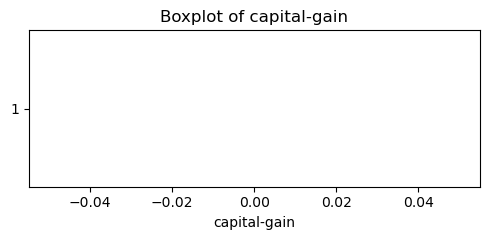

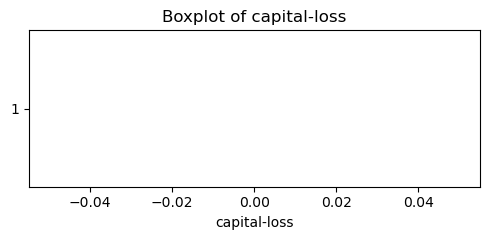

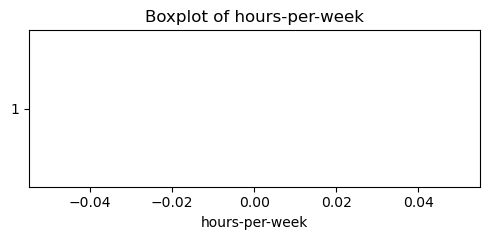

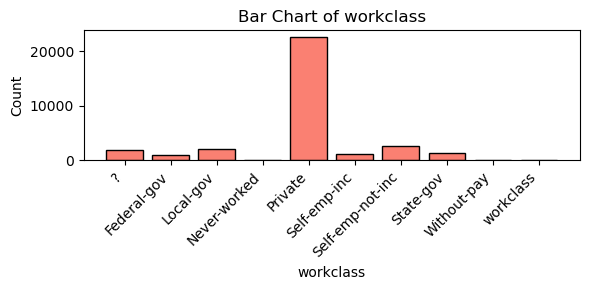

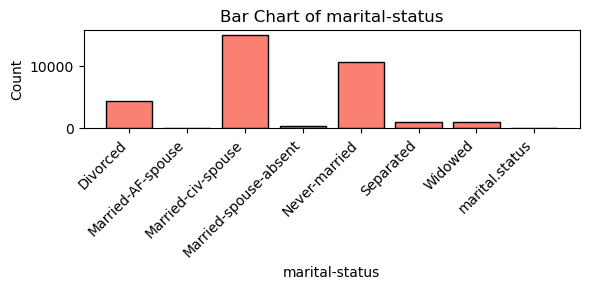

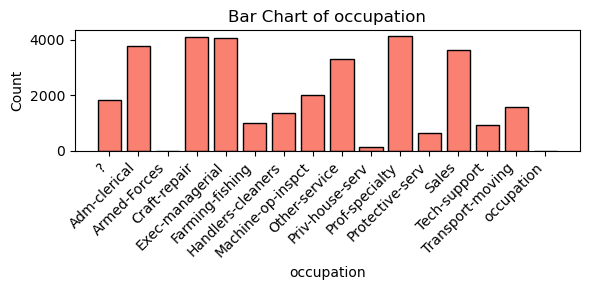

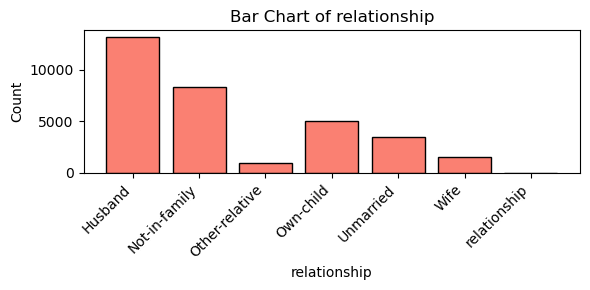

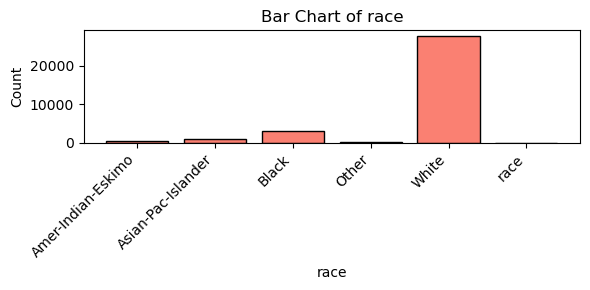

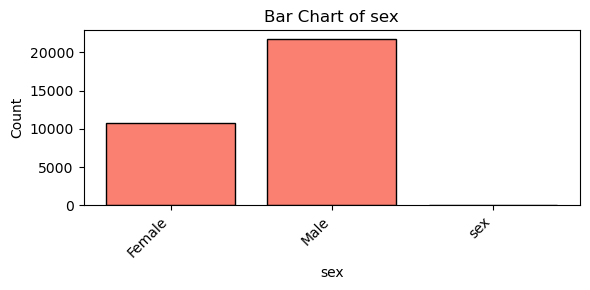

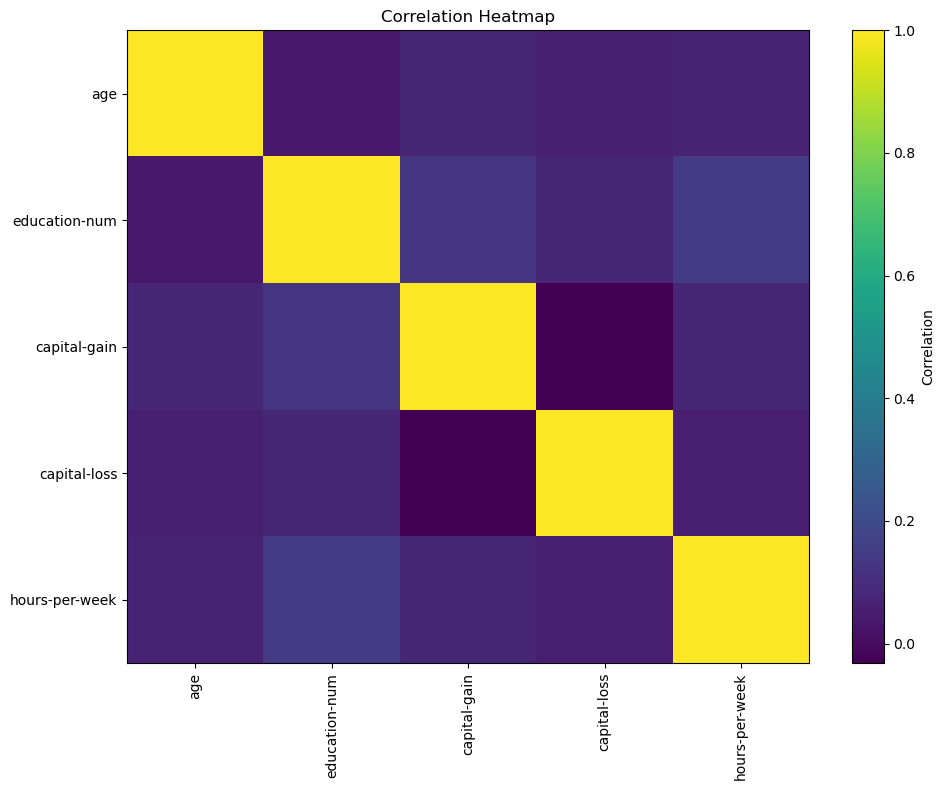

<Figure size 1000x1000 with 0 Axes>

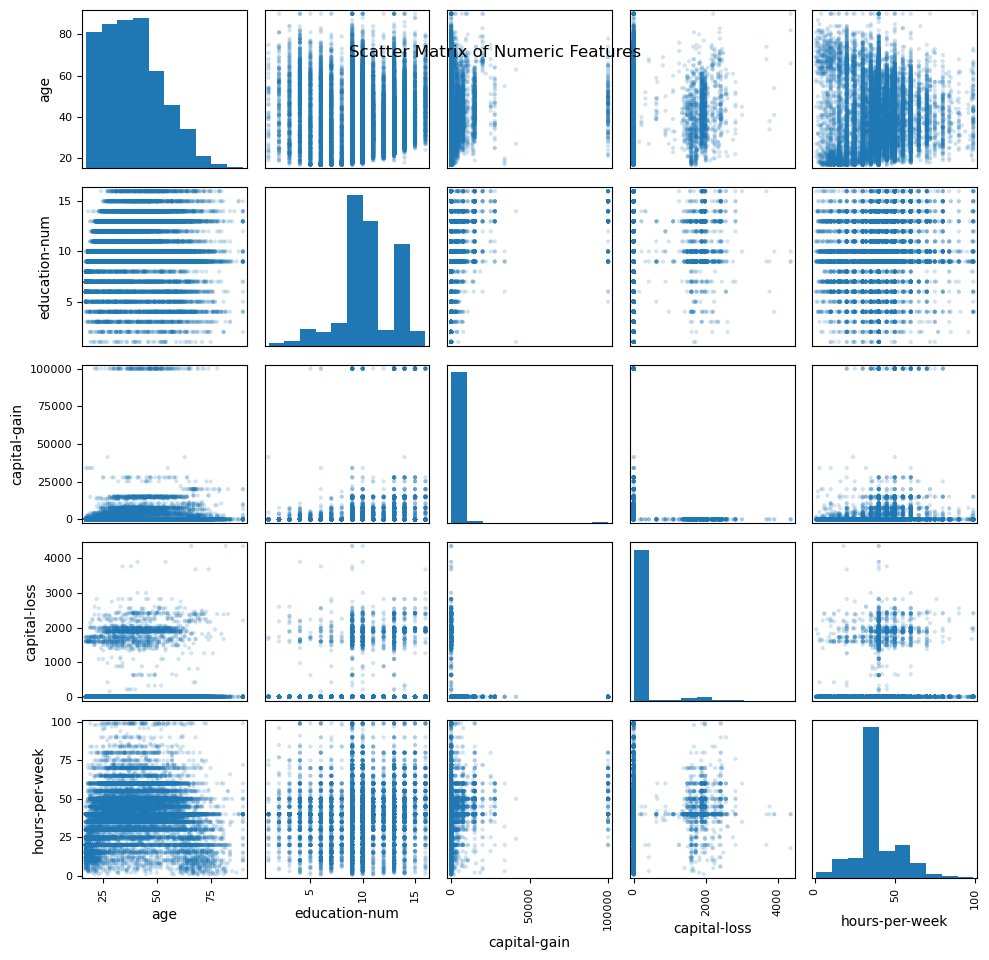

In [34]:

raw_df = pd.read_csv(
    r'C:\Users\Maestro\Desktop\Master DSE\Machine Learning & Statistical Learning\Cesa Bianchi\Data\Income\adult_data.csv',
    header=None,
    skipinitialspace=True,
    names=[
        'age', 'workclass', 'fnlwgt', 'education', 'education-num',
        'marital-status', 'occupation', 'relationship', 'race', 'sex',
        'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
    ]
)

df=raw_df.copy()

# We identify which columns should be numeric vs. categorical
numeric_cols = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical_cols = [
    'workclass', 'marital-status', 'occupation',
    'relationship', 'race', 'sex', 'native-country'
]

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print("\n Numeric Descriptive Statistics \n")
num_desc = df[numeric_cols].describe()
print(num_desc)


print("\n All‐Columns Descriptive Statistics  \n")
all_desc = df.describe(include='all')
print(all_desc)


print("\n Value Counts: Original Categorical Fields \n")
for col in ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']:
    vc = raw_df[col].value_counts().rename_axis(col).reset_index(name='Count')
    print(f"--- {col} ---")
    print(vc.to_string(index=False))
    print()


print("\n Correlation Matrix \n")
corr = df[numeric_cols].corr()
print(corr)


#  Histograms for each numeric column
for col in numeric_cols:
    plt.figure(figsize=(5, 3))
    plt.hist(df[col], bins=30, color='skyblue', edgecolor='black')
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

#  Boxplots for each numeric column
for col in numeric_cols:
    plt.figure(figsize=(5, 2.5))
    plt.boxplot(df[col], vert=False)
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

#  Bar charts for the original categorical fields
for col in ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex']:
    plt.figure(figsize=(6, 3))
    counts = raw_df[col].value_counts().sort_index()
    plt.bar(counts.index.astype(str), counts.values, color='salmon', edgecolor='black')
    plt.title(f"Bar Chart of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

#  Correlation heatmap (cleaned & one-hot)
plt.figure(figsize=(10, 8))
im = plt.imshow(corr, aspect='auto', cmap='viridis')
plt.colorbar(im, label='Correlation')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

# Scatter matrix among the numeric columns (cleaned df)
plt.figure(figsize=(10, 10))
scatter_matrix(df[numeric_cols], diagonal='hist', alpha=0.2, figsize=(10, 10))
plt.suptitle("Scatter Matrix of Numeric Features", y=0.92)
plt.tight_layout()
plt.show()




# Data preprocessing

In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].str.strip()

df.replace('?', np.nan, inplace=True)

df = df.dropna(subset=['workclass', 'occupation', 'native-country']).reset_index(drop=True)


df.drop(columns=['fnlwgt', 'education'], inplace=True)

df['income'] = df['income'].map({'<=50K': 0, '>50K': 1})
if df['income'].isna().any():
    df = df.dropna(subset=['income']).reset_index(drop=True)


num_imputer = SimpleImputer(strategy='median')
df[numeric_cols] = num_imputer.fit_transform(df[numeric_cols])


for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower) & (df[col] <= upper)].reset_index(drop=True)

df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
df = df.astype(float)

FEATURES = [c for c in df.columns if c != 'income']
X_df = df[FEATURES]
y = df['income'].values

# 14) Convert X_df → NumPy array
X = X_df.values

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)
y_train = y_train.astype(np.int64)
y_test  = y_test.astype(np.int64)


all_feature_names = X_df.columns.tolist()
numeric_indices = [all_feature_names.index(col) for col in numeric_cols]

scaler = StandardScaler()
X_train[:, numeric_indices] = scaler.fit_transform(X_train[:, numeric_indices])
X_test[:, numeric_indices]  = scaler.transform(X_test[:, numeric_indices])


# Final Descrptive Statistics

=== Cleaned & One‐Hot‐Encoded DataFrame Info ===

                                Non‐null  Null    Dtype
age                                19064     0  float64
education-num                      19064     0  float64
capital-gain                       19064     0  float64
capital-loss                       19064     0  float64
hours-per-week                     19064     0  float64
...                                  ...   ...      ...
native-country_Thailand            19064     0  float64
native-country_Trinadad&Tobago     19064     0  float64
native-country_United-States       19064     0  float64
native-country_Vietnam             19064     0  float64
native-country_Yugoslavia          19064     0  float64

[80 rows x 3 columns]

=== Numeric Descriptive Statistics (cleaned df) ===

                age  education-num  capital-gain  capital-loss  hours-per-week
count  19064.000000   19064.000000       19064.0       19064.0    19064.000000
mean      38.120961      10.064152         

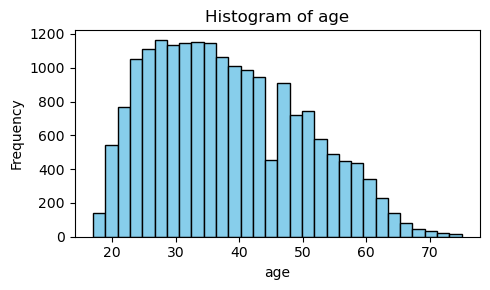

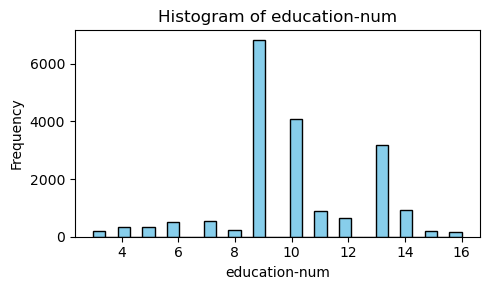

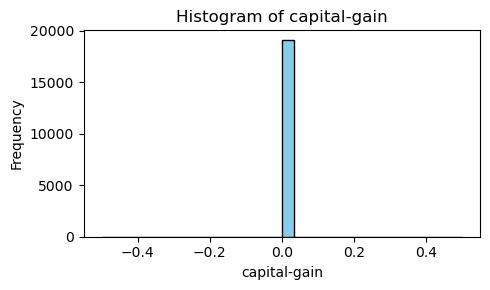

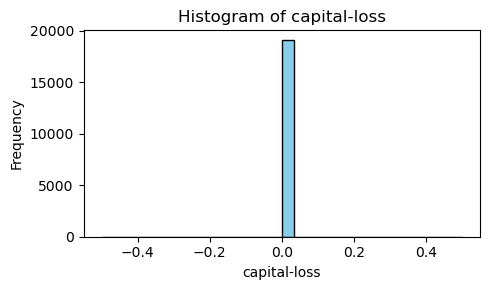

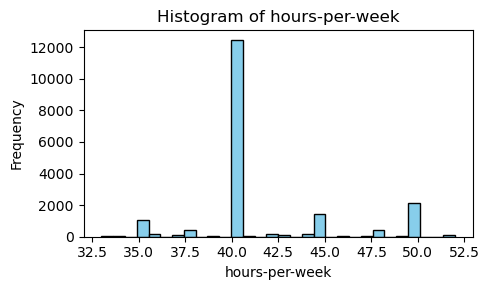

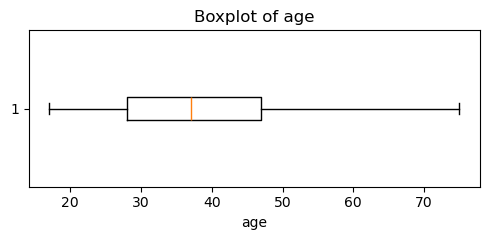

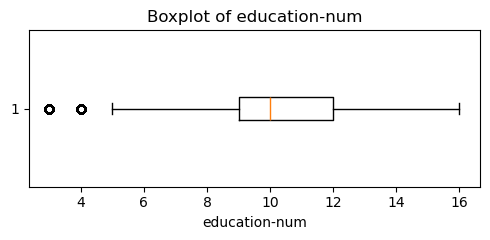

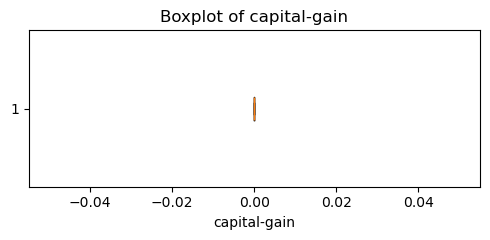

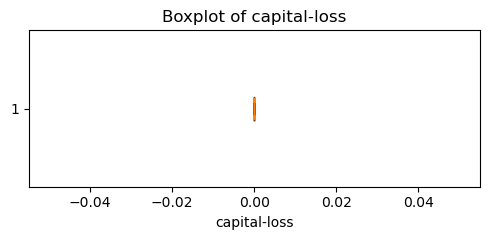

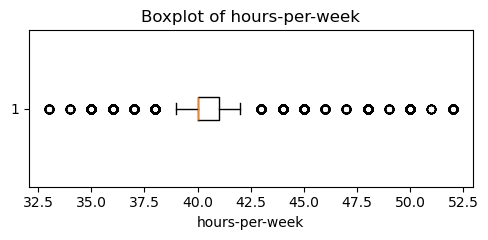

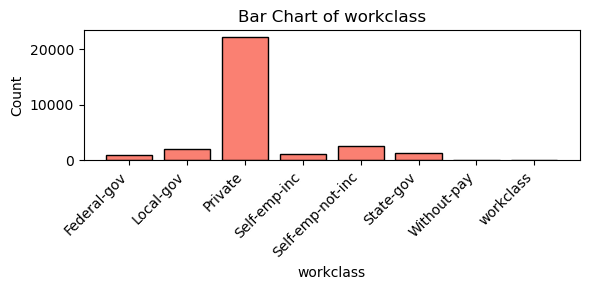

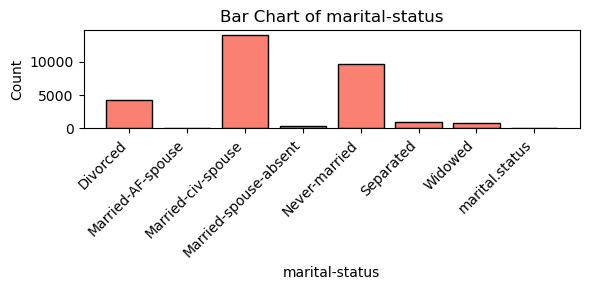

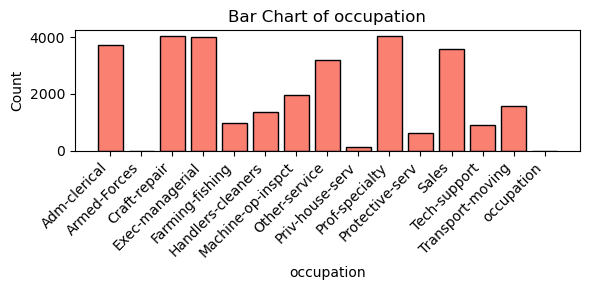

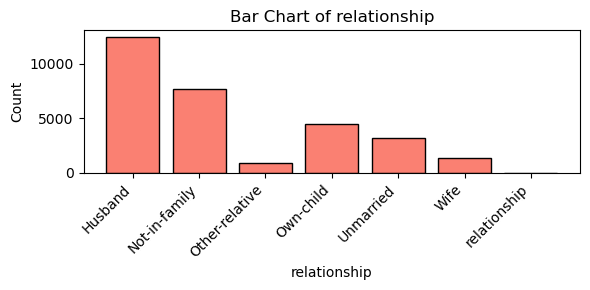

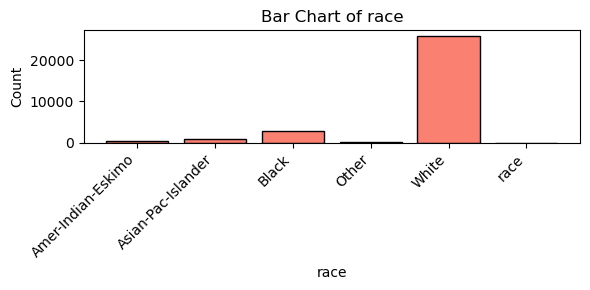

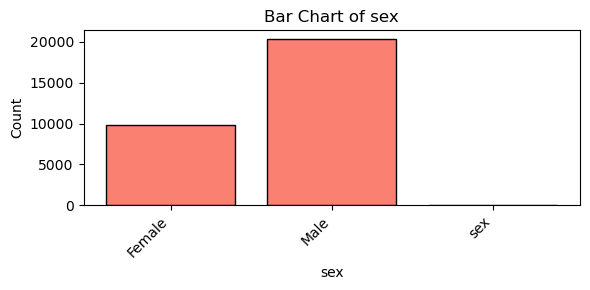

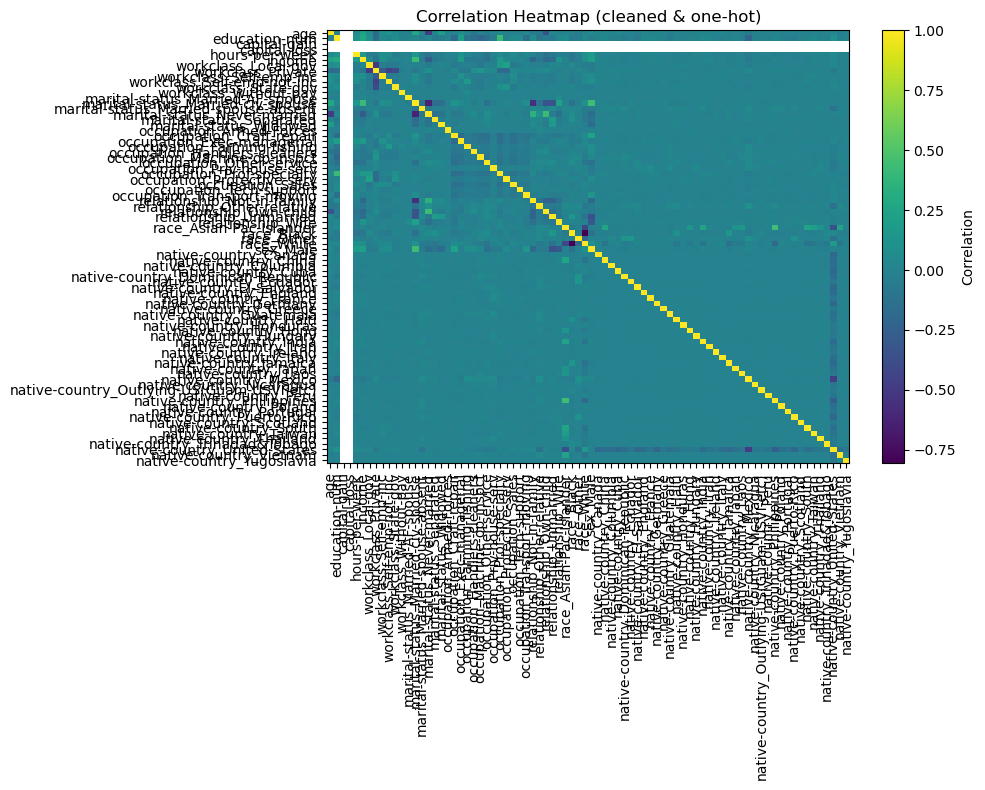

<Figure size 1000x1000 with 0 Axes>

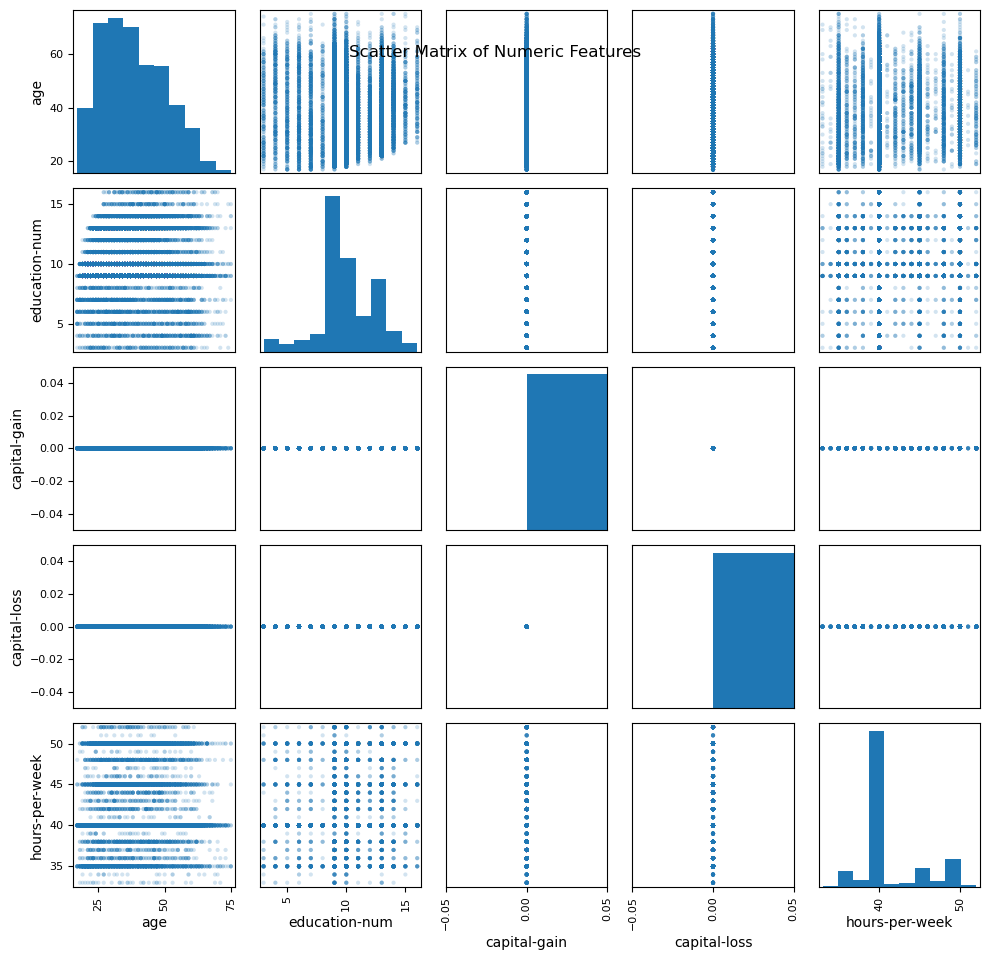

In [36]:

raw_df = pd.read_csv(
    r'C:\Users\Maestro\Desktop\Master DSE\Machine Learning & Statistical Learning\Cesa Bianchi\Data\Income\adult_data.csv',
    header=None,
    skipinitialspace=True,
    names=[
        'age', 'workclass', 'fnlwgt', 'education', 'education-num',
        'marital-status', 'occupation', 'relationship', 'race', 'sex',
        'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
    ]
)

for col in raw_df.select_dtypes(include=['object']).columns:
    raw_df[col] = raw_df[col].str.strip()
raw_df.replace('?', np.nan, inplace=True)
raw_df.dropna(subset=['workclass', 'occupation', 'native-country'], inplace=True)


print("=== Cleaned & One‐Hot‐Encoded DataFrame Info ===\n")
info_df = pd.DataFrame({
    'Non‐null': df.count(),
    'Null': df.isnull().sum(),
    'Dtype': df.dtypes.astype(str)
})
print(info_df)


print("\n=== Numeric Descriptive Statistics (cleaned df) ===\n")
num_desc = df[numeric_cols].describe()
print(num_desc)


print("\n=== All‐Columns Descriptive Statistics (cleaned df) ===\n")
all_desc = df.describe(include='all')
print(all_desc)


print("\n=== Value Counts: Original Categorical Fields ===\n")
for col in ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']:
    vc = raw_df[col].value_counts().rename_axis(col).reset_index(name='Count')
    print(f"--- {col} ---")
    print(vc.to_string(index=False))
    print()


print("\n=== Correlation Matrix (cleaned df) ===\n")
corr = df.corr()
print(corr)



#  Histograms for each numeric column
for col in numeric_cols:
    plt.figure(figsize=(5, 3))
    plt.hist(df[col], bins=30, color='skyblue', edgecolor='black')
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

#  Boxplots for each numeric column
for col in numeric_cols:
    plt.figure(figsize=(5, 2.5))
    plt.boxplot(df[col], vert=False)
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

#  Bar charts for the original categorical fields
for col in ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex']:
    plt.figure(figsize=(6, 3))
    counts = raw_df[col].value_counts().sort_index()
    plt.bar(counts.index.astype(str), counts.values, color='salmon', edgecolor='black')
    plt.title(f"Bar Chart of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

#  Correlation heatmap (cleaned & one-hot)
plt.figure(figsize=(10, 8))
im = plt.imshow(corr, aspect='auto', cmap='viridis')
plt.colorbar(im, label='Correlation')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation Heatmap (cleaned & one-hot)")
plt.tight_layout()
plt.show()

#  Scatter matrix among the numeric columns (cleaned df)
plt.figure(figsize=(10, 10))
scatter_matrix(df[numeric_cols], diagonal='hist', alpha=0.2, figsize=(10, 10))
plt.suptitle("Scatter Matrix of Numeric Features", y=0.92)
plt.tight_layout()
plt.show()


# LR results

In [37]:

# We define the hyperparameter grid for Logistic Regression
param_grid = {
    'solver':   ['batch', 'sgd', 'mini-batch'],
    'lr':       [0.01, 0.05, 0.1],
    'penalty':  [None, 'l1', 'l2'],
    'C':        [0.1, 1.0, 10.0],
    'batch_size':[32, 64],
    'n_iters':  [500]
}

'''
We do a Grid Search during which we will record runtime and test accuracy in order to choose the most 
performing hyperparmater combination while taking into account the computational constraints, 
notably the wall‐clock training time
'''

results = []
for params in ParameterGrid(param_grid):
    model = LogisticRegressionScratch(
        lr=params['lr'],
        n_iters=params['n_iters'],
        penalty=params['penalty'],
        C=params['C'],
        solver=params['solver'],
        batch_size=params['batch_size'],
        tol=1e-6,
        random_state=42,
        verbose=False
    )

    # We record the time spent for training
    start_time = time.time()
    model.fit(X_train, y_train)
    fit_time = time.time() - start_time

    # We record the time spent for scoring
    start_time = time.time()
    test_accuracy = model.score(X_test, y_test)
    score_time = time.time() - start_time

    # We gather the results obtained
    entry = params.copy()
    entry.update({
        'fit time in seconds': round(fit_time, 4),
        'score time in seconds': round(score_time, 4),
        'test accuracy': round(test_accuracy, 6)
    })
    results.append(entry)

# Convert to DataFrame
lr_df = pd.DataFrame(results)

# Sort by descending test_accuracy (and then by fit_time ascending)
lr_df = lr_df.sort_values(
    by=['test accuracy', 'fit time in seconds'],
    ascending=[False, True]
).reset_index(drop=True)


# We will take the best performing hyperparameters combination by accuracy score
idx_best = lr_df['test accuracy'].idxmax()
best_row = lr_df.loc[idx_best]
hyperparam_cols = ['solver', 'lr', 'penalty', 'C', 'batch_size', 'n_iters']
best_lr_params = best_row[hyperparam_cols].to_dict()

# Save the full table to disk
lr_df.to_excel(r'C:\Users\Maestro\Desktop\Master DSE\Machine Learning & Statistical Learning\Cesa Bianchi\Data\Income\Income_lr_grid_search_with_timing.xlsx', index=False)

grouped_summaries = {}
for hp in ['solver', 'lr', 'penalty', 'C', 'batch_size', 'n_iters']:
    summary = lr_df.groupby(hp).agg({
        'test accuracy': ['mean', 'max'],
        'fit time in seconds':  ['mean']
    })

    renamed_columns = []
    for (lvl0, lvl1) in summary.columns:
        if lvl0 == 'test accuracy' and lvl1 == 'mean':
            renamed_columns.append('mean accuracy')
        elif lvl0 == 'test accuracy' and lvl1 == 'max':
            renamed_columns.append('best accuracy')
        elif lvl0 == 'fit time in seconds' and lvl1 == 'mean':
            renamed_columns.append('mean fit time in sec')
        else:
            renamed_columns.append(f'{lvl0}_{lvl1}')  # fallback
    summary.columns = renamed_columns

    grouped_summaries[col] = summary.reset_index()

print("Top 5 hyperparameter configurations by test accuracy:\n")
print(lr_df.head(5).to_string(index=False))

for hp, df_hp in grouped_summaries.items():
    print(f"\n=== Summary grouped by '{hp}' ===")
    print(df_hp.to_string(index=False))

with pd.ExcelWriter(r'C:\Users\Maestro\Desktop\Master DSE\Machine Learning & Statistical Learning\Cesa Bianchi\Data\Income\Income_lr_hyperparam_summaries.xlsx') as writer:
    for hp, df_hp in grouped_summaries.items():
        df_hp.to_excel(writer, sheet_name=f'{hp}_summary', index=False)

print("\nSummaries have been saved as Excel Files in the corresponding dataset folder.")


Top 5 hyperparameter configurations by test accuracy:

   C  batch_size  lr  n_iters penalty solver  fit time in seconds  score time in seconds  test accuracy
 0.1          32 0.1      500    None  batch               2.0435                 0.0010       0.837398
10.0          64 0.1      500    None  batch               2.3787                 0.0009       0.837398
 0.1          64 0.1      500    None  batch               2.3905                 0.0010       0.837398
10.0          32 0.1      500    None  batch               2.4062                 0.0012       0.837398
 1.0          64 0.1      500    None  batch               2.4696                 0.0009       0.837398

=== Summary grouped by 'sex' ===
 n_iters  mean accuracy  best accuracy  mean fit time in sec
     500       0.801159       0.837398              0.916056

Summaries have been saved as Excel Files in the corresponding dataset folder.


# SVM Results

In [38]:

# We define the hyperparameter grid for SVM
svm_param_grid = {
    'solver':    ['batch', 'sgd', 'mini-batch'],
    'lr':        [0.001, 0.005, 0.01],   # smaller LR for SVM
    'C':         [0.1, 1.0, 10.0],
    'batch_size':[32, 64],
    'n_iters':   [500]
}


'''
We do a Grid Search during which we will record runtime and test accuracy in order to choose the most 
performing hyperparmater combination while taking into account the computational constraints, 
notably the wall‐clock training time
'''

results = []
for params in ParameterGrid(svm_param_grid):
    model = LinearSVMScratch(
        lr=params['lr'],
        C=params['C'],
        n_iters=params['n_iters'],
        solver=params['solver'],
        batch_size=params['batch_size'],
        tol=1e-6,
        random_state=42,
        verbose=False
    )

    # We record the time spent training
    t0 = time.time()
    model.fit(X_train, y_train)
    fit_time = time.time() - t0

    # We record the time spent for scoring
    t1 = time.time()
    acc = model.score(X_test, y_test)
    score_time = time.time() - t1

    # We gather the results obtained
    entry = params.copy()
    entry.update({
        'fit time in seconds': round(fit_time, 4),
        'score time in seconds': round(score_time, 4),
        'test accuracy': round(test_accuracy, 6)
    })
    results.append(entry)

# We convert the results to DataFrame
svm_df = pd.DataFrame(results)

# We sort by descending test_accuracy and then by fit_time ascending
svm_df = svm_df.sort_values(
    by=['test accuracy', 'fit time in seconds'],
    ascending=[False, True]
).reset_index(drop=True)

# We will take the best performing hyperparameters combination by accuracy score
idx_best = svm_df['test accuracy'].idxmax()
best_row = svm_df.loc[idx_best]
hyperparam_cols = ['solver', 'lr', 'C', 'batch_size', 'n_iters']
best_svm_params = best_row[hyperparam_cols].to_dict()

svm_df.to_excel(r'C:\Users\Maestro\Desktop\Master DSE\Machine Learning & Statistical Learning\Cesa Bianchi\Data\Income\Income_svm_grid_search_with_timing.xlsx', index=False)

print("Top 5 SVM hyperparameter configurations by test accuracy:\n")
print(svm_df.head(5).to_string(index=False))

grouped_summaries = {}
for hp in ['solver', 'lr', 'C', 'batch_size', 'n_iters']:
    summary = svm_df.groupby(hp).agg({
        'test accuracy': ['mean', 'max'],
        'fit time in seconds':  ['mean']
    })

    renamed_columns = []
    for (lvl0, lvl1) in summary.columns:
        if lvl0 == 'test accuracy' and lvl1 == 'mean':
            renamed_columns.append('mean accuracy')
        elif lvl0 == 'test accuracy' and lvl1 == 'max':
            renamed_columns.append('best accuracy')
        elif lvl0 == 'fit time in seconds' and lvl1 == 'mean':
            renamed_columns.append('mean fit time in sec')
        else:
            renamed_columns.append(f'{lvl0}_{lvl1}')  # fallback
    summary.columns = renamed_columns

    grouped_summaries[hp] = summary.reset_index()

for hp, df_hp in grouped_summaries.items():
    print(f"\n=== Summary grouped by '{hp}' ===")
    print(df_hp.to_string(index=False))

with pd.ExcelWriter(r'C:\Users\Maestro\Desktop\Master DSE\Machine Learning & Statistical Learning\Cesa Bianchi\Data\Income\Income_svm_hyperparam_summaries.xlsx') as writer:
    for hp, df_hp in grouped_summaries.items():
        df_hp.to_excel(writer, sheet_name=f'{hp}_summary', index=False)

print("\nSummaries have been saved as Excel Files in the corresponding dataset folder.")


Top 5 SVM hyperparameter configurations by test accuracy:

   C  batch_size    lr  n_iters solver  fit time in seconds  score time in seconds  test accuracy
10.0          64 0.010      500    sgd               0.0291                 0.0011       0.815631
10.0          64 0.001      500    sgd               0.0306                 0.0010       0.815631
 0.1          64 0.001      500    sgd               0.0310                 0.0020       0.815631
 0.1          64 0.005      500    sgd               0.0314                 0.0017       0.815631
10.0          64 0.005      500    sgd               0.0320                 0.0010       0.815631

=== Summary grouped by 'solver' ===
    solver  mean accuracy  best accuracy  mean fit time in sec
     batch       0.815631       0.815631              3.696428
mini-batch       0.815631       0.815631              0.271061
       sgd       0.815631       0.815631              0.033706

=== Summary grouped by 'lr' ===
   lr  mean accuracy  best accu

# RF Results

In [39]:

# We define the hyperparameter grid for the Random Forest
rf_param_grid = {
    'n_estimators':    [10, 50],
    'max_depth':       [None, 5, 10],
    'min_samples_leaf':[1, 2, 5],
    'max_features':    [None, 'sqrt', 'log2']  # We willl interpret None as sqrt(n_features)
}


'''
We do a Grid Search during which we will record runtime and test accuracy in order to choose the most 
performing hyperparmater combination while taking into account the computational constraints, 
notably the wall‐clock training time
'''

results = []
n_features = X_train.shape[1]

for params in ParameterGrid(rf_param_grid):
    # Interpret 'max_features' parameter
    if params['max_features'] is None:
        mf = None
    elif params['max_features'] == 'sqrt':
        mf = int(np.sqrt(n_features))
    elif params['max_features'] == 'log2':
        mf = int(np.log2(n_features))
    else:
        # If it's a number, but in this grid it isn't; so we can skip
        mf = None

    # Instantiate RandomForestScratch with these hyperparameters
    model = RandomForestScratch(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        min_samples_leaf=params['min_samples_leaf'],
        max_features=mf,
        random_state=42,
        verbose=False
    )

    # We record the time spent training
    t0 = time.time()
    model.fit(X_train, y_train)
    fit_time = time.time() - t0

    # We record the time spent for scoring
    t1 = time.time()
    test_acc = model.score(X_test, y_test)
    score_time = time.time() - t1

    # Record results
    entry = params.copy()
    entry.update({
        'fit time in seconds': round(fit_time, 4),
        'score_time_sec': round(score_time, 4),
        'test accuracy': round(test_acc, 6)
    })
    results.append(entry)

# We compile results into DataFrame, sort, and save
rf_df = pd.DataFrame(results)
rf_df = rf_df.sort_values(
    by=['test accuracy', 'fit time in seconds'],
    ascending=[False, True]
).reset_index(drop=True)

# We will take the best performing hyperparameters combination by accuracy score
idx_best = rf_df['test accuracy'].idxmax()
best_row = rf_df.loc[idx_best]
hyperparam_cols = ['n_estimators', 'max_depth', 'min_samples_leaf', 'max_features']
best_rf_params = best_row[hyperparam_cols].to_dict()

rf_df.to_excel(r'C:\Users\Maestro\Desktop\Master DSE\Machine Learning & Statistical Learning\Cesa Bianchi\Data\Income\Income_rf_grid_search_with_timing.xlsx', index=False)

print("Top 5 Random Forest hyperparameter configurations by test accuracy:\n")
print(rf_df.head(5).to_string(index=False))


grouped_summaries = {}
for hp in ['n_estimators', 'max_depth', 'min_samples_leaf', 'max_features']:
    summary = rf_df.groupby(hp).agg({
        'test accuracy': ['mean', 'max'],
        'fit time in seconds':  ['mean']
    })

    renamed_columns = []
    for (lvl0, lvl1) in summary.columns:
        if lvl0 == 'test accuracy' and lvl1 == 'mean':
            renamed_columns.append('mean accuracy')
        elif lvl0 == 'test accuracy' and lvl1 == 'max':
            renamed_columns.append('best accuracy')
        elif lvl0 == 'fit time in seconds' and lvl1 == 'mean':
            renamed_columns.append('mean fit time in sec')
        else:
            renamed_columns.append(f'{lvl0}_{lvl1}')  # fallback
    summary.columns = renamed_columns

    grouped_summaries[hp] = summary.reset_index()

for hp, df_hp in grouped_summaries.items():
    print(f"\n Summary grouped by '{hp}' ")
    print(df_hp.to_string(index=False))

with pd.ExcelWriter(r'C:\Users\Maestro\Desktop\Master DSE\Machine Learning & Statistical Learning\Cesa Bianchi\Data\Income\Income_rf_hyperparam_summaries.xlsx') as writer:
    for hp, df_hp in grouped_summaries.items():
        df_hp.to_excel(writer, sheet_name=f'{hp}_summary', index=False)

print("\nSummaries have been saved as Excel Files in the corresponding dataset folder.")


Top 5 Random Forest hyperparameter configurations by test accuracy:

 max_depth max_features  min_samples_leaf  n_estimators  fit time in seconds  score_time_sec  test accuracy
       5.0         log2                 5            10               1.4079          0.0583       0.789142
       5.0         log2                 2            10               1.4242          0.0623       0.789142
       5.0         log2                 1            10               1.5418          0.0633       0.789142
      10.0         log2                 5            10               1.7907          0.0638       0.789142
       5.0         sqrt                 5            10               1.7954          0.0616       0.789142

 Summary grouped by 'n_estimators' 
 n_estimators  mean accuracy  best accuracy  mean fit time in sec
           10       0.789142       0.789142              2.413507
           50       0.789142       0.789142             12.281100

 Summary grouped by 'max_depth' 
 max_depth  me

# Final DataViz and comparisons

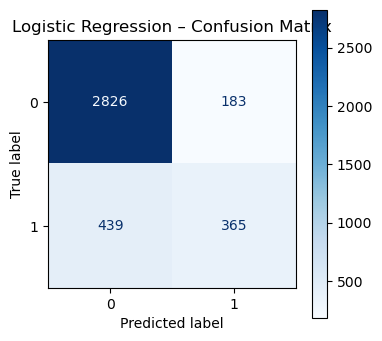

=== Classification Report: Logistic Regression ===
              precision    recall  f1-score   support

           0     0.8655    0.9392    0.9009      3009
           1     0.6661    0.4540    0.5399       804

    accuracy                         0.8369      3813
   macro avg     0.7658    0.6966    0.7204      3813
weighted avg     0.8235    0.8369    0.8248      3813





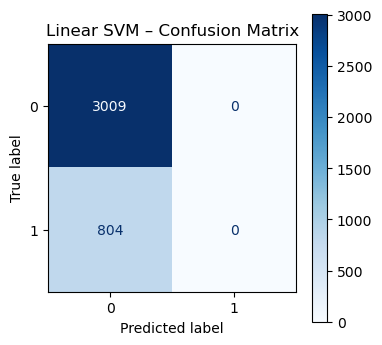

=== Classification Report: Linear SVM ===
              precision    recall  f1-score   support

           0     0.7891    1.0000    0.8821      3009
           1     0.0000    0.0000    0.0000       804

    accuracy                         0.7891      3813
   macro avg     0.3946    0.5000    0.4411      3813
weighted avg     0.6227    0.7891    0.6961      3813





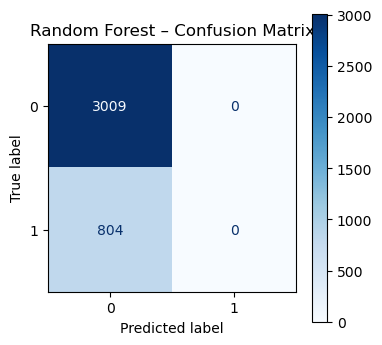

=== Classification Report: Random Forest ===
              precision    recall  f1-score   support

           0     0.7891    1.0000    0.8821      3009
           1     0.0000    0.0000    0.0000       804

    accuracy                         0.7891      3813
   macro avg     0.3946    0.5000    0.4411      3813
weighted avg     0.6227    0.7891    0.6961      3813





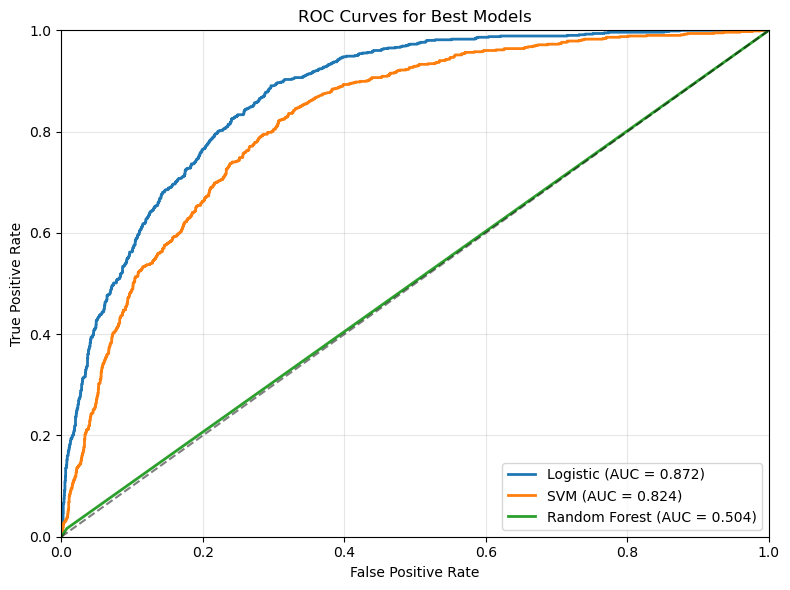

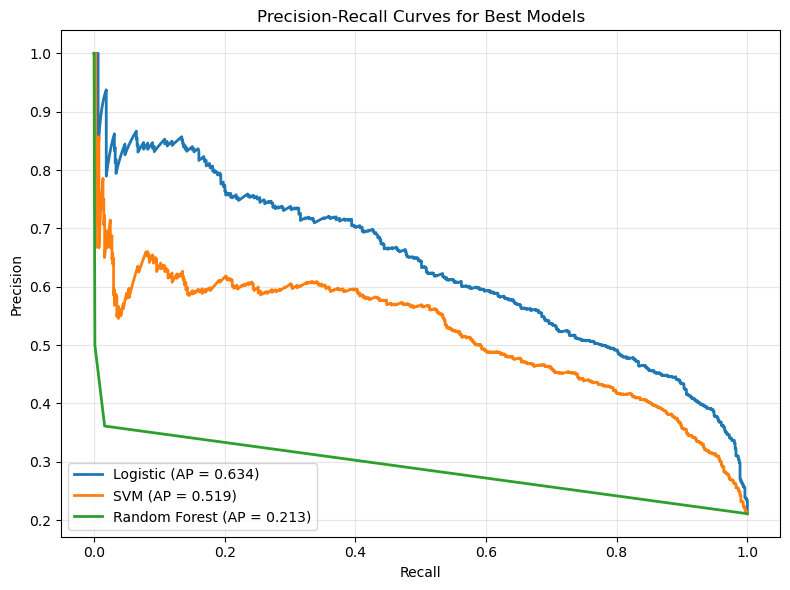


=== Summary: Test Accuracy & Fit Time on Income Datset ===

              Model  Test Accuracy  Fit Time (s)
Logistic Regression       0.836874        2.0435
         Linear SVM       0.789142        0.0291
      Random Forest       0.789142        3.7383


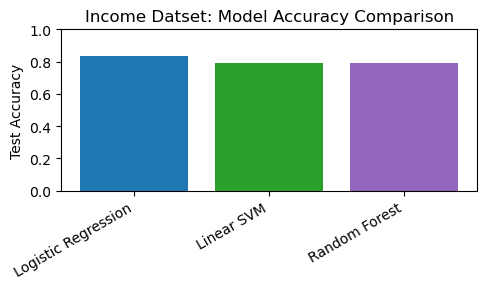

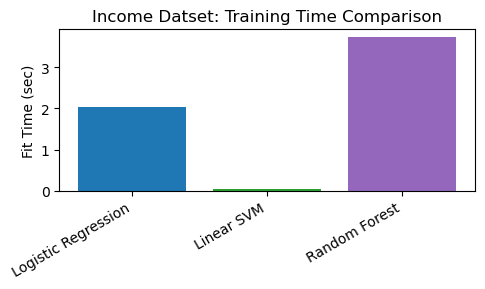

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
)



# Logistic Regression
best_lr_model = LogisticRegressionScratch(**best_lr_params)
best_lr_model.fit(X_train, y_train)

# Linear SVM
best_svm_model = LinearSVMScratch(**best_svm_params)
best_svm_model.fit(X_train, y_train)

# Random Forest: first convert 'max_features' string to integer if needed
#    (the grid saved 'max_features' as "None", "sqrt", or "log2")
n_features = X_train.shape[1]
mf_raw = best_rf_params['max_features']
if mf_raw is None:
    mf_int = None
elif mf_raw == 'sqrt':
    mf_int = int(np.sqrt(n_features))
elif mf_raw == 'log2':
    mf_int = int(np.log2(n_features))
else:
    # in case grid‐search directly stored an integer
    mf_int = int(mf_raw)

best_rf_params_converted = {
    'n_estimators':     best_rf_params['n_estimators'],
    'max_depth':        best_rf_params['max_depth'],
    'min_samples_leaf': best_rf_params['min_samples_leaf'],
    'max_features':     mf_int,
    'random_state':     42,
    'verbose':          False
}
best_rf_model = RandomForestScratch(**best_rf_params_converted)
best_rf_model.fit(X_train, y_train)



def plot_confusion_and_report(model, X_test, y_test, title):
    """
    Given a trained model, test‐set, and a title,
    plot the confusion matrix and print classification report.
    """
    # Predict labels
    y_pred = model.predict(X_test)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(figsize=(4, 4))
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title(f"{title} – Confusion Matrix")
    plt.show()

    # Classification report
    print(f"=== Classification Report: {title} ===")
    print(classification_report(y_test, y_pred, digits=4))
    print("\n" + "="*60 + "\n")


# Plot for Logistic Regression
plot_confusion_and_report(best_lr_model, X_test, y_test, "Logistic Regression")

# Plot for Linear SVM
plot_confusion_and_report(best_svm_model, X_test, y_test, "Linear SVM")

# Plot for Random Forest
plot_confusion_and_report(best_rf_model, X_test, y_test, "Random Forest")



# We plot ROC curves & compute AUC

plt.figure(figsize=(8, 6))


# Logistic Regression
lr_proba = best_lr_model.predict_proba(X_test)  
if lr_proba.ndim == 1 or lr_proba.shape[1] == 1:
    lr_scores = lr_proba
else:
    lr_scores = lr_proba[:, 1]

fpr_lr, tpr_lr, _    = roc_curve(y_test, lr_scores)
auc_lr = auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr, label=f"Logistic (AUC = {auc_lr:.3f})", linewidth=2)

# Linear SVM
try:
    svm_scores = best_svm_model.decision_function(X_test)  # if implemented
except AttributeError:
    svm_proba = best_svm_model.predict_proba(X_test)
    svm_scores = svm_proba[:, 1]

fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_scores)
auc_svm = auc(fpr_svm, tpr_svm)
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {auc_svm:.3f})", linewidth=2)

# Random Forest
rf_proba = best_rf_model.predict_proba(X_test)
# If shape is (n_samples, 2), take column 1
if rf_proba.ndim > 1 and rf_proba.shape[1] == 2:
    rf_scores = rf_proba[:, 1]
else:
    rf_scores = rf_proba

fpr_rf, tpr_rf, _   = roc_curve(y_test, rf_scores)
auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.3f})", linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)  # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Best Models")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# We Plot Precision‐Recall curves & print Average Precision (AP)
plt.figure(figsize=(8, 6))

prec_lr, rec_lr, _ = precision_recall_curve(y_test, lr_scores)
ap_lr = average_precision_score(y_test, lr_scores)
plt.plot(rec_lr, prec_lr, label=f"Logistic (AP = {ap_lr:.3f})", linewidth=2)

prec_svm, rec_svm, _ = precision_recall_curve(y_test, svm_scores)
ap_svm = average_precision_score(y_test, svm_scores)
plt.plot(rec_svm, prec_svm, label=f"SVM (AP = {ap_svm:.3f})", linewidth=2)

prec_rf, rec_rf, _ = precision_recall_curve(y_test, rf_scores)
ap_rf = average_precision_score(y_test, rf_scores)
plt.plot(rec_rf, prec_rf, label=f"Random Forest (AP = {ap_rf:.3f})", linewidth=2)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision‐Recall Curves for Best Models")
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

best_lr_acc  = best_lr_model.score(X_test, y_test)
best_svm_acc = best_svm_model.score(X_test, y_test)
best_rf_acc  = best_rf_model.score(X_test, y_test)

best_lr_time  = lr_df.iloc[idx_best_lr]['fit time in seconds']
best_svm_time = svm_df.iloc[idx_best_svm]['fit time in seconds']
best_rf_time  = results_df.iloc[idx_best_rf]['fit time in seconds']

summary_df = pd.DataFrame({
    'Model':       ['Logistic Regression', 'Linear SVM', 'Random Forest'],
    'Test Accuracy':[best_lr_acc, best_svm_acc, best_rf_acc],
    'Fit Time (s)': [best_lr_time, best_svm_time, best_rf_time]
})

print("\n=== Summary: Test Accuracy & Fit Time on Income Datset ===\n")
print(summary_df.to_string(index=False))

plt.figure(figsize=(5, 3))
plt.bar(summary_df['Model'], summary_df['Test Accuracy'], color=['#1f77b4','#2ca02c','#9467bd'])
plt.ylabel("Test Accuracy")
plt.title("Income Datset: Model Accuracy Comparison")
plt.ylim(0, 1)
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 3))
plt.bar(summary_df['Model'], summary_df['Fit Time (s)'], color=['#1f77b4','#2ca02c','#9467bd'])
plt.ylabel("Fit Time (sec)")
plt.title("Income Datset: Training Time Comparison")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()



# Iris dataset 

# Descriptive Statistics

In [43]:
# Load the Iris dataset

path = r'C:\Users\Maestro\Desktop\Master DSE\Machine Learning & Statistical Learning\Cesa Bianchi\Data\Iris\Iris.csv'  
df = pd.read_csv(path)
df

Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm  \
0      1            5.1           3.5            1.4           0.2   
1      2            4.9           3.0            1.4           0.2   
2      3            4.7           3.2            1.3           0.2   
3      4            4.6           3.1            1.5           0.2   
4      5            5.0           3.6            1.4           0.2   
..   ...            ...           ...            ...           ...   
145  146            6.7           3.0            5.2           2.3   
146  147            6.3           2.5            5.0           1.9   
147  148            6.5           3.0            5.2           2.0   
148  149            6.2           3.4            5.4           2.3   
149  150            5.9           3.0            5.1           1.8   

            Species  
0       Iris-setosa  
1       Iris-setosa  
2       Iris-setosa  
3       Iris-setosa  
4       Iris-setosa  
..              ...  
145  Iris-virginica  
146  Iris-virginica  
147  Iris-virginica  
148  Iris-virginica  
149  Iris-virginica  

[150 rows x 6 columns]

In [44]:
df

Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm  \
0      1            5.1           3.5            1.4           0.2   
1      2            4.9           3.0            1.4           0.2   
2      3            4.7           3.2            1.3           0.2   
3      4            4.6           3.1            1.5           0.2   
4      5            5.0           3.6            1.4           0.2   
..   ...            ...           ...            ...           ...   
145  146            6.7           3.0            5.2           2.3   
146  147            6.3           2.5            5.0           1.9   
147  148            6.5           3.0            5.2           2.0   
148  149            6.2           3.4            5.4           2.3   
149  150            5.9           3.0            5.1           1.8   

            Species  
0       Iris-setosa  
1       Iris-setosa  
2       Iris-setosa  
3       Iris-setosa  
4       Iris-setosa  
..              ...  
145  Iris-virginica  
146  Iris-virginica  
147  Iris-virginica  
148  Iris-virginica  
149  Iris-virginica  

[150 rows x 6 columns]


=== Numeric Descriptive Statistics ===

       SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
count     150.000000    150.000000     150.000000    150.000000
mean        5.843333      3.054000       3.758667      1.198667
std         0.828066      0.433594       1.764420      0.763161
min         4.300000      2.000000       1.000000      0.100000
25%         5.100000      2.800000       1.600000      0.300000
50%         5.800000      3.000000       4.350000      1.300000
75%         6.400000      3.300000       5.100000      1.800000
max         7.900000      4.400000       6.900000      2.500000

=== All‐Columns Descriptive Statistics ===

        SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
count      150.000000    150.000000     150.000000    150.000000          150
unique            NaN           NaN            NaN           NaN            3
top               NaN           NaN            NaN           NaN  Iris-setosa
freq              NaN     

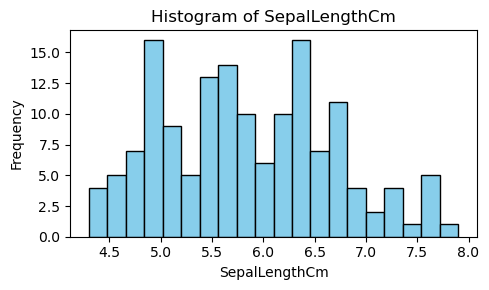

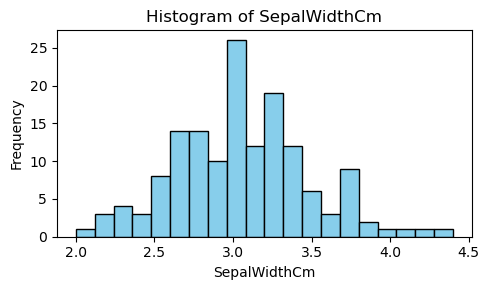

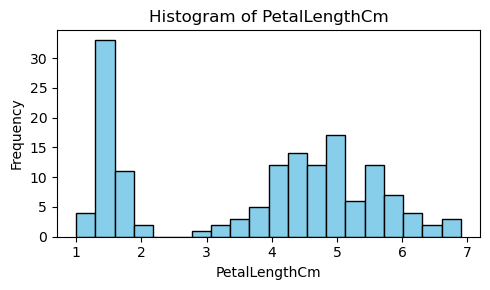

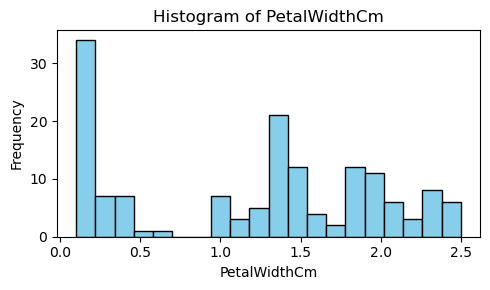

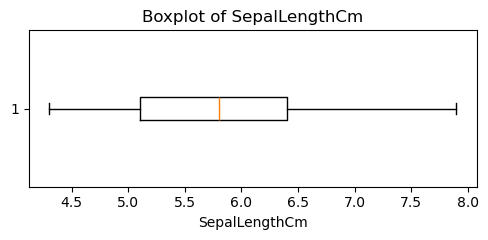

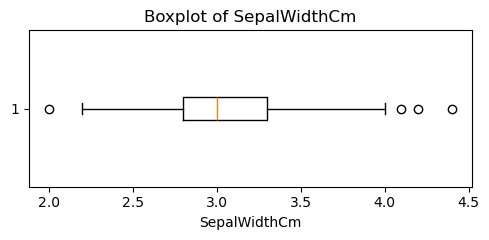

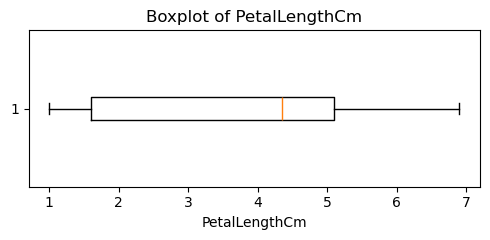

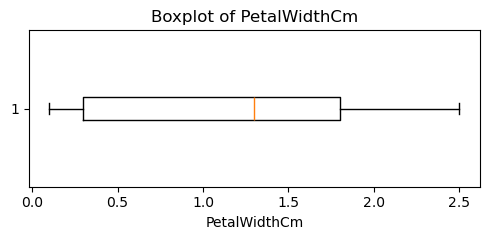

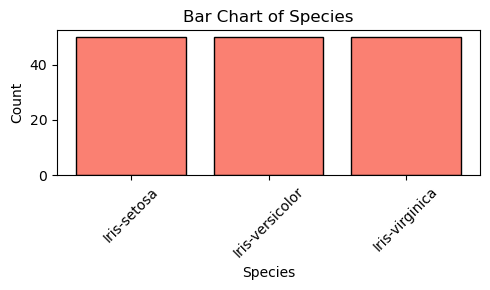

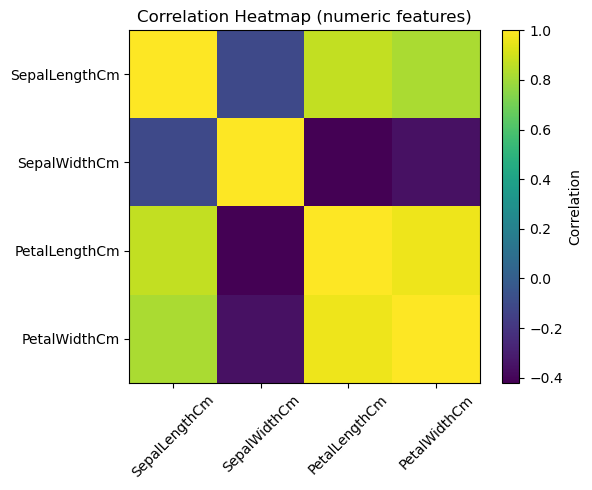

<Figure size 800x800 with 0 Axes>

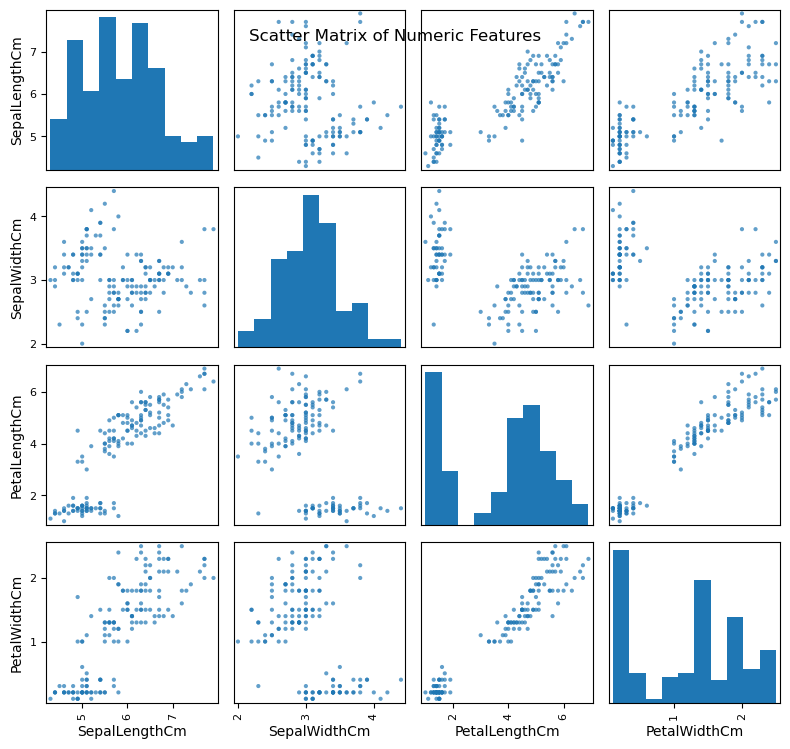

In [45]:
# If there is an "Id" column, we drop it
if 'Id' in df.columns:
    df = df.drop(columns=['Id'])

# Rename columns to remove spaces (optional)
df.columns = [
    col.replace(' ', '_')
    for col in df.columns
]

numeric_cols = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
categorical_cols = ['Species']  # Only the target column remains categorical

print("\n=== Numeric Descriptive Statistics ===\n")
print(df[numeric_cols].describe())

print("\n=== All‐Columns Descriptive Statistics ===\n")
print(df.describe(include='all'))

print("\n=== Value Counts: Species ===\n")
print(df['Species'].value_counts().rename_axis('Species').reset_index(name='Count'))


print("\n=== Correlation Matrix (numeric only) ===\n")
corr = df[numeric_cols].corr()
print(corr)


#  Histograms
for col in numeric_cols:
    plt.figure(figsize=(5, 3))
    plt.hist(df[col], bins=20, color='skyblue', edgecolor='black')
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# Boxplots 
for col in numeric_cols:
    plt.figure(figsize=(5, 2.5))
    plt.boxplot(df[col], vert=False)
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

#  Bar chart 
plt.figure(figsize=(5, 3))
species_counts = df['Species'].value_counts().sort_index()
plt.bar(
    species_counts.index.astype(str),
    species_counts.values,
    color='salmon',
    edgecolor='black'
)
plt.title("Bar Chart of Species")
plt.xlabel("Species")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Correlation heatmap for numeric features
plt.figure(figsize=(6, 5))
im = plt.imshow(corr, aspect='auto', cmap='viridis')
plt.colorbar(im, label='Correlation')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation Heatmap (numeric features)")
plt.tight_layout()
plt.show()

# Scatter matrix (pairwise scatterplots) for numeric features
plt.figure(figsize=(8, 8))
scatter_matrix(df[numeric_cols], diagonal='hist', alpha=0.7, figsize=(8, 8))
plt.suptitle("Scatter Matrix of Numeric Features", y=0.92)
plt.tight_layout()
plt.show()


# Preprocessing

In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')


from sklearn.impute import SimpleImputer
num_imputer = SimpleImputer(strategy='median')
df[numeric_cols] = num_imputer.fit_transform(df[numeric_cols])

# Remove outliers on numeric columns using the IQR method
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower) & (df[col] <= upper)].reset_index(drop=True)

# Encode the categorical target 'Species' as integer labels
# (Iris-setosa : 0, Iris-versicolor : 1, Iris-virginica : 2)
df['Species'] = df['Species'].map({
    'Iris-setosa': 0,
    'Iris-versicolor': 1,
    'Iris-virginica': 2
})


FEATURES = numeric_cols  # only the four numeric measurements
X_df = df[FEATURES]
y = df['Species'].values  


X = X_df.values  

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

#  We scale only the numeric columns in X_train/X_test
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)


# Final descriptive stats


=== Numeric Descriptive Statistics ===

       SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
count     146.000000    146.000000     146.000000    146.000000
mean        5.856849      3.036986       3.807534      1.219863
std         0.834093      0.395145       1.757117      0.760365
min         4.300000      2.200000       1.000000      0.100000
25%         5.100000      2.800000       1.600000      0.300000
50%         5.800000      3.000000       4.400000      1.300000
75%         6.400000      3.300000       5.100000      1.800000
max         7.900000      4.000000       6.900000      2.500000

=== All‐Columns Descriptive Statistics ===

       SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm     Species
count     146.000000    146.000000     146.000000    146.000000  146.000000
mean        5.856849      3.036986       3.807534      1.219863    1.020548
std         0.834093      0.395145       1.757117      0.760365    0.817643
min         4.300000      2.200000

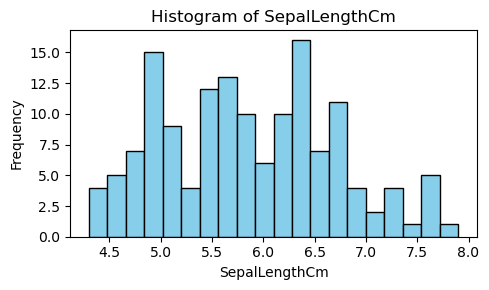

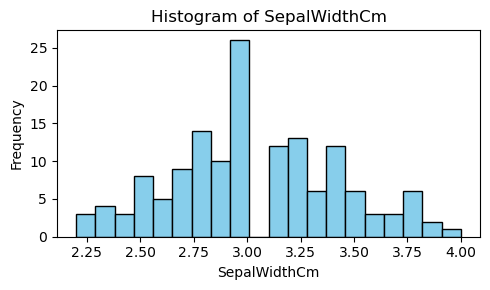

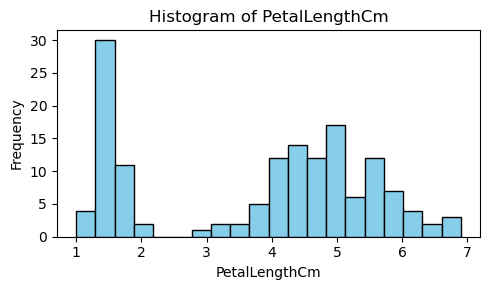

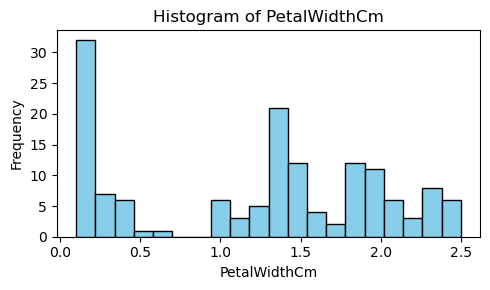

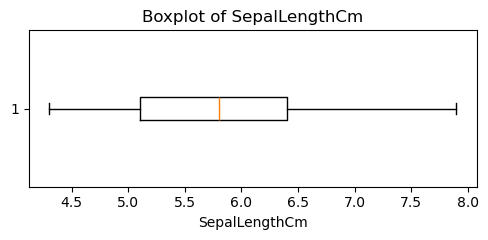

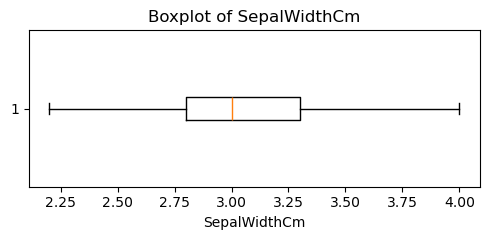

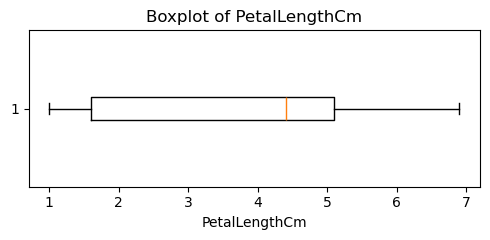

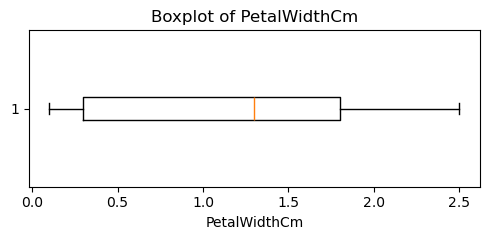

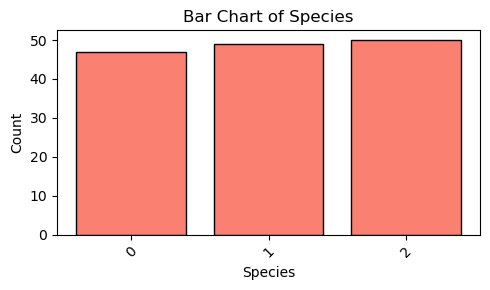

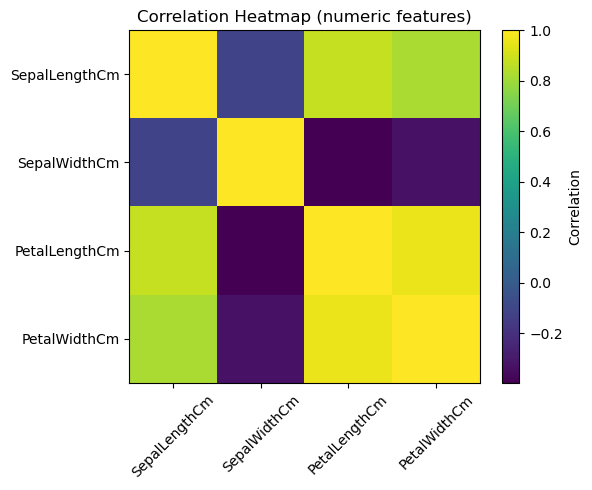

<Figure size 800x800 with 0 Axes>

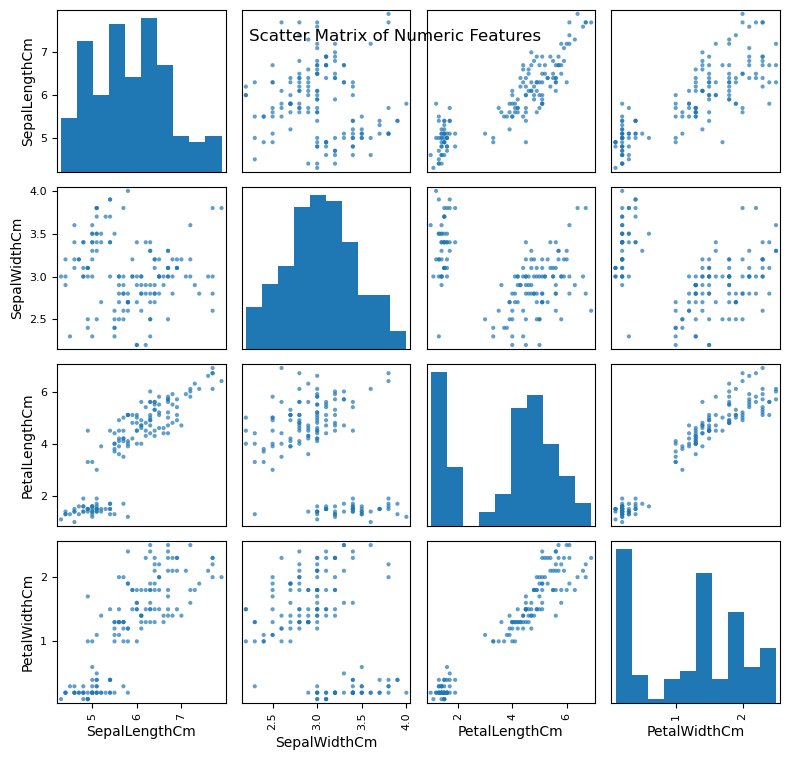

In [47]:
print("\n=== Numeric Descriptive Statistics ===\n")
print(df[numeric_cols].describe())

#  All‐columns summary (includes counts for categorical)
print("\n=== All‐Columns Descriptive Statistics ===\n")
print(df.describe(include='all'))

# Value counts for the categorical column 'Species'
print("\n=== Value Counts: Species ===\n")
print(df['Species'].value_counts().rename_axis('Species').reset_index(name='Count'))


print("\n=== Correlation Matrix (numeric only) ===\n")
corr = df[numeric_cols].corr()
print(corr)



# Histograms for each numeric column
for col in numeric_cols:
    plt.figure(figsize=(5, 3))
    plt.hist(df[col], bins=20, color='skyblue', edgecolor='black')
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

#  Boxplots for each numeric column
for col in numeric_cols:
    plt.figure(figsize=(5, 2.5))
    plt.boxplot(df[col], vert=False)
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

#  Bar chart for the categorical column 'Species'
plt.figure(figsize=(5, 3))
species_counts = df['Species'].value_counts().sort_index()
plt.bar(
    species_counts.index.astype(str),
    species_counts.values,
    color='salmon',
    edgecolor='black'
)
plt.title("Bar Chart of Species")
plt.xlabel("Species")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#  Correlation heatmap for numeric features
plt.figure(figsize=(6, 5))
im = plt.imshow(corr, aspect='auto', cmap='viridis')
plt.colorbar(im, label='Correlation')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation Heatmap (numeric features)")
plt.tight_layout()
plt.show()

#  Scatter matrix (pairwise scatterplots) for numeric features
plt.figure(figsize=(8, 8))
scatter_matrix(df[numeric_cols], diagonal='hist', alpha=0.7, figsize=(8, 8))
plt.suptitle("Scatter Matrix of Numeric Features", y=0.92)
plt.tight_layout()
plt.show()


# LR results

In [48]:

# We define the hyperparameter grid for Logistic Regression
param_grid = {
    'solver':   ['batch', 'sgd', 'mini-batch'],
    'lr':       [0.01, 0.05, 0.1],
    'penalty':  [None, 'l1', 'l2'],
    'C':        [0.1, 1.0, 10.0],
    'batch_size':[16, 32, 64],
    'n_iters':  [1000]
}

'''
We do a Grid Search during which we will record runtime and test accuracy in order to choose the most 
performing hyperparmater combination while taking into account the computational constraints, 
notably the wall‐clock training time
'''

results = []
for params in ParameterGrid(param_grid):
    model = LogisticRegressionScratch(
        lr=params['lr'],
        n_iters=params['n_iters'],
        penalty=params['penalty'],
        C=params['C'],
        solver=params['solver'],
        batch_size=params['batch_size'],
        tol=1e-6,
        random_state=42,
        verbose=False
    )

    # We record the time spent for training
    start_time = time.time()
    model.fit(X_train, y_train)
    fit_time = time.time() - start_time

    # We record the time spent for scoring
    start_time = time.time()
    test_accuracy = model.score(X_test, y_test)
    score_time = time.time() - start_time

    # We gather the results obtained
    entry = params.copy()
    entry.update({
        'fit time in seconds': round(fit_time, 4),
        'score time in seconds': round(score_time, 4),
        'test accuracy': round(test_accuracy, 6)
    })
    results.append(entry)

results_df = pd.DataFrame(results)

# We sort by descending test_accuracy and then by fit_time ascending
results_df = results_df.sort_values(
    by=['test accuracy', 'fit time in seconds'],
    ascending=[False, True]
).reset_index(drop=True)


# We will take the best performing hyperparameters combination by accuracy score
idx_best = results_df['test accuracy'].idxmax()
best_row = results_df.loc[idx_best]
hyperparam_cols = ['solver', 'lr', 'penalty', 'C', 'batch_size', 'n_iters']
best_lr_params = best_row[hyperparam_cols].to_dict()

results_df.to_excel(r'C:\Users\Maestro\Desktop\Master DSE\Machine Learning & Statistical Learning\Cesa Bianchi\Data\Iris\Iris_lr_grid_search_with_timing.xlsx', index=False)

# We Summarize per-hyperparameter

grouped_summaries = {}
for hp in ['solver', 'lr', 'penalty', 'C', 'batch_size', 'n_iters']:
    summary = results_df.groupby(hp).agg({
        'test accuracy': ['mean', 'max'],
        'fit time in seconds':  ['mean']
    })

    renamed_columns = []
    for (lvl0, lvl1) in summary.columns:
        if lvl0 == 'test accuracy' and lvl1 == 'mean':
            renamed_columns.append('mean accuracy')
        elif lvl0 == 'test accuracy' and lvl1 == 'max':
            renamed_columns.append('best accuracy')
        elif lvl0 == 'fit time in seconds' and lvl1 == 'mean':
            renamed_columns.append('mean fit time in sec')
        else:
            renamed_columns.append(f'{lvl0}_{lvl1}')  # fallback
    summary.columns = renamed_columns

    grouped_summaries[col] = summary.reset_index()

# We print the top‐5 hyperparameter configurations
print("Top 5 hyperparameter configurations by test accuracy:\n")
print(results_df.head(5).to_string(index=False))

# We print summary for each hyperparameter
for hp, df_hp in grouped_summaries.items():
    print(f"\n=== Summary grouped by '{hp}' ===")
    print(df_hp.to_string(index=False))

# Optionally save each grouping summary to separate Excel sheets
with pd.ExcelWriter(r'C:\Users\Maestro\Desktop\Master DSE\Machine Learning & Statistical Learning\Cesa Bianchi\Data\Iris\Iris_lr_hyperparam_summaries.xlsx') as writer:
    for hp, df_hp in grouped_summaries.items():
        df_hp.to_excel(writer, sheet_name=f'{hp}_summary', index=False)

print("\nSummaries have been saved as Excel Files in the corresponding dataset folder.")


Top 5 hyperparameter configurations by test accuracy:

  C  batch_size  lr  n_iters penalty solver  fit time in seconds  score time in seconds  test accuracy
0.1          16 0.1     1000    None    sgd                0.004                    0.0       0.666667
0.1          32 0.1     1000    None    sgd                0.004                    0.0       0.666667
0.1          64 0.1     1000    None    sgd                0.004                    0.0       0.666667
1.0          16 0.1     1000    None    sgd                0.004                    0.0       0.666667
1.0          32 0.1     1000    None    sgd                0.004                    0.0       0.666667

=== Summary grouped by 'PetalWidthCm' ===
 n_iters  mean accuracy  best accuracy  mean fit time in sec
    1000       0.488477       0.666667              0.032482

Summaries have been saved as Excel Files in the corresponding dataset folder.


# SVM Results

In [49]:

# We define the hyperparameter grid for SVM
svm_param_grid = {
    'solver':    ['batch', 'sgd', 'mini-batch'],
    'lr':        [0.001, 0.005, 0.01],   # smaller LR for SVM
    'C':         [0.1, 1.0, 10.0],
    'batch_size':[32, 64],
    'n_iters':   [1000]
}


'''
We do a Grid Search during which we will record runtime and test accuracy in order to choose the most 
performing hyperparmater combination while taking into account the computational constraints, 
notably the wall‐clock training time
'''

results = []
for params in ParameterGrid(svm_param_grid):
    model = LinearSVMScratch(
        lr=params['lr'],
        C=params['C'],
        n_iters=params['n_iters'],
        solver=params['solver'],
        batch_size=params['batch_size'],
        tol=1e-6,
        random_state=42,
        verbose=False
    )

    # We record the time spent training
    t0 = time.time()
    model.fit(X_train, y_train)
    fit_time = time.time() - t0

    # We record the time spent for scoring
    t1 = time.time()
    acc = model.score(X_test, y_test)
    score_time = time.time() - t1

    # We gather the results obtained
    entry = params.copy()
    entry.update({
        'fit time in seconds': round(fit_time, 4),
        'score time in seconds': round(score_time, 4),
        'test accuracy': round(test_accuracy, 6)
    })
    results.append(entry)

# We convert the results to DataFrame
results_df = pd.DataFrame(results)

# We sort by descending test_accuracy and then by fit_time ascending
results_df = results_df.sort_values(
    by=['test accuracy', 'fit time in seconds'],
    ascending=[False, True]
).reset_index(drop=True)

# We will take the best performing hyperparameters combination by accuracy score
idx_best = results_df['test accuracy'].idxmax()
best_row = results_df.loc[idx_best]
hyperparam_cols = ['solver', 'lr', 'C', 'batch_size', 'n_iters']
best_svm_params = best_row[hyperparam_cols].to_dict()

results_df.to_excel(r'C:\Users\Maestro\Desktop\Master DSE\Machine Learning & Statistical Learning\Cesa Bianchi\Data\Iris\Iris_svm_grid_search_with_timing.xlsx', index=False)

print("Top 5 SVM hyperparameter configurations by test accuracy:\n")
print(results_df.head(5).to_string(index=False))

grouped_summaries = {}
for hp in ['solver', 'lr', 'C', 'batch_size', 'n_iters']:
    summary = results_df.groupby(hp).agg({
        'test accuracy': ['mean', 'max'],
        'fit time in seconds':  ['mean']
    })

    renamed_columns = []
    for (lvl0, lvl1) in summary.columns:
        if lvl0 == 'test accuracy' and lvl1 == 'mean':
            renamed_columns.append('mean accuracy')
        elif lvl0 == 'test accuracy' and lvl1 == 'max':
            renamed_columns.append('best accuracy')
        elif lvl0 == 'fit time in seconds' and lvl1 == 'mean':
            renamed_columns.append('mean fit time in sec')
        else:
            renamed_columns.append(f'{lvl0}_{lvl1}')  # fallback
    summary.columns = renamed_columns

    grouped_summaries[hp] = summary.reset_index()

for hp, df_hp in grouped_summaries.items():
    print(f"\n=== Summary grouped by '{hp}' ===")
    print(df_hp.to_string(index=False))

with pd.ExcelWriter(r'C:\Users\Maestro\Desktop\Master DSE\Machine Learning & Statistical Learning\Cesa Bianchi\Data\Iris\Iris_svm_hyperparam_summaries.xlsx') as writer:
    for hp, df_hp in grouped_summaries.items():
        df_hp.to_excel(writer, sheet_name=f'{hp}_summary', index=False)

print("\nSummaries have been saved as Excel Files in the corresponding dataset folder.")


Top 5 SVM hyperparameter configurations by test accuracy:

   C  batch_size    lr  n_iters solver  fit time in seconds  score time in seconds  test accuracy
 0.1          32 0.010     1000  batch               0.0203                    0.0       0.333333
 0.1          64 0.010     1000  batch               0.0219                    0.0       0.333333
10.0          64 0.010     1000    sgd               0.0323                    0.0       0.333333
 1.0          64 0.005     1000  batch               0.0337                    0.0       0.333333
10.0          64 0.010     1000  batch               0.0338                    0.0       0.333333

=== Summary grouped by 'solver' ===
    solver  mean accuracy  best accuracy  mean fit time in sec
     batch       0.333333       0.333333              0.034194
mini-batch       0.333333       0.333333              0.057156
       sgd       0.333333       0.333333              0.038722

=== Summary grouped by 'lr' ===
   lr  mean accuracy  best accu

# RF Results

In [50]:

# We define the hyperparameter grid for the Random Forest
rf_param_grid = {
    'n_estimators':    [10, 20,50],
    'max_depth':       [None, 5, 10],
    'min_samples_leaf':[1, 2, 5],
    'max_features':    [None, 'sqrt', 'log2']  # We willl interpret None as sqrt(n_features)
}


'''
We do a Grid Search during which we will record runtime and test accuracy in order to choose the most 
performing hyperparmater combination while taking into account the computational constraints, 
notably the wall‐clock training time
'''

results = []
n_features = X_train.shape[1]

for params in ParameterGrid(rf_param_grid):
    # Interpret 'max_features' parameter
    if params['max_features'] is None:
        mf = None
    elif params['max_features'] == 'sqrt':
        mf = int(np.sqrt(n_features))
    elif params['max_features'] == 'log2':
        mf = int(np.log2(n_features))
    else:
        # If it's a number, but in this grid it isn't; so we can skip
        mf = None

    # Instantiate RandomForestScratch with these hyperparameters
    model = RandomForestScratch(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        min_samples_leaf=params['min_samples_leaf'],
        max_features=mf,
        random_state=42,
        verbose=False
    )

    # We record the time spent training
    t0 = time.time()
    model.fit(X_train, y_train)
    fit_time = time.time() - t0

    # We record the time spent for scoring
    t1 = time.time()
    test_acc = model.score(X_test, y_test)
    score_time = time.time() - t1

    # Record results
    entry = params.copy()
    entry.update({
        'fit time in seconds': round(fit_time, 4),
        'score_time_sec': round(score_time, 4),
        'test accuracy': round(test_acc, 6)
    })
    results.append(entry)

#  Compile results into DataFrame, sort, and save
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(
    by=['test accuracy', 'fit time in seconds'],
    ascending=[False, True]
).reset_index(drop=True)

# We will take the best performing hyperparameters combination by accuracy score
idx_best = results_df['test accuracy'].idxmax()
best_row = results_df.loc[idx_best]
hyperparam_cols = ['n_estimators', 'max_depth', 'min_samples_leaf', 'max_features']
best_rf_params = best_row[hyperparam_cols].to_dict()

results_df.to_excel(r'C:\Users\Maestro\Desktop\Master DSE\Machine Learning & Statistical Learning\Cesa Bianchi\Data\Iris\Iris_rf_grid_search_with_timing.xlsx', index=False)

# We print the top‐5 performing configurations
print("Top 5 Random Forest hyperparameter configurations by test accuracy:\n")
print(results_df.head(5).to_string(index=False))

#  Summaries per hyperparameter
grouped_summaries = {}
for hp in ['n_estimators', 'max_depth', 'min_samples_leaf', 'max_features']:
    summary = results_df.groupby(hp).agg({
        'test accuracy': ['mean', 'max'],
        'fit time in seconds':  ['mean']
    })

    renamed_columns = []
    for (lvl0, lvl1) in summary.columns:
        if lvl0 == 'test accuracy' and lvl1 == 'mean':
            renamed_columns.append('mean accuracy')
        elif lvl0 == 'test accuracy' and lvl1 == 'max':
            renamed_columns.append('best accuracy')
        elif lvl0 == 'fit time in seconds' and lvl1 == 'mean':
            renamed_columns.append('mean fit time in sec')
        else:
            renamed_columns.append(f'{lvl0}_{lvl1}')  # fallback
    summary.columns = renamed_columns

    grouped_summaries[hp] = summary.reset_index()

#  Print grouped summaries
for hp, df_hp in grouped_summaries.items():
    print(f"\n Summary grouped by '{hp}' ")
    print(df_hp.to_string(index=False))

with pd.ExcelWriter(r'C:\Users\Maestro\Desktop\Master DSE\Machine Learning & Statistical Learning\Cesa Bianchi\Data\Iris\Iris_rf_hyperparam_summaries.xlsx') as writer:
    for hp, df_hp in grouped_summaries.items():
        df_hp.to_excel(writer, sheet_name=f'{hp}_summary', index=False)

print("\nSummaries have been saved as Excel Files in the corresponding dataset folder.")


Top 5 Random Forest hyperparameter configurations by test accuracy:

 max_depth max_features  min_samples_leaf  n_estimators  fit time in seconds  score_time_sec  test accuracy
      10.0         None                 5            10               0.0398           0.000       0.933333
      10.0         sqrt                 5            10               0.0409           0.000       0.933333
       NaN         sqrt                 5            10               0.0419           0.001       0.933333
      10.0         log2                 5            10               0.0422           0.000       0.933333
       5.0         sqrt                 5            10               0.0425           0.001       0.933333

 Summary grouped by 'n_estimators' 
 n_estimators  mean accuracy  best accuracy  mean fit time in sec
           10       0.911111       0.933333              0.052856
           20       0.933333       0.933333              0.104763
           50       0.933333       0.933333     

# Final DataViz and comparisons

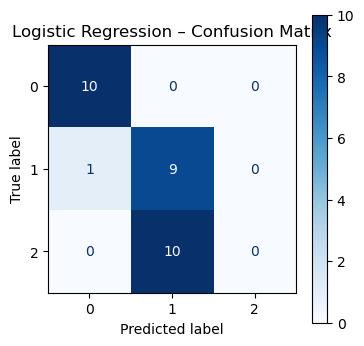

=== Classification Report: Logistic Regression ===
              precision    recall  f1-score   support

           0     0.9091    1.0000    0.9524        10
           1     0.4737    0.9000    0.6207        10
           2     0.0000    0.0000    0.0000        10

    accuracy                         0.6333        30
   macro avg     0.4609    0.6333    0.5244        30
weighted avg     0.4609    0.6333    0.5244        30





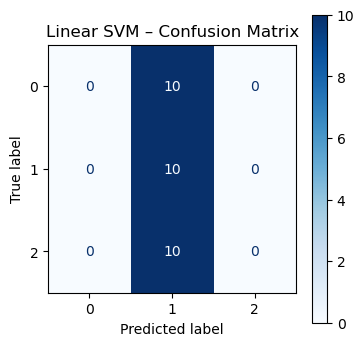

=== Classification Report: Linear SVM ===
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        10
           1     0.3333    1.0000    0.5000        10
           2     0.0000    0.0000    0.0000        10

    accuracy                         0.3333        30
   macro avg     0.1111    0.3333    0.1667        30
weighted avg     0.1111    0.3333    0.1667        30





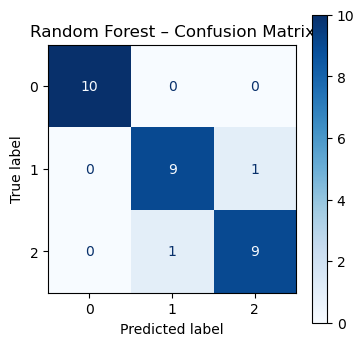

=== Classification Report: Random Forest ===
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        10
           1     0.9000    0.9000    0.9000        10
           2     0.9000    0.9000    0.9000        10

    accuracy                         0.9333        30
   macro avg     0.9333    0.9333    0.9333        30
weighted avg     0.9333    0.9333    0.9333        30




=== Summary: Test Accuracy & Fit Time on Income Datset ===

              Model  Test Accuracy  Fit Time (s)
Logistic Regression       0.633333        2.0435
         Linear SVM       0.333333        0.0291
      Random Forest       0.933333        0.0398


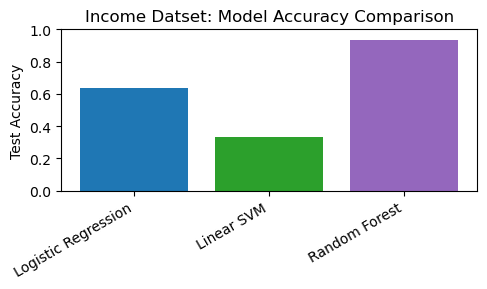

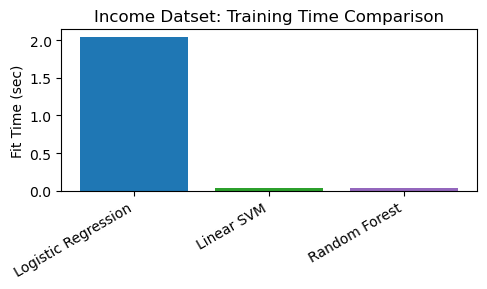

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
)


# Logistic Regression
best_lr_model = LogisticRegressionScratch(**best_lr_params)
best_lr_model.fit(X_train, y_train)

# Linear SVM
best_svm_model = LinearSVMScratch(**best_svm_params)
best_svm_model.fit(X_train, y_train)

# Random Forest: first convert 'max_features' string → integer if needed
#    (the grid saved 'max_features' as "None", "sqrt", or "log2")
n_features = X_train.shape[1]
mf_raw = best_rf_params['max_features']
if mf_raw is None:
    mf_int = None
elif mf_raw == 'sqrt':
    mf_int = int(np.sqrt(n_features))
elif mf_raw == 'log2':
    mf_int = int(np.log2(n_features))
else:
    # in case grid‐search directly stored an integer
    mf_int = int(mf_raw)

best_rf_params_converted = {
    'n_estimators':     best_rf_params['n_estimators'],
    'max_depth':        best_rf_params['max_depth'],
    'min_samples_leaf': best_rf_params['min_samples_leaf'],
    'max_features':     mf_int,
    'random_state':     42,
    'verbose':          False
}
best_rf_model = RandomForestScratch(**best_rf_params_converted)
best_rf_model.fit(X_train, y_train)


def plot_confusion_and_report(model, X_test, y_test, title):
    """
    Given a trained model, test‐set, and a title,
    plot the confusion matrix and print classification report.
    """
    # Predict labels
    y_pred = model.predict(X_test)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(figsize=(4, 4))
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title(f"{title} – Confusion Matrix")
    plt.show()

    # Classification report
    print(f"=== Classification Report: {title} ===")
    print(classification_report(y_test, y_pred, digits=4))
    print("\n" + "="*60 + "\n")


# Plot for Logistic Regression
plot_confusion_and_report(best_lr_model, X_test, y_test, "Logistic Regression")

# Plot for Linear SVM
plot_confusion_and_report(best_svm_model, X_test, y_test, "Linear SVM")

# Plot for Random Forest
plot_confusion_and_report(best_rf_model, X_test, y_test, "Random Forest")

best_lr_acc  = best_lr_model.score(X_test, y_test)
best_svm_acc = best_svm_model.score(X_test, y_test)
best_rf_acc  = best_rf_model.score(X_test, y_test)

best_lr_time  = lr_df.iloc[idx_best_lr]['fit time in seconds']
best_svm_time = svm_df.iloc[idx_best_svm]['fit time in seconds']
best_rf_time  = results_df.iloc[idx_best_rf]['fit time in seconds']

summary_df = pd.DataFrame({
    'Model':       ['Logistic Regression', 'Linear SVM', 'Random Forest'],
    'Test Accuracy':[best_lr_acc, best_svm_acc, best_rf_acc],
    'Fit Time (s)': [best_lr_time, best_svm_time, best_rf_time]
})

print("\n Summary: Test Accuracy & Fit Time on Iris Datset \n")
print(summary_df.to_string(index=False))

plt.figure(figsize=(5, 3))
plt.bar(summary_df['Model'], summary_df['Test Accuracy'], color=['#1f77b4','#2ca02c','#9467bd'])
plt.ylabel("Test Accuracy")
plt.title("Iris Datset: Model Accuracy Comparison")
plt.ylim(0, 1)
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 3))
plt.bar(summary_df['Model'], summary_df['Fit Time (s)'], color=['#1f77b4','#2ca02c','#9467bd'])
plt.ylabel("Fit Time (sec)")
plt.title("Iris Datset: Training Time Comparison")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

# Diabetes

In [52]:
# We load the dataset
data = r'C:\Users\Maestro\Desktop\Master DSE\Machine Learning & Statistical Learning\Cesa Bianchi\Data\Diabetes\diabetes.csv'
df = pd.read_csv(data)
df

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
0                       0.627   50        1  
1                       0.351   31        0  
2                       0.672   32        1  
3                       0.167   21        0  
4                       2.288   33        1  
..                        ...  ...      ...  
763                     0.171   63        0  
764                     0.340   27        0  
765                     0.245   30        0  
766                     0.349   47        1  
767                     0.315   23        0  

[768 rows x 9 columns]

# Data Visaulization

\  Descriptive Statistics 

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min    

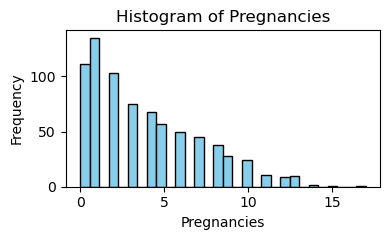

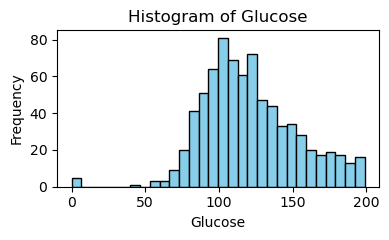

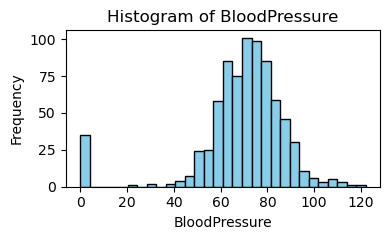

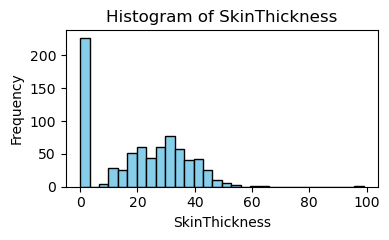

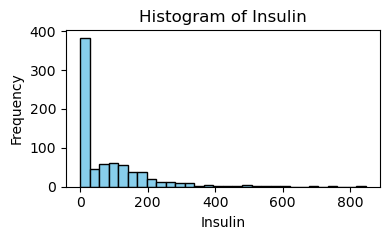

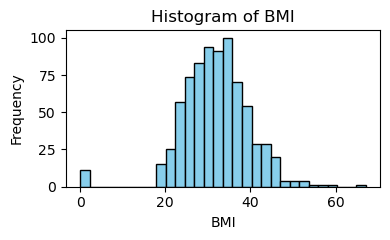

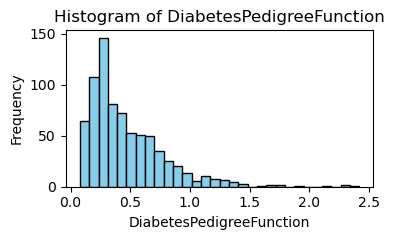

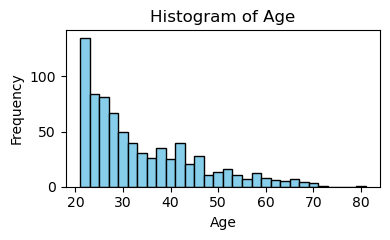

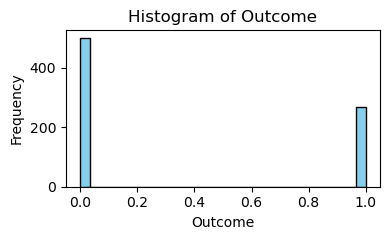

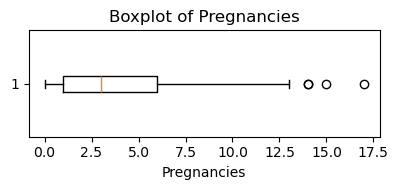

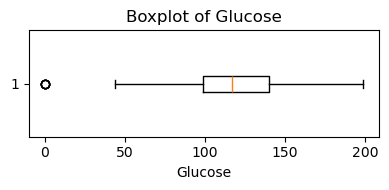

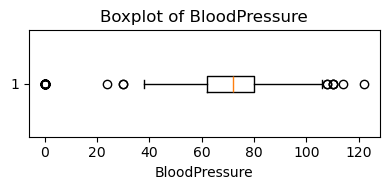

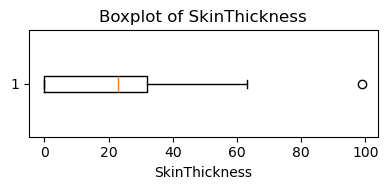

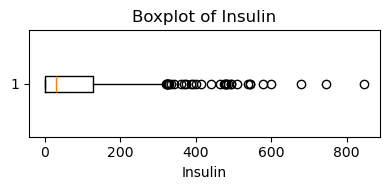

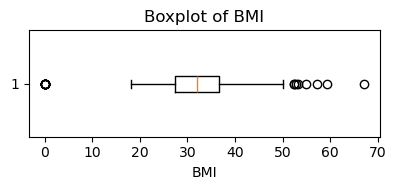

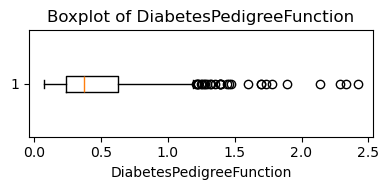

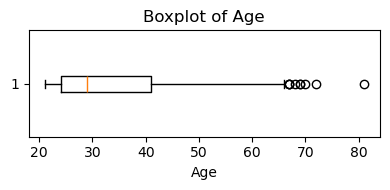

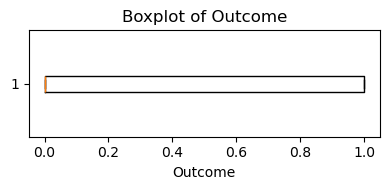

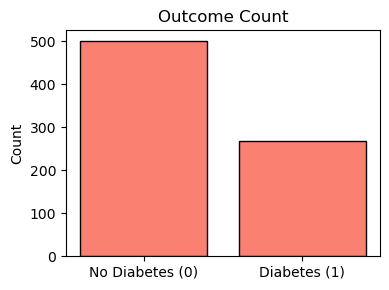

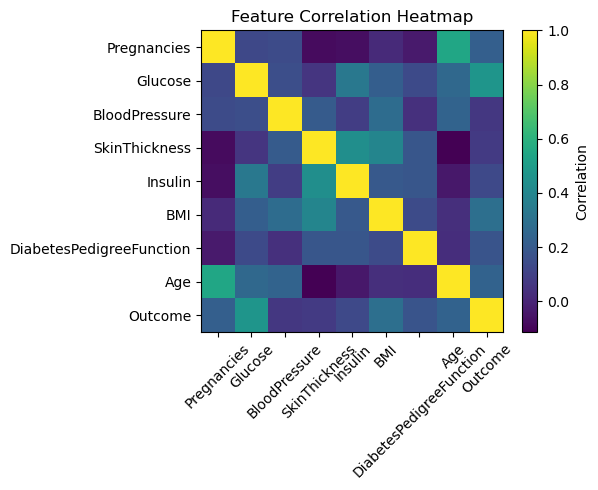

<Figure size 800x800 with 0 Axes>

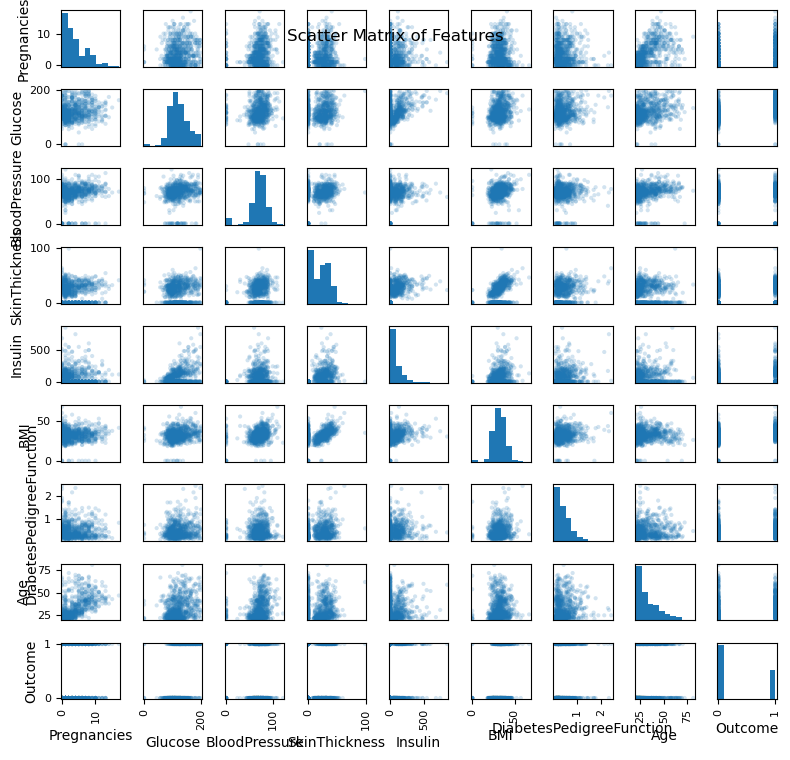

In [53]:

print("\  Descriptive Statistics \n")
print(df.describe())


# Correlation matrix among numeric features
print("\n Correlation Matrix \n")
corr = df.corr()
print(corr)

# Histograms of each numeric feature
for col in df.columns:
    plt.figure(figsize=(4, 2.5))
    plt.hist(df[col], bins=30, color='skyblue', edgecolor='black')
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

#  Boxplots of each numeric feature
for col in df.columns:
    plt.figure(figsize=(4, 2))
    plt.boxplot(df[col], vert=False)
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

#  Bar chart of Outcome distribution
plt.figure(figsize=(4, 3))
out_counts = df['Outcome'].value_counts().sort_index()
plt.bar(['No Diabetes (0)', 'Diabetes (1)'], out_counts.values, color='salmon', edgecolor='black')
plt.title("Outcome Count")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(6, 5))
im = plt.imshow(corr, aspect='auto', cmap='viridis')
plt.colorbar(im, label='Correlation')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

#  Scatter matrix of numeric features
from pandas.plotting import scatter_matrix
plt.figure(figsize=(8, 8))
scatter_matrix(df, diagonal='hist', alpha=0.2, figsize=(8, 8))
plt.suptitle("Scatter Matrix of Features", y=0.92)
plt.tight_layout()
plt.show()



# Data pre-processing

In [54]:

cols_replace_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in cols_replace_zero:
    if col in df.columns:
        df[col] = df[col].replace(0, np.nan)

# We impute any NaNs in numeric columns with the median
numeric_cols = [c for c in df.columns if c != 'Outcome']
num_imputer = SimpleImputer(strategy='median')
df[numeric_cols] = num_imputer.fit_transform(df[numeric_cols])

# We remove outliers on numeric columns via IQR rule
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower) & (df[col] <= upper)].reset_index(drop=True)

#  Final check: no NaNs should remain
assert not df.isna().any().any(), "There are still NaNs in the DataFrame!"


FEATURES = [c for c in df.columns if c != 'Outcome']
X_df = df[FEATURES]
y = df['Outcome'].values

X = X_df.values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)




# Final Data Visualization


=== Numeric Descriptive Statistics ===

       Pregnancies     Glucose  BloodPressure  SkinThickness  Insulin  \
count   332.000000  332.000000     332.000000     332.000000    332.0   
mean      4.361446  118.762048      73.566265      28.933735    125.0   
std       3.348186   29.193707      10.228735       4.219986      0.0   
min       0.000000   44.000000      48.000000      15.000000    125.0   
25%       2.000000   99.750000      68.000000      29.000000    125.0   
50%       4.000000  114.000000      72.000000      29.000000    125.0   
75%       7.000000  135.250000      80.000000      29.000000    125.0   
max      13.000000  196.000000     104.000000      42.000000    125.0   

              BMI  DiabetesPedigreeFunction         Age  
count  332.000000                332.000000  332.000000  
mean    31.383434                  0.367702   35.376506  
std      6.061731                  0.215653   12.340332  
min     18.200000                  0.078000   21.000000  
25%     27.

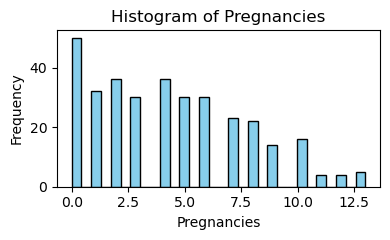

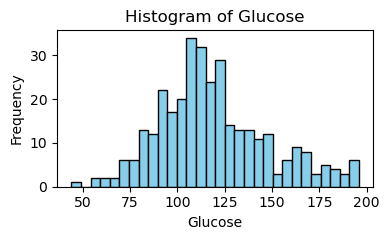

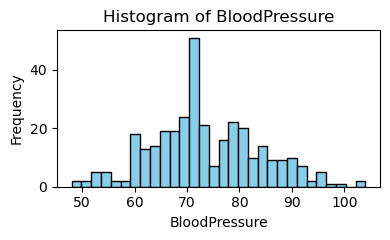

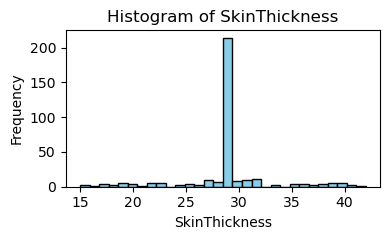

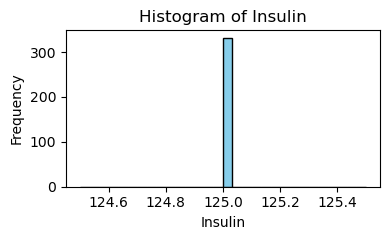

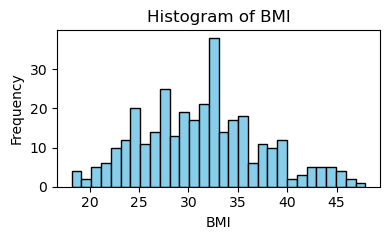

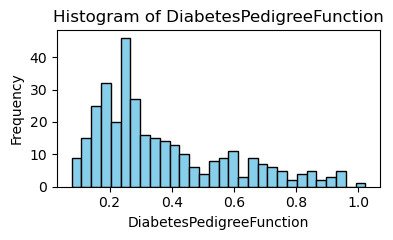

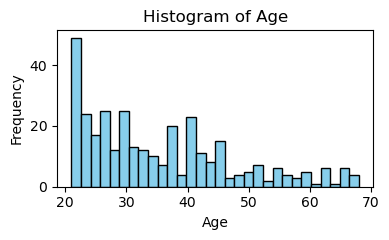

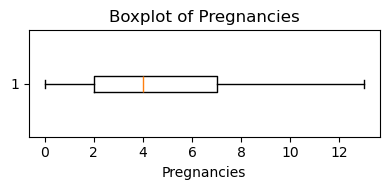

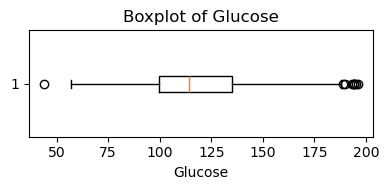

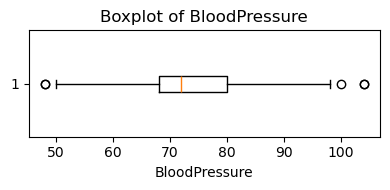

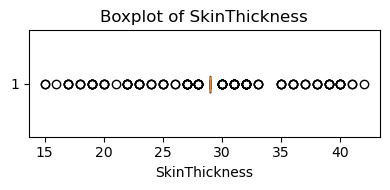

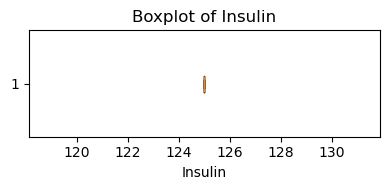

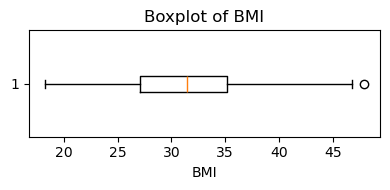

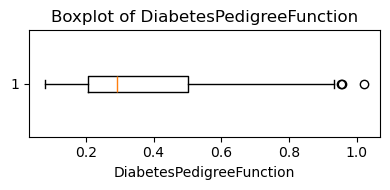

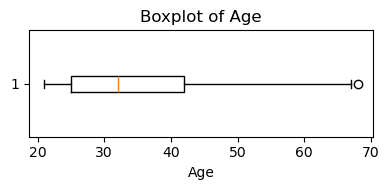

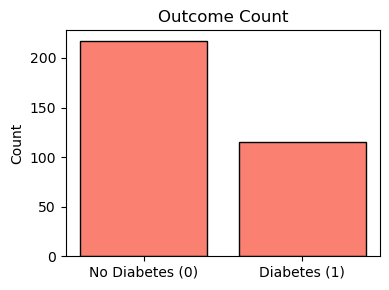

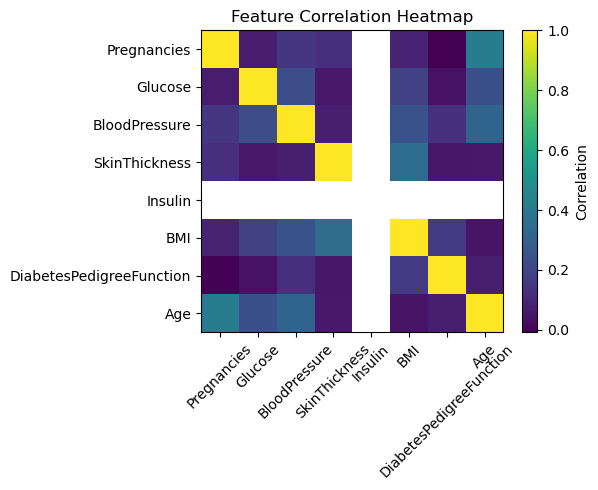

<Figure size 800x800 with 0 Axes>

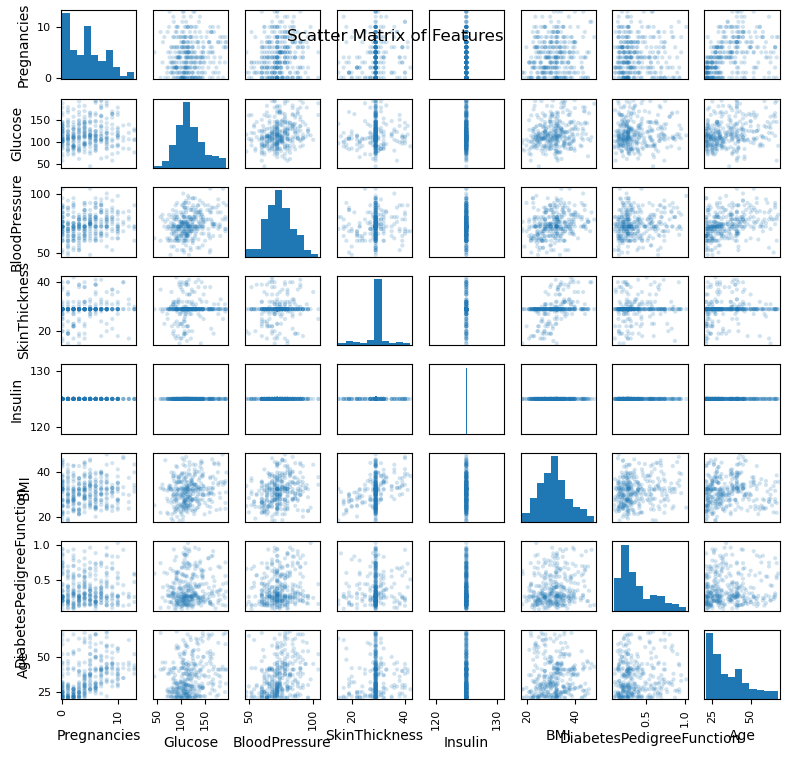

In [55]:
print("\n=== Numeric Descriptive Statistics ===\n")
print(df[FEATURES].describe())

print("\n=== Target Distribution (Outcome) ===\n")
print(df['Outcome'].value_counts().rename_axis('Outcome').reset_index(name='Count'))

# Correlation matrix among numeric features
print("\n=== Correlation Matrix ===\n")
corr = df[FEATURES].corr()
print(corr)

#  Histograms of each numeric feature
for col in FEATURES:
    plt.figure(figsize=(4, 2.5))
    plt.hist(df[col], bins=30, color='skyblue', edgecolor='black')
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

#  Boxplots of each numeric feature
for col in FEATURES:
    plt.figure(figsize=(4, 2))
    plt.boxplot(df[col], vert=False)
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

#  Bar chart of Outcome distribution
plt.figure(figsize=(4, 3))
out_counts = df['Outcome'].value_counts().sort_index()
plt.bar(['No Diabetes (0)', 'Diabetes (1)'], out_counts.values, color='salmon', edgecolor='black')
plt.title("Outcome Count")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

#  Correlation heatmap
plt.figure(figsize=(6, 5))
im = plt.imshow(corr, aspect='auto', cmap='viridis')
plt.colorbar(im, label='Correlation')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

#  Scatter matrix of numeric features
from pandas.plotting import scatter_matrix
plt.figure(figsize=(8, 8))
scatter_matrix(df[FEATURES], diagonal='hist', alpha=0.2, figsize=(8, 8))
plt.suptitle("Scatter Matrix of Features", y=0.92)
plt.tight_layout()
plt.show()



# LR Results

In [56]:
lr_param_grid = {
    'solver':    ['batch', 'sgd', 'mini-batch'],
    'lr':        [0.005, 0.01, 0.05],
    'penalty':   [None, 'l2'],
    'C':         [0.1, 1.0, 10.0],
    'batch_size':[16, 32,64],
    'n_iters':   [1000,2000]
}

lr_results = []
for params in ParameterGrid(lr_param_grid):
    model = LogisticRegressionScratch(
        lr=params['lr'],
        n_iters=params['n_iters'],
        penalty=params['penalty'],
        C=params['C'],
        solver=params['solver'],
        batch_size=params['batch_size'],
        tol=1e-6,
        random_state=42,
        verbose=False
    )
    # Time fit
    t0 = time.time()
    model.fit(X_train, y_train)
    fit_time = time.time() - t0
    # Time score
    t1 = time.time()
    test_accuracy = model.score(X_test, y_test)
    score_time = time.time() - t1

    entry = params.copy()
    entry.update({
        'fit_time_sec':   round(fit_time,   4),
        'score_time_sec': round(score_time, 4),
        'test_accuracy':  round(test_accuracy, 6)
    })
    lr_results.append(entry)

lr_df = pd.DataFrame(lr_results)
lr_df = lr_df.sort_values(by=['test_accuracy','fit_time_sec'], ascending=[False,True]).reset_index(drop=True)

idx_best_lr = lr_df['test_accuracy'].idxmax()
best_lr_row = lr_df.loc[idx_best_lr]
lr_hyperparam_cols = ['solver','lr','penalty','C','batch_size','n_iters']
best_lr_params = best_lr_row[lr_hyperparam_cols].to_dict()

lr_df.to_excel(r'C:\Users\Maestro\Desktop\Master DSE\Machine Learning & Statistical Learning\Cesa Bianchi\Data\Diabetes\diabetes_lr_grid_search.xlsx', index=False)

lr_summaries = {}
for hp in lr_hyperparam_cols:
    summary = lr_df.groupby(hp).agg({
        'test_accuracy': ['mean','max'],
        'fit_time_sec':  ['mean']
    })
    # Rename columns
    new_cols = []
    for lvl0, lvl1 in summary.columns:
        if lvl0 == 'test_accuracy' and lvl1 == 'mean':
            new_cols.append('mean_accuracy')
        elif lvl0 == 'test_accuracy' and lvl1 == 'max':
            new_cols.append('best_accuracy')
        elif lvl0 == 'fit_time_sec' and lvl1 == 'mean':
            new_cols.append('mean_fit_time_sec')
        else:
            new_cols.append(f'{lvl0}_{lvl1}')
    summary.columns = new_cols
    lr_summaries[hp] = summary.reset_index()

print("\n=== Top 5 Logistic Regression Hyperparameter Configs ===\n")
print(lr_df.head(5).to_string(index=False))

for hp, df_hp in lr_summaries.items():
    print(f"\n=== LR Summary grouped by '{hp}' ===")
    print(df_hp.to_string(index=False))

with pd.ExcelWriter(r'C:\Users\Maestro\Desktop\Master DSE\Machine Learning & Statistical Learning\Cesa Bianchi\Data\Diabetes\diabetes_lr_hyperparam_summaries.xlsx') as writer:
    for hp, df_hp in lr_summaries.items():
        df_hp.to_excel(writer, sheet_name=f'{hp}_summary', index=False)




=== Top 5 Logistic Regression Hyperparameter Configs ===

   C  batch_size   lr  n_iters penalty solver  fit_time_sec  score_time_sec  test_accuracy
 0.1          16 0.01     1000    None    sgd        0.0290          0.0000       0.865672
 0.1          32 0.01     1000    None    sgd        0.0299          0.0000       0.865672
10.0          32 0.05     1000      l2    sgd        0.0313          0.0008       0.865672
 1.0          16 0.01     1000    None    sgd        0.0318          0.0000       0.865672
10.0          16 0.01     1000    None    sgd        0.0337          0.0000       0.865672

=== LR Summary grouped by 'solver' ===
    solver  mean_accuracy  best_accuracy  mean_fit_time_sec
     batch       0.769072       0.835821           0.062888
mini-batch       0.768104       0.835821           0.087551
       sgd       0.803482       0.865672           0.054435

=== LR Summary grouped by 'lr' ===
   lr  mean_accuracy  best_accuracy  mean_fit_time_sec
0.005       0.778607    

# SVM Results

In [57]:

svm_param_grid = {
    'lr':        [0.001, 0.005, 0.01],
    'C':         [0.1, 1.0, 10.0],
    'solver':    ['batch', 'sgd', 'mini-batch'],
    'batch_size':[16, 32,64],
    'n_iters': [1000,2000]

}

svm_results = []
for params in ParameterGrid(svm_param_grid):
    model = LinearSVMScratch(
        lr=params['lr'],
        C=params['C'],
        n_iters=params['n_iters'],
        solver=params['solver'],
        batch_size=params['batch_size'],
        tol=1e-6,
        random_state=42,
        verbose=False
    )
    t0 = time.time()
    model.fit(X_train, y_train)
    fit_time = time.time() - t0
    t1 = time.time()
    test_accuracy = model.score(X_test, y_test)
    score_time = time.time() - t1

    entry = params.copy()
    entry.update({
        'fit_time_sec':   round(fit_time,   4),
        'score_time_sec': round(score_time, 4),
        'test_accuracy':  round(test_accuracy, 6)
    })
    svm_results.append(entry)

svm_df = pd.DataFrame(svm_results)
svm_df = svm_df.sort_values(by=['test_accuracy','fit_time_sec'], ascending=[False,True]).reset_index(drop=True)

idx_best_svm = svm_df['test_accuracy'].idxmax()
best_svm_row = svm_df.loc[idx_best_svm]
svm_hyperparam_cols = ['lr','C','n_iters','solver','batch_size']
best_svm_params = best_svm_row[svm_hyperparam_cols].to_dict()

svm_df.to_excel(r'C:\Users\Maestro\Desktop\Master DSE\Machine Learning & Statistical Learning\Cesa Bianchi\Data\Diabetes\diabetes_svm_grid_search.xlsx', index=False)

svm_summaries = {}
for hp in svm_hyperparam_cols:
    summary = svm_df.groupby(hp).agg({
        'test_accuracy': ['mean','max'],
        'fit_time_sec':  ['mean']
    })
    new_cols = []
    for lvl0, lvl1 in summary.columns:
        if lvl0 == 'test_accuracy' and lvl1 == 'mean':
            new_cols.append('mean_accuracy')
        elif lvl0 == 'test_accuracy' and lvl1 == 'max':
            new_cols.append('best_accuracy')
        elif lvl0 == 'fit_time_sec' and lvl1 == 'mean':
            new_cols.append('mean_fit_time_sec')
        else:
            new_cols.append(f'{lvl0}_{lvl1}')
    summary.columns = new_cols
    svm_summaries[hp] = summary.reset_index()

print("\n=== Top 5 SVM Hyperparameter Configs ===\n")
print(svm_df.head(5).to_string(index=False))

for hp, df_hp in svm_summaries.items():
    print(f"\n=== SVM Summary grouped by '{hp}' ===")
    print(df_hp.to_string(index=False))

with pd.ExcelWriter(r'C:\Users\Maestro\Desktop\Master DSE\Machine Learning & Statistical Learning\Cesa Bianchi\Data\Diabetes\diabetes_svm_hyperparam_summaries.xlsx') as writer:
    for hp, df_hp in svm_summaries.items():
        df_hp.to_excel(writer, sheet_name=f'{hp}_summary', index=False)





=== Top 5 SVM Hyperparameter Configs ===

   C  batch_size    lr  n_iters solver  fit_time_sec  score_time_sec  test_accuracy
10.0          32 0.010     1000    sgd        0.0435           0.000       0.865672
10.0          64 0.010     1000    sgd        0.0503           0.001       0.865672
10.0          16 0.010     1000    sgd        0.0539           0.000       0.865672
 1.0          32 0.001     1000    sgd        0.0509           0.001       0.850746
10.0          16 0.001     1000    sgd        0.0509           0.001       0.850746

=== SVM Summary grouped by 'lr' ===
   lr  mean_accuracy  best_accuracy  mean_fit_time_sec
0.001       0.763405       0.850746           0.098513
0.005       0.711719       0.835821           0.097891
0.010       0.714759       0.865672           0.095356

=== SVM Summary grouped by 'C' ===
   C  mean_accuracy  best_accuracy  mean_fit_time_sec
 0.1       0.656716       0.656716           0.095009
 1.0       0.708126       0.850746           0.09715

# Results for RF

In [58]:

rf_param_grid = {
    'n_estimators':    [50, 100, 200],
    'max_depth':       [None, 5, 10],
    'min_samples_leaf':[1, 2, 5],
    'max_features':    ['sqrt', 'log2', None]
}

rf_results = []
n_feat = X_train.shape[1]
for params in ParameterGrid(rf_param_grid):
    mf_raw = params['max_features']
    if mf_raw is None:
        mf_int = None
    elif mf_raw == 'sqrt':
        mf_int = int(np.sqrt(n_feat))
    elif mf_raw == 'log2':
        mf_int = int(np.log2(n_feat))
    else:
        mf_int = int(mf_raw)

    model = RandomForestScratch(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        min_samples_leaf=params['min_samples_leaf'],
        max_features=mf_int,
        random_state=42,
        verbose=False
    )
    t0 = time.time()
    model.fit(X_train, y_train)
    fit_time = time.time() - t0
    t1 = time.time()
    test_accuracy = model.score(X_test, y_test)
    score_time = time.time() - t1

    entry = params.copy()
    entry.update({
        'fit_time_sec':   round(fit_time,   4),
        'score_time_sec': round(score_time, 4),
        'test_accuracy':  round(test_accuracy, 6)
    })
    rf_results.append(entry)

rf_df = pd.DataFrame(rf_results)
rf_df = rf_df.sort_values(by=['test_accuracy','fit_time_sec'], ascending=[False,True]).reset_index(drop=True)

idx_best_rf = rf_df['test_accuracy'].idxmax()
best_rf_row = rf_df.loc[idx_best_rf]
rf_hyperparam_cols = ['n_estimators','max_depth','min_samples_leaf','max_features']
best_rf_params = best_rf_row[rf_hyperparam_cols].to_dict()

rf_df.to_excel(r'C:\Users\Maestro\Desktop\Master DSE\Machine Learning & Statistical Learning\Cesa Bianchi\Data\Diabetes\diabetes_rf_grid_search.xlsx', index=False)

rf_summaries = {}
for hp in rf_hyperparam_cols:
    summary = rf_df.groupby(hp).agg({
        'test_accuracy': ['mean','max'],
        'fit_time_sec':  ['mean']
    })
    new_cols = []
    for lvl0, lvl1 in summary.columns:
        if lvl0 == 'test_accuracy' and lvl1 == 'mean':
            new_cols.append('mean_accuracy')
        elif lvl0 == 'test_accuracy' and lvl1 == 'max':
            new_cols.append('best_accuracy')
        elif lvl0 == 'fit_time_sec' and lvl1 == 'mean':
            new_cols.append('mean_fit_time_sec')
        else:
            new_cols.append(f'{lvl0}_{lvl1}')
    summary.columns = new_cols
    rf_summaries[hp] = summary.reset_index()

print("\n=== Top 5 RF Hyperparameter Configs ===\n")
print(rf_df.head(5).to_string(index=False))

for hp, df_hp in rf_summaries.items():
    print(f"\n=== RF Summary grouped by '{hp}' ===")
    print(df_hp.to_string(index=False))

with pd.ExcelWriter(r'C:\Users\Maestro\Desktop\Master DSE\Machine Learning & Statistical Learning\Cesa Bianchi\Data\Diabetes\diabetes_rf_hyperparam_summaries.xlsx') as writer:
    for hp, df_hp in rf_summaries.items():
        df_hp.to_excel(writer, sheet_name=f'{hp}_summary', index=False)



=== Top 5 RF Hyperparameter Configs ===

 max_depth max_features  min_samples_leaf  n_estimators  fit_time_sec  score_time_sec  test_accuracy
       NaN         log2                 1            50        2.8266          0.0100       0.761194
       NaN         log2                 5           100        3.7468          0.0116       0.746269
       5.0         log2                 5           200        5.1067          0.0160       0.746269
       NaN         log2                 5           200        7.2629          0.0219       0.746269
      10.0         log2                 5           200        7.2664          0.0204       0.746269

=== RF Summary grouped by 'n_estimators' ===
 n_estimators  mean_accuracy  best_accuracy  mean_fit_time_sec
           50       0.678275       0.761194           1.599633
          100       0.678275       0.746269           3.396748
          200       0.675511       0.746269           6.602156

=== RF Summary grouped by 'max_depth' ===
 max_depth 

# DataViz and comparisons

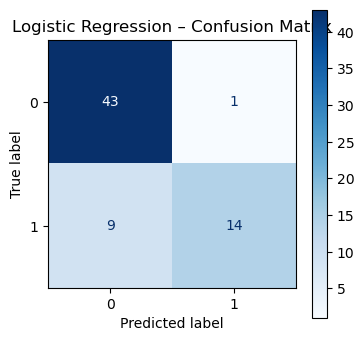

=== Classification Report: Logistic Regression ===
              precision    recall  f1-score   support

           0     0.8269    0.9773    0.8958        44
           1     0.9333    0.6087    0.7368        23

    accuracy                         0.8507        67
   macro avg     0.8801    0.7930    0.8163        67
weighted avg     0.8635    0.8507    0.8413        67





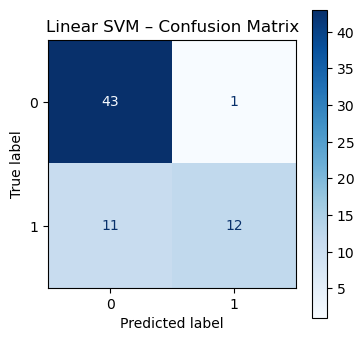

=== Classification Report: Linear SVM ===
              precision    recall  f1-score   support

           0     0.7963    0.9773    0.8776        44
           1     0.9231    0.5217    0.6667        23

    accuracy                         0.8209        67
   macro avg     0.8597    0.7495    0.7721        67
weighted avg     0.8398    0.8209    0.8052        67





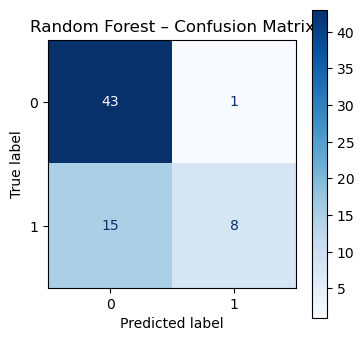

=== Classification Report: Random Forest ===
              precision    recall  f1-score   support

           0     0.7414    0.9773    0.8431        44
           1     0.8889    0.3478    0.5000        23

    accuracy                         0.7612        67
   macro avg     0.8151    0.6625    0.6716        67
weighted avg     0.7920    0.7612    0.7253        67





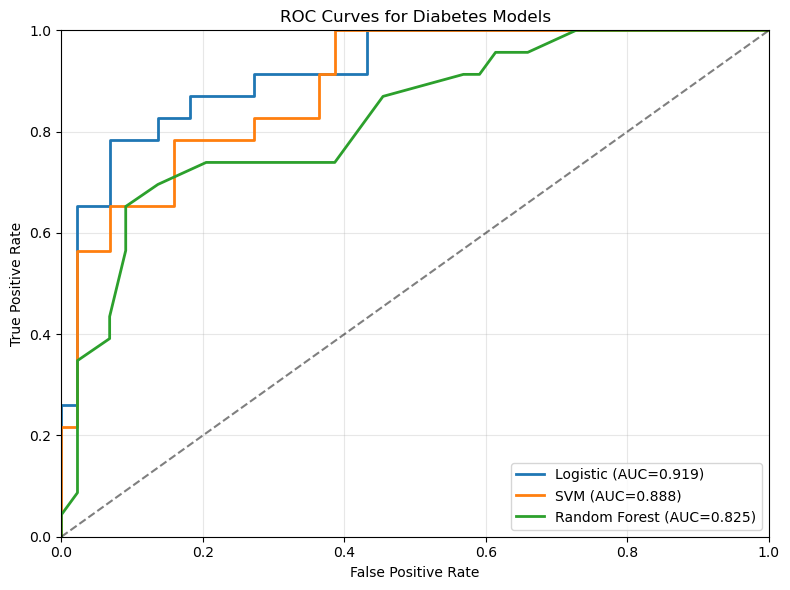

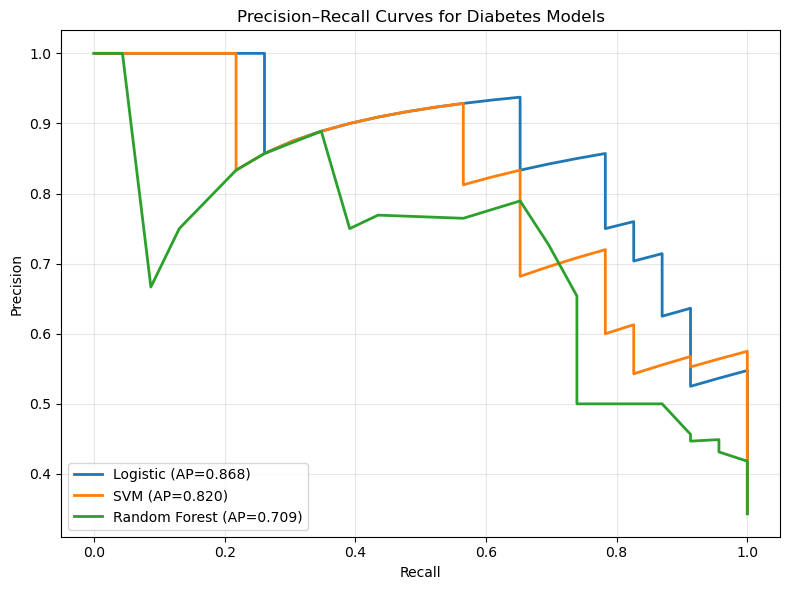


=== Summary: Test Accuracy & Fit Time on Diabetes ===

              Model  Test Accuracy  Fit Time (s)
Logistic Regression       0.850746        0.0268
         Linear SVM       0.820896        0.0369
      Random Forest       0.761194        2.5510


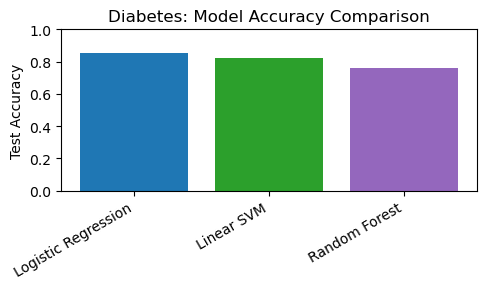

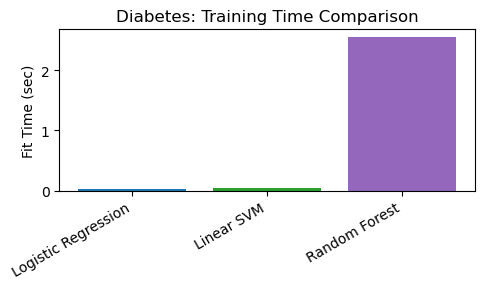

In [295]:

best_lr_model = LogisticRegressionScratch(**best_lr_params)
best_lr_model.fit(X_train, y_train)

best_svm_model = LinearSVMScratch(**best_svm_params)
best_svm_model.fit(X_train, y_train)

mf_raw = best_rf_params['max_features']
if mf_raw is None:
    mf_int = None
elif mf_raw == 'sqrt':
    mf_int = int(np.sqrt(n_feat))
elif mf_raw == 'log2':
    mf_int = int(np.log2(n_feat))
else:
    mf_int = int(mf_raw)

best_rf_model = RandomForestScratch(
    n_estimators=best_rf_params['n_estimators'],
    max_depth=best_rf_params['max_depth'],
    min_samples_leaf=best_rf_params['min_samples_leaf'],
    max_features=mf_int,
    random_state=42,
    verbose=False
)
best_rf_model.fit(X_train, y_train)


def plot_confusion_and_report(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    fig, ax = plt.subplots(figsize=(4, 4))
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title(f"{title} – Confusion Matrix")
    plt.show()

    print(f"=== Classification Report: {title} ===")
    print(classification_report(y_test, y_pred, digits=4))
    print("\n" + "="*60 + "\n")


plot_confusion_and_report(best_lr_model, X_test, y_test, "Logistic Regression")
plot_confusion_and_report(best_svm_model, X_test, y_test, "Linear SVM")
plot_confusion_and_report(best_rf_model, X_test, y_test, "Random Forest")


# ROC Curves & AUC
plt.figure(figsize=(8, 6))

# LR
lr_proba = best_lr_model.predict_proba(X_test)
lr_scores = lr_proba if lr_proba.ndim == 1 else lr_proba[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_scores)
auc_lr = auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr, label=f"Logistic (AUC={auc_lr:.3f})", linewidth=2)

# SVM
try:
    svm_scores = best_svm_model.decision_function(X_test)
except AttributeError:
    svm_proba = best_svm_model.predict_proba(X_test)
    svm_scores = svm_proba[:, 1]
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_scores)
auc_svm = auc(fpr_svm, tpr_svm)
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC={auc_svm:.3f})", linewidth=2)

# RF
rf_proba = best_rf_model.predict_proba(X_test)
rf_scores = rf_proba if rf_proba.ndim == 1 else rf_proba[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_scores)
auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC={auc_rf:.3f})", linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Diabetes Models")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


#  Precision–Recall Curves & AP
plt.figure(figsize=(8, 6))

# LR
prec_lr, rec_lr, _ = precision_recall_curve(y_test, lr_scores)
ap_lr = average_precision_score(y_test, lr_scores)
plt.plot(rec_lr, prec_lr, label=f"Logistic (AP={ap_lr:.3f})", linewidth=2)

# SVM
prec_svm, rec_svm, _ = precision_recall_curve(y_test, svm_scores)
ap_svm = average_precision_score(y_test, svm_scores)
plt.plot(rec_svm, prec_svm, label=f"SVM (AP={ap_svm:.3f})", linewidth=2)

# RF
prec_rf, rec_rf, _ = precision_recall_curve(y_test, rf_scores)
ap_rf = average_precision_score(y_test, rf_scores)
plt.plot(rec_rf, prec_rf, label=f"Random Forest (AP={ap_rf:.3f})", linewidth=2)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves for Diabetes Models")
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



# Combined Summary of Test Accuracy & Fit Time
best_lr_acc  = best_lr_model.score(X_test, y_test)
best_svm_acc = best_svm_model.score(X_test, y_test)
best_rf_acc  = best_rf_model.score(X_test, y_test)

# Assume you recorded best fit times from grid search above:
best_lr_time  = lr_df.iloc[idx_best_lr]['fit_time_sec']
best_svm_time = svm_df.iloc[idx_best_svm]['fit_time_sec']
best_rf_time  = rf_df.iloc[idx_best_rf]['fit_time_sec']

summary_df = pd.DataFrame({
    'Model':       ['Logistic Regression', 'Linear SVM', 'Random Forest'],
    'Test Accuracy':[best_lr_acc, best_svm_acc, best_rf_acc],
    'Fit Time (s)': [best_lr_time, best_svm_time, best_rf_time]
})

print("\n=== Summary: Test Accuracy & Fit Time on Diabetes ===\n")
print(summary_df.to_string(index=False))

plt.figure(figsize=(5, 3))
plt.bar(summary_df['Model'], summary_df['Test Accuracy'], color=['#1f77b4','#2ca02c','#9467bd'])
plt.ylabel("Test Accuracy")
plt.title("Diabetes: Model Accuracy Comparison")
plt.ylim(0, 1)
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 3))
plt.bar(summary_df['Model'], summary_df['Fit Time (s)'], color=['#1f77b4','#2ca02c','#9467bd'])
plt.ylabel("Fit Time (sec)")
plt.title("Diabetes: Training Time Comparison")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()